In [1]:
#pip install sentinelsat

In [2]:
import os
import requests
import json
import datetime
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
import gc  # Garbage Collector
import pyproj
from shapely.ops import transform

# Configuración de directorios - CAMBIA ESTA RUTA A TU DISCO LOCAL
output_dir = "D:/sentinel_data"  # Cambia esta ruta al disco local que prefieras
os.makedirs(output_dir, exist_ok=True)

# Definir el polígono personalizado (convertido desde el formato Earth Engine)
polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]

# Convertir a formato GeoJSON
aoi_geojson = {
    "type": "Polygon",
    "coordinates": [polygon_coords]
}

# Crear un GeoDataFrame para el polígono
polygon_shapely = Polygon(polygon_coords)
gdf = gpd.GeoDataFrame({'geometry': [polygon_shapely]}, crs="EPSG:4326")

# Obtener el bounding box para la búsqueda
minx, miny, maxx, maxy = polygon_shapely.bounds

# Factor de reducción para remuestreo (ajustar según la memoria disponible)
SCALE_FACTOR = 4  # Reducir resolución 4 veces (1/4 de la resolución original)

def find_sentinel2_scenes(bbox, start_date, end_date, max_cloud=50):
    """
    Buscar escenas Sentinel-2 usando el Servicio de Earth Search de AWS
    bbox: (minx, miny, maxx, maxy) en WGS84
    """
    minx, miny, maxx, maxy = bbox
    
    # Formato de fecha para la API: YYYY-MM-DD
    if isinstance(start_date, str):
        start_date_str = start_date
    else:
        start_date_str = start_date.strftime('%Y-%m-%d')
        
    if isinstance(end_date, str):
        end_date_str = end_date
    else:
        end_date_str = end_date.strftime('%Y-%m-%d')
        
    # Construir URL para la API de AWS Earth Search
    search_url = (
        "https://earth-search.aws.element84.com/v1/search?"
        f"collections=sentinel-2-l2a&"
        f"bbox={minx},{miny},{maxx},{maxy}&"
        f"datetime={start_date_str}T00:00:00Z/{end_date_str}T23:59:59Z&"
        "limit=100&"
        f"query={{\"eo:cloud_cover\":{{\"lte\":{max_cloud}}}}}"
    )
    
    print(f"URL de búsqueda: {search_url}")
    
    # Realizar la búsqueda
    response = requests.get(search_url)
    
    if response.status_code == 200:
        results = response.json()
        features = results.get('features', [])
        print(f"Se encontraron {len(features)} escenas")
        return features
    else:
        print(f"Error en la búsqueda: {response.status_code}")
        return []

def download_band(scene, band_name, output_dir):
    """
    Descargar una banda específica de una escena Sentinel-2
    """
    # Obtener la URL de la banda
    assets = scene['assets']
    
    if band_name not in assets:
        print(f"La banda {band_name} no está disponible en esta escena")
        return None
    
    band_url = assets[band_name]['href']
    scene_id = scene['id']
    
    # Crear directorio para la escena
    scene_dir = os.path.join(output_dir, scene_id)
    os.makedirs(scene_dir, exist_ok=True)
    
    # Path local donde se guardará la banda
    local_path = os.path.join(scene_dir, f"{band_name}.tif")
    
    # Si la banda ya existe localmente, no la descargamos de nuevo
    if os.path.exists(local_path):
        print(f"La banda {band_name} ya existe localmente")
        return local_path
    
    print(f"Descargando banda {band_name}...")
    
    # Descargar la banda
    response = requests.get(band_url, stream=True)
    
    if response.status_code == 200:
        with open(local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"Banda {band_name} descargada: {local_path}")
        return local_path
    else:
        print(f"Error al descargar la banda {band_name}: {response.status_code}")
        return None

def resample_raster(src_path, scale_factor=SCALE_FACTOR):
    """Remuestrear un raster para reducir su resolución y ahorrar memoria."""
    with rasterio.open(src_path) as src:
        # Calcular nueva resolución
        transform = src.transform * src.transform.scale(
            (src.width / scale_factor),
            (src.height / scale_factor)
        )
        
        # Definir nuevo shape
        height = int(src.height / scale_factor)
        width = int(src.width / scale_factor)
        
        # Crear una nueva transformación y definir un VRT para remuestrear
        with WarpedVRT(src, height=height, width=width, 
                      resampling=Resampling.average,
                      transform=transform) as vrt:
            
            # Leer los datos completos del VRT (ya remuestreados)
            data = vrt.read(1)
            
            # Crear un profile nuevo basado en los metadatos del archivo original
            out_profile = src.profile.copy()
            
            # Actualizar el profile con las nuevas dimensiones y transformación
            out_profile.update({
                "height": height,
                "width": width,
                "transform": transform,
                "driver": "GTiff"  # Asegurarse de que usamos GTiff, no VRT
            })
            
            return data, out_profile

def calculate_ndvi_memory_efficient(nir_path, red_path, output_path=None):
    """Calcular NDVI usando las bandas NIR (B08) y Roja (B04) con optimización de memoria."""
    # Cargar las bandas con remuestreo
    nir, nir_profile = resample_raster(nir_path)
    red, _ = resample_raster(red_path)
    
    # Convertir a float32 en lugar de float64 para ahorrar memoria
    nir = nir.astype(np.float32)
    red = red.astype(np.float32)
    
    # Evitar división por cero
    numerator = nir - red
    denominator = nir + red
    
    # Liberar memoria
    del nir, red
    gc.collect()
    
    # Crear máscara
    mask = denominator > 0
    
    # Inicializar array NDVI como float32
    ndvi = np.zeros_like(denominator, dtype=np.float32)
    ndvi[mask] = numerator[mask] / denominator[mask]
    
    # Liberar memoria
    del numerator, denominator, mask
    gc.collect()
    
    # Eliminar valores extremos
    ndvi = np.clip(ndvi, -1, 1)
    
    # Visualizar NDVI
    plt.figure(figsize=(10, 10))
    plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title("Índice de Vegetación NDVI")
    plt.axis('off')
    plt.tight_layout()
    
    # Guardar resultado como imagen
    if output_path:
        plt.savefig(f"{output_path.split('.')[0]}.png", dpi=200)
    else:
        plt.savefig(os.path.join(output_dir, "ndvi.png"), dpi=200)
    
    plt.close()  # Cerrar la figura para liberar memoria
    
    # Guardar como GeoTIFF
    ndvi_tif_path = output_path if output_path else os.path.join(output_dir, "ndvi.tif")
    
    # Actualizar el perfil para que coincida con los datos NDVI
    nir_profile.update(dtype=rasterio.float32, count=1, compress='lzw')
    
    # Escribir el archivo GeoTIFF
    with rasterio.open(ndvi_tif_path, 'w', **nir_profile) as dst:
        dst.write(ndvi, 1)
    
    return ndvi, ndvi_tif_path

def visualize_rgb_resampled(red_path, green_path, blue_path, output_path=None):
    """Visualizar una imagen RGB con remuestreo para ahorrar memoria."""
    # Cargar y remuestrear las bandas
    red, red_profile = resample_raster(red_path)
    green, _ = resample_raster(green_path)
    blue, _ = resample_raster(blue_path)
    
    # Liberar memoria
    gc.collect()
    
    # Normalizar valores para visualización (por bandas para ahorrar memoria)
    def normalize(band):
        min_val = np.percentile(band, 2)
        max_val = np.percentile(band, 98)
        # Evitar división por cero cuando min_val = max_val
        if min_val == max_val:
            return np.ones_like(band)
        return np.clip((band - min_val) / (max_val - min_val), 0, 1)
    
    red_norm = normalize(red)
    del red  # Liberar memoria
    gc.collect()
    
    green_norm = normalize(green)
    del green  # Liberar memoria
    gc.collect()
    
    blue_norm = normalize(blue)
    del blue  # Liberar memoria
    gc.collect()
    
    # Crear composición RGB
    rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    
    # Liberar memoria de las bandas normalizadas
    del red_norm, green_norm, blue_norm
    gc.collect()
    
    # Visualizar
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title("Composición RGB (R: B04, G: B03, B: B02)")
    plt.axis('off')
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=200)
    else:
        plt.savefig(os.path.join(output_dir, "rgb_composite.png"), dpi=200)
    
    plt.close()  # Cerrar la figura para liberar memoria
    
    return rgb

def clip_by_geometry_efficiently(raster_path, geometry, output_path, scale_factor=SCALE_FACTOR):
    """Recortar una imagen por un polígono con manejo eficiente de memoria."""
    
    # Abrir el archivo raster para obtener el CRS
    with rasterio.open(raster_path) as src:
        src_crs = src.crs

        # Proyectar el polígono al CRS del raster
        project = pyproj.Transformer.from_crs("EPSG:4326", src_crs, always_xy=True).transform
        geometry_projected = transform(project, geometry)  # shapely Polygon

        # Calcular nueva resolución
        transform_vrt = src.transform * src.transform.scale(
            (src.width / scale_factor),
            (src.height / scale_factor)
        )
        
        # Definir nuevo shape
        height = int(src.height / scale_factor)
        width = int(src.width / scale_factor)
        
        # Crear un VRT remuestreado
        with WarpedVRT(src, height=height, width=width, 
                       resampling=Resampling.average,
                       transform=transform_vrt) as vrt:
            
            # Recortar usando el polígono transformado
            out_image, out_transform = mask(vrt, [geometry_projected], crop=True)

            # Crear un nuevo perfil basado en el original
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "crs": src_crs
            })

            # Guardar el archivo recortado
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)

    return output_path

def main():
    # Definir el período de búsqueda
    start_date = '2022-01-01'
    end_date = '2025-03-01'
    max_cloud = 10
    
    print(f"Buscando imágenes Sentinel-2 para el área definida...")
    print(f"Resultados se guardarán en: {os.path.abspath(output_dir)}")
    
    # Buscar escenas
    scenes = find_sentinel2_scenes((minx, miny, maxx, maxy), start_date, end_date, max_cloud)
    
    if scenes:
        # Ordenar por cobertura de nubes (menor primero)
        scenes_sorted = sorted(scenes, key=lambda x: x['properties'].get('eo:cloud_cover', 100))
        
        # Tomar la escena con menor cobertura de nubes
        scene = scenes_sorted[0]
        scene_id = scene['id']
        cloud_cover = scene['properties'].get('eo:cloud_cover', 'N/A')
        
        print(f"Procesando escena: {scene_id}")
        print(f"Cobertura de nubes: {cloud_cover}%")
        print(f"Fecha: {scene['properties'].get('datetime')}")
        
        # Descargar las bandas necesarias (B02, B03, B04, B08)
        # En AWS, las bandas se nombran de forma diferente
        band_mapping = {
            'B02': 'blue',
            'B03': 'green',
            'B04': 'red',
            'B08': 'nir'
        }
        
        band_files = {}
        for band_id, aws_name in band_mapping.items():
            band_files[band_id] = download_band(scene, aws_name, output_dir)
        
        if all(band_files.values()):
            # Visualizar RGB con manejo eficiente de memoria
            rgb_path = os.path.join(output_dir, f"{scene_id}_rgb.png")
            rgb = visualize_rgb_resampled(band_files['B04'], band_files['B03'], band_files['B02'], rgb_path)
            del rgb  # Liberar memoria
            gc.collect()
            
            print("Composición RGB generada correctamente")
            
            # Calcular NDVI con manejo eficiente de memoria
            ndvi_tif_path = os.path.join(output_dir, f"{scene_id}_ndvi.tif")
            ndvi, ndvi_saved_path = calculate_ndvi_memory_efficient(band_files['B08'], band_files['B04'], ndvi_tif_path)
            del ndvi  # Liberar memoria
            gc.collect()
            
            print("NDVI calculado correctamente")
            
            # Recortar imágenes por el polígono de manera eficiente
            print("Recortando imágenes por el polígono especificado...")
            
            # Recortar RGB (banda roja como base)
            rgb_clipped_path = os.path.join(output_dir, f"{scene_id}_rgb_clipped.tif")
            clip_by_geometry_efficiently(band_files['B04'], polygon_shapely, rgb_clipped_path)
            
            # Recortar NDVI
            ndvi_clipped_path = os.path.join(output_dir, f"{scene_id}_ndvi_clipped.tif")
            clip_by_geometry_efficiently(ndvi_saved_path, polygon_shapely, ndvi_clipped_path)
            
            print("Procesamiento completado con éxito!")
            print(f"Archivos guardados en: {os.path.abspath(output_dir)}")
            
            # Mostrar lista de archivos generados
            print("\nArchivos generados:")
            for band_id, file_path in band_files.items():
                print(f"- Banda {band_id}: {os.path.basename(file_path)}")
            print(f"- RGB: {os.path.basename(rgb_path)}")
            print(f"- NDVI: {os.path.basename(ndvi_tif_path)}")
            print(f"- RGB recortado: {os.path.basename(rgb_clipped_path)}")
            print(f"- NDVI recortado: {os.path.basename(ndvi_clipped_path)}")
        else:
            print("No se pudieron descargar todas las bandas necesarias")
    else:
        print("No se encontraron escenas que cumplan con los criterios")

if __name__ == "__main__":
    main()

Buscando imágenes Sentinel-2 para el área definida...
Resultados se guardarán en: D:\sentinel_data
URL de búsqueda: https://earth-search.aws.element84.com/v1/search?collections=sentinel-2-l2a&bbox=-58.9703,-36.1268,-58.8302,-36.0362&datetime=2022-01-01T00:00:00Z/2025-03-01T23:59:59Z&limit=100&query={"eo:cloud_cover":{"lte":10}}
Se encontraron 75 escenas
Procesando escena: S2C_21HUA_20250122_0_L2A
Cobertura de nubes: 0.000508%
Fecha: 2025-01-22T14:02:57.872000Z
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
Composición RGB generada correctamente
NDVI calculado correctamente
Recortando imágenes por el polígono especificado...
Procesamiento completado con éxito!
Archivos guardados en: D:\sentinel_data

Archivos generados:
- Banda B02: blue.tif
- Banda B03: green.tif
- Banda B04: red.tif
- Banda B08: nir.tif
- RGB: S2C_21HUA_20250122_0_L2A_rgb.png
- NDVI: S2C_21HUA_20250122_0_L2A_ndvi.tif
- RGB reco

In [3]:
def clip_band_individual(raster_path, geometry, scale_factor=SCALE_FACTOR):
    """Recorta una sola banda y devuelve el array + perfil actualizado."""
    from shapely.ops import transform
    import pyproj

    with rasterio.open(raster_path) as src:
        src_crs = src.crs

        # Transformar el polígono al CRS del raster
        project = pyproj.Transformer.from_crs("EPSG:4326", src_crs, always_xy=True).transform
        geometry_projected = transform(project, geometry)

        # Remuestreo con WarpedVRT
        transform_vrt = src.transform * src.transform.scale(
            (src.width / scale_factor),
            (src.height / scale_factor)
        )
        height = int(src.height / scale_factor)
        width = int(src.width / scale_factor)

        with WarpedVRT(src, height=height, width=width, resampling=Resampling.average, transform=transform_vrt) as vrt:
            out_image, out_transform = mask(vrt, [geometry_projected], crop=True)

        out_profile = src.meta.copy()
        out_profile.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "crs": src_crs,
            "count": 1
        })

    return out_image[0], out_profile

In [4]:
def create_rgb_from_clipped_bands(red_path, green_path, blue_path, geometry, output_path):
    """Genera un RGB real recortado a partir de las 3 bandas."""
    red, profile = clip_band_individual(red_path, geometry)
    green, _ = clip_band_individual(green_path, geometry)
    blue, _ = clip_band_individual(blue_path, geometry)

    # Stack en orden R, G, B
    rgb = np.stack([red, green, blue])

    # Actualizar perfil para 3 bandas
    profile.update(count=3, dtype=rasterio.uint16)

    # Guardar como .tif
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(rgb.astype(rasterio.uint16))

    print(f"✅ Imagen RGB real recortada guardada en:\n{output_path}")
    return output_path


In [5]:
# Si sabés dónde están tus archivos .tif:
output_dir = "D:/sentinel_data"
scene_id = "S2B_21HUA_20240123_0_L2A"

band_files = {
    'B02': os.path.join(output_dir, scene_id, "blue.tif"),
    'B03': os.path.join(output_dir, scene_id, "green.tif"),
    'B04': os.path.join(output_dir, scene_id, "red.tif")
}
# Paths de bandas completas
red_path = band_files['B04']
green_path = band_files['B03']
blue_path = band_files['B02']

# Output final
rgb_clipped_path_real = os.path.join(output_dir, f"{scene_id}_rgb_real_clipped.tif")

# Ejecutar función
create_rgb_from_clipped_bands(red_path, green_path, blue_path, polygon_shapely, rgb_clipped_path_real)

✅ Imagen RGB real recortada guardada en:
D:/sentinel_data\S2B_21HUA_20240123_0_L2A_rgb_real_clipped.tif


'D:/sentinel_data\\S2B_21HUA_20240123_0_L2A_rgb_real_clipped.tif'

c:\Users\Win10\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:482: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  ax.figure.canvas.draw_idle()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


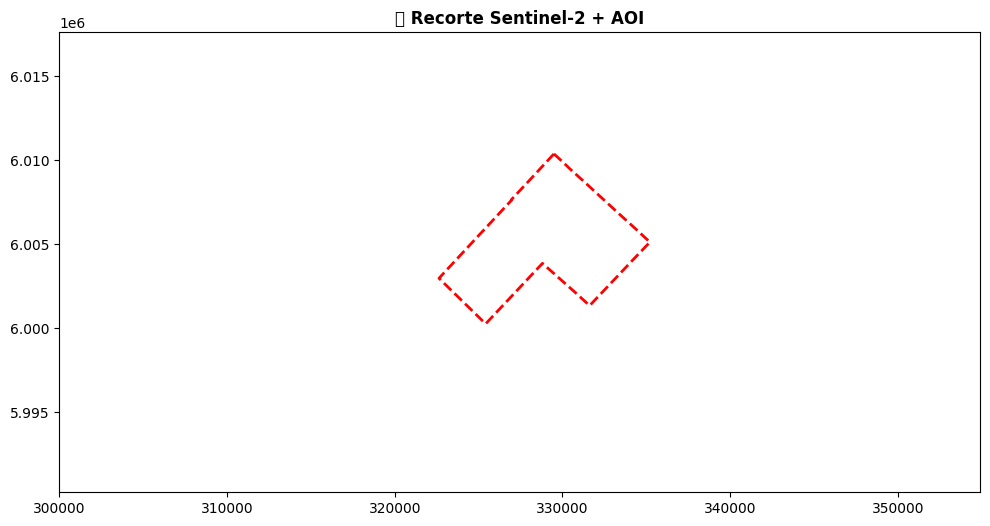

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping

# Archivo RGB real recortado
tif_path = "D:/sentinel_data/S2B_21HUA_20240123_0_L2A_rgb_real_clipped.tif"

# Polígono original (en EPSG:4326)
aoi_gdf = gpd.GeoDataFrame({'geometry': [polygon_shapely]}, crs="EPSG:4326")

# Abrimos el raster
with rasterio.open(tif_path) as src:
    # Convertir AOI al CRS del raster
    aoi_projected = aoi_gdf.to_crs(src.crs)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, title="🛰️ Recorte Sentinel-2 + AOI")
    aoi_projected.boundary.plot(ax=ax, edgecolor='red', linewidth=2, linestyle='--')
    plt.tight_layout()
    plt.show()

In [7]:
# Guardar polígono como archivo GeoJSON
aoi_gdf.to_file("aoi_polygon.geojson", driver="GeoJSON")

# Si querés también como .KML (opcional)
aoi_gdf.to_file("aoi_polygon.kml", driver="KML")

In [8]:
import os
print(os.getcwd())


d:\sentinel_data


C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


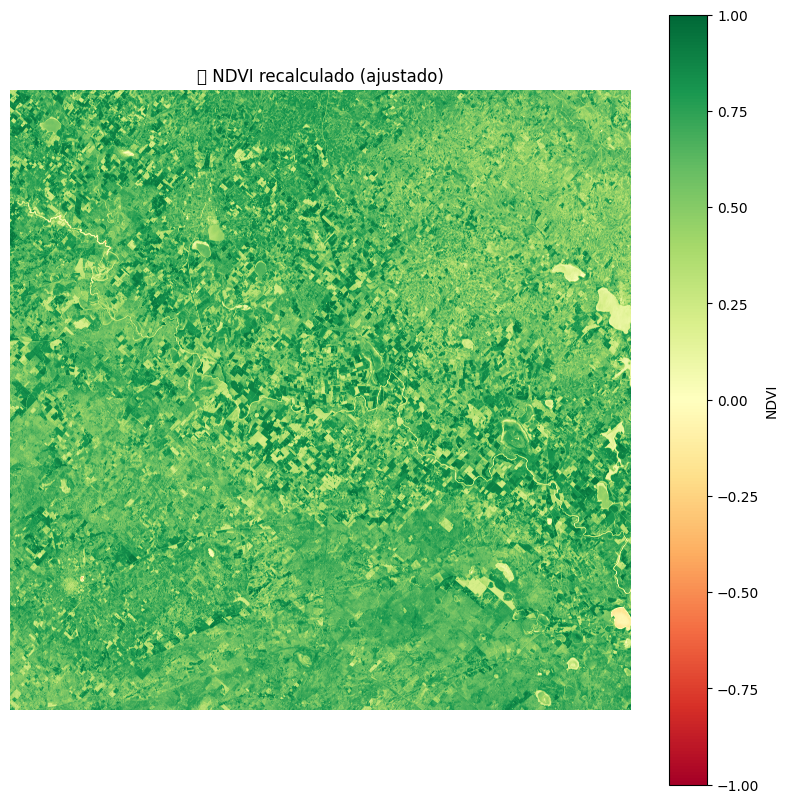

In [9]:
nir_path = "D:/sentinel_data/S2B_21HUA_20240123_0_L2A/nir.tif"
red_path = "D:/sentinel_data/S2B_21HUA_20240123_0_L2A/red.tif"

with rasterio.open(nir_path) as nir_src, rasterio.open(red_path) as red_src:
    nir = nir_src.read(1).astype('float32')
    red = red_src.read(1).astype('float32')
    
    # Escalamos a reflectancia 0.0 - 1.0
    nir = nir / 10000
    red = red / 10000
    
    # Evitar división por cero
    denominator = (nir + red)
    numerator = (nir - red)
    
    ndvi = np.where(denominator == 0, 0, numerator / denominator)
    ndvi = np.clip(ndvi, -1, 1)
    
    # Visualizar
    plt.figure(figsize=(10, 10))
    plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title("🌱 NDVI recalculado (ajustado)")
    plt.axis('off')
    plt.show()


⚠️ Reproyectando AOI al CRS del raster...


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4090112222.py:38: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


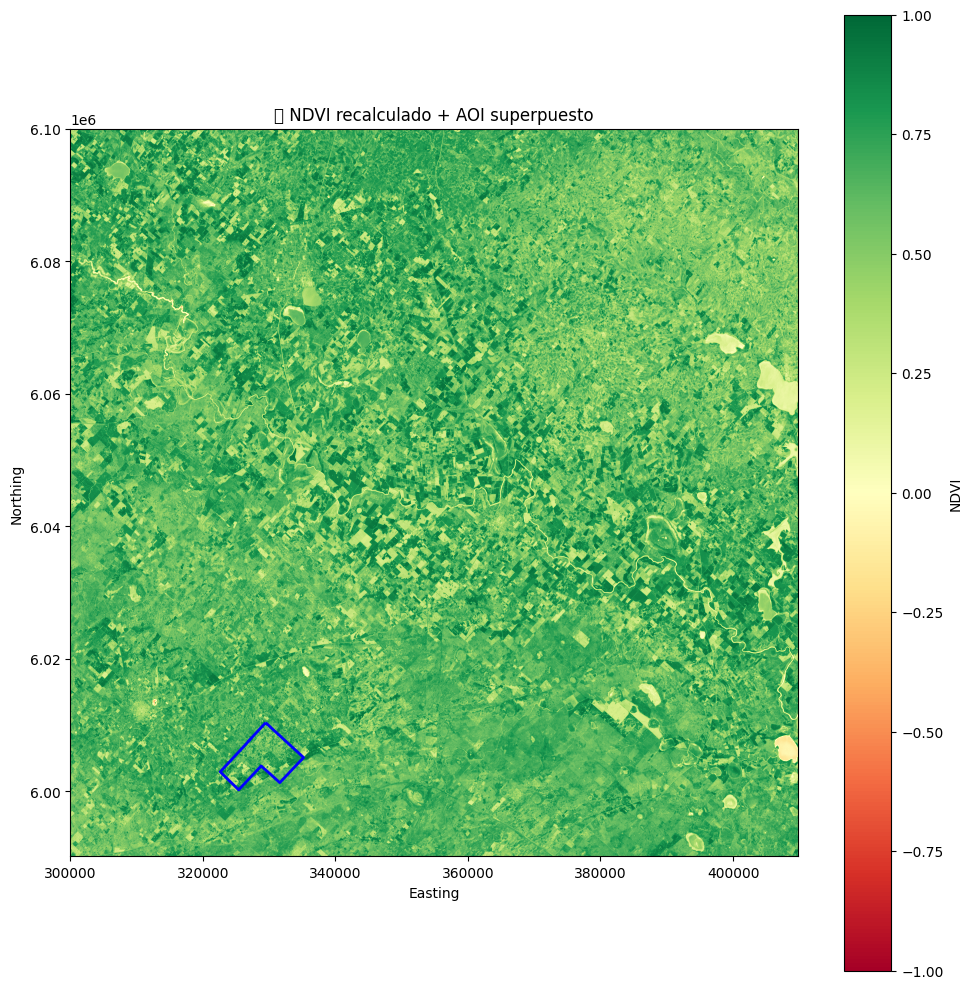

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import mapping

# --- 1. Cargar el polígono ---
aoi_gdf = gpd.read_file("aoi_polygon.geojson")

# --- 2. Usar el mismo archivo de referencia (red o nir) para obtener bounds y CRS ---
with rasterio.open(red_path) as red_src:
    bounds = red_src.bounds
    crs = red_src.crs
    transform = red_src.transform
    width = red_src.width
    height = red_src.height

# --- 3. Reproyectar polígono si es necesario ---
if aoi_gdf.crs != crs:
    print("⚠️ Reproyectando AOI al CRS del raster...")
    aoi_gdf = aoi_gdf.to_crs(crs)

# --- 4. Visualizar NDVI y AOI ---
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar NDVI generado (ya lo tenés como array)
ndvi_plot = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1,
                      extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

# Superponer polígono
aoi_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)

# Estética
plt.colorbar(ndvi_plot, ax=ax, label="NDVI")
plt.title("🌱 NDVI recalculado + AOI superpuesto")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.tight_layout()
plt.show()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2356566682.py:32: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


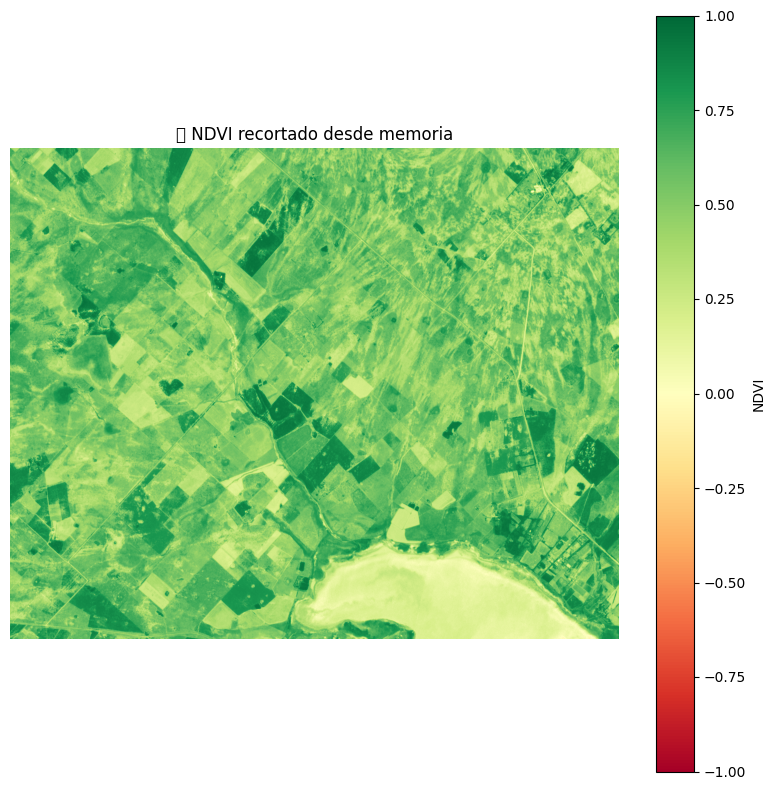

📊 Estadísticas del NDVI recortado:
 - Media: 0.5328
 - Desvío estándar: 0.1746
 - Mediana: 0.5394


In [11]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# 🔹 1. Cargar el polígono desde archivo o variable
aoi_gdf = gpd.read_file("aoi_polygon.geojson")  # o usá directamente polygon_shapely si ya lo tenés
aoi_proj = aoi_gdf.to_crs(crs=nir_src.crs)  # mismo CRS que las bandas
aoi_geojson = [mapping(aoi_proj.iloc[0].geometry)]  # listo para rasterio.mask

# 🔹 2. Volver a abrir una de las bandas para usar su metadata (solo para masking)
with rasterio.open(nir_path) as src:
    # Usamos la metadata solo para definir transformaciones
    out_image, out_transform = mask(src, aoi_geojson, crop=True)
    out_meta = src.meta.copy()

# 🔹 3. Recortar el NDVI que ya tenés en memoria (usando las coordenadas del masking anterior)
row_start, col_start = ~src.transform * (out_transform.c, out_transform.f)
row_start, col_start = int(row_start), int(col_start)

height, width = out_image.shape[1:]  # dimensiones del recorte
ndvi_crop = ndvi[row_start:row_start + height, col_start:col_start + width]

# 🔹 4. Visualizar el NDVI recortado
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_crop, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title("🌱 NDVI recortado desde memoria")
plt.axis('off')
plt.tight_layout()
plt.show()

# 🔹 5. Estadísticas del recorte
valid_ndvi = ndvi_crop[(ndvi_crop >= -1) & (ndvi_crop <= 1)]
print(f"📊 Estadísticas del NDVI recortado:")
print(f" - Media: {valid_ndvi.mean():.4f}")
print(f" - Desvío estándar: {valid_ndvi.std():.4f}")
print(f" - Mediana: {np.median(valid_ndvi):.4f}")

In [12]:
import pandas as pd
minx, miny, maxx, maxy = aoi_gdf.total_bounds
start_date = "2022-01-01"
end_date = "2025-03-01"
max_cloud = 10


# Buscar escenas desde la API de AWS Earth Search
scenes = find_sentinel2_scenes((minx, miny, maxx, maxy), start_date, end_date, max_cloud)

# Ordenarlas por menor nubosidad
scenes_sorted = sorted(scenes, key=lambda x: x["properties"].get("eo:cloud_cover", 100))

# Cargar el polígono una vez (en EPSG:4326)
aoi_gdf = gpd.read_file("aoi_polygon.geojson")

ndvi_series = []

for scene in scenes_sorted[:100]:  # Ajustá el rango si querés más escenas
    scene_id = scene["id"]
    date = scene["properties"]["datetime"][:10]
    print(f"✅ Procesando: {scene_id} - {date}")

    # --- 1. Descargar bandas si no existen ---
    band_mapping = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir"}
    band_files = {}
    for band_id, name in band_mapping.items():
        band_files[band_id] = download_band(scene, name, output_dir)

    if not all(band_files.values()):
        print("⚠️ Faltan bandas, salto esta escena")
        continue

    # --- 2. Recalcular NDVI como array numpy ---
    with rasterio.open(band_files["B08"]) as nir_src, rasterio.open(band_files["B04"]) as red_src:
        nir = nir_src.read(1).astype("float32") / 10000
        red = red_src.read(1).astype("float32") / 10000
        ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))
        ndvi = np.clip(ndvi, -1, 1)

        # --- 3. Reproyectar polígono al CRS de la imagen ---
        aoi_proj = aoi_gdf.to_crs(nir_src.crs)
        aoi_geom = [mapping(aoi_proj.iloc[0].geometry)]

        # --- 4. Usar rasterio.mask para obtener la ventana ---
        try:
            out_image, out_transform = mask(nir_src, aoi_geom, crop=True)
        except Exception as e:
            print(f"❌ No se pudo recortar {scene_id}: {e}")
            continue

        # --- 5. Obtener índice de recorte sobre la matriz NDVI ---
        row_start, col_start = ~nir_src.transform * (out_transform.c, out_transform.f)
        row_start, col_start = int(row_start), int(col_start)
        height, width = out_image.shape[1:]
        ndvi_crop = ndvi[row_start:row_start + height, col_start:col_start + width]

        # --- 6. Calcular estadísticas ---
        valid = ndvi_crop[(ndvi_crop >= -1) & (ndvi_crop <= 1)]
        ndvi_mean = float(np.mean(valid)) if valid.size > 0 else np.nan
        print(f"📈 NDVI medio: {ndvi_mean:.4f}")
        ndvi_series.append((date, ndvi_mean))

# --- 7. Convertir a DataFrame para análisis temporal ---
ndvi_df = pd.DataFrame(ndvi_series, columns=["fecha", "ndvi_mean"]).sort_values("fecha")
print("\n🗓️ NDVI en el tiempo:")
print(ndvi_df)

URL de búsqueda: https://earth-search.aws.element84.com/v1/search?collections=sentinel-2-l2a&bbox=-58.9703,-36.1268,-58.8302,-36.0362&datetime=2022-01-01T00:00:00Z/2025-03-01T23:59:59Z&limit=100&query={"eo:cloud_cover":{"lte":10}}
Se encontraron 75 escenas
✅ Procesando: S2C_21HUA_20250122_0_L2A - 2025-01-22
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.4213
✅ Procesando: S2B_21HUA_20231005_0_L2A - 2023-10-05
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6595
✅ Procesando: S2B_21HUA_20241228_0_L2A - 2024-12-28
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5477
✅ Procesando: S2A_21HUA_20230123_0_L2A - 2023-01-23
La banda blue ya existe localmente
La banda green ya ex

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.3285
✅ Procesando: S2A_21HUA_20230113_0_L2A - 2023-01-13
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.3902
✅ Procesando: S2B_21HUA_20241208_0_L2A - 2024-12-08
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5770
✅ Procesando: S2A_21HUA_20221124_0_L2A - 2022-11-24
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.3547
✅ Procesando: S2A_21HUA_20231109_0_L2A - 2023-11-09
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6220
✅ Procesando: S2B_21HUA_20220413_0_L2A - 2022-04-13
La banda blue ya existe localmente
La banda green ya existe localmente
La banda

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6722
✅ Procesando: S2B_21HUA_20221229_0_L2A - 2022-12-29
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.4740
✅ Procesando: S2B_21HUA_20220503_0_L2A - 2022-05-03
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6169
✅ Procesando: S2B_21HUA_20230408_1_L2A - 2023-04-08
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5532
✅ Procesando: S2B_21HUA_20221010_0_L2A - 2022-10-10
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5380
✅ Procesando: S2B_21HUA_20230428_0_L2A - 2023-04-28
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5839
✅ Procesando: S2A_21HUA_20221104_0_L2A - 2022-11-04
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.4602
✅ Procesando: S2B_21HUA_20230528_0_L2A - 2023-05-28
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6294
✅ Procesando: S2A_21HUA_20220915_0_L2A - 2022-09-15
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5911
✅ Procesando: S2A_21HUA_20240726_0_L2A - 2024-07-26
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.0000
✅ Procesando: S2A_21HUA_20220905_0_L2A - 2022-09-05
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5886
✅ Procesando: S2A_21HUA_20230503_0_L2A - 2023-05-03
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5682
✅ Procesando: S2B_21HUA_20220811_0_L2A - 2022-08-11
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5270
✅ Procesando: S2A_21HUA_20220428_0_L2A - 2022-04-28
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6512
✅ Procesando: S2B_21HUA_20220910_0_L2A - 2022-09-10
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6033
✅ Procesando: S2B_21HUA_20220103_0_L2A - 2022-01-03
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.3675
✅ Procesando: S2B_21HUA_20240711_0_L2A - 2024-07-11
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5171
✅ Procesando: S2B_21HUA_20220113_0_L2A - 2022-01-13
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.3297
✅ Procesando: S2A_21HUA_20241203_0_L2A - 2024-12-03
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5803
✅ Procesando: S2A_21HUA_20220108_0_L2A - 2022-01-08
La banda blue ya existe localmente
La banda green ya existe localmente
La banda

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4540
✅ Procesando: S2B_21HUA_20231124_0_L2A - 2023-11-24
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6260
✅ Procesando: S2A_21HUA_20220707_0_L2A - 2022-07-07
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4755
✅ Procesando: S2B_21HUA_20231104_0_L2A - 2023-11-04
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6316
✅ Procesando: S2A_21HUA_20240914_0_L2A - 2024-09-14
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6270
✅ Procesando: S2A_21HUA_20230612_0_L2A - 2023-06-12
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6101
✅ Procesando: S2B_21HUA_20220612_0_L2A - 2022-06-12
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.4946
✅ Procesando: S2A_21HUA_20220617_0_L2A - 2022-06-17
La banda blue ya existe localmente
La banda green ya existe localmente
La banda

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5182
✅ Procesando: S2A_21HUA_20230413_0_L2A - 2023-04-13
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5898
✅ Procesando: S2A_21HUA_20220319_1_L2A - 2022-03-19
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.7455
✅ Procesando: S2A_21HUA_20220319_0_L2A - 2022-03-19
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.7454
✅ Procesando: S2B_21HUA_20220314_0_L2A - 2022-03-14
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.7254
✅ Procesando: S2A_21HUA_20250112_0_L2A - 2025-01-12
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.4294
✅ Procesando: S2A_21HUA_20231020_0_L2A - 2023-10-20
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5638
✅ Procesando: S2C_21HUA_20250201_0_L2A - 2025-02-01
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.4278
✅ Procesando: S2A_21HUA_20240108_0_L2A - 2024-01-08
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6624
✅ Procesando: S2B_21HUA_20230717_0_L2A - 2023-07-17
La banda blue ya existe localmente
La banda green ya existe localmente
La banda

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\516545524.py:38: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4592
✅ Procesando: S2B_21HUA_20230508_0_L2A - 2023-05-08
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5629
✅ Procesando: S2A_21HUA_20220826_0_L2A - 2022-08-26
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.5433
✅ Procesando: S2A_21HUA_20240924_0_L2A - 2024-09-24
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6532
✅ Procesando: S2C_21HUA_20250221_0_L2A - 2025-02-21
La banda blue ya existe localmente
La banda green ya existe localmente
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6241
✅ Procesando: S2B_21HUA_20241029_0_L2A - 2024-10-29
La banda blue ya existe localmente
La banda green ya existe localmente
La banda

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3454803071.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


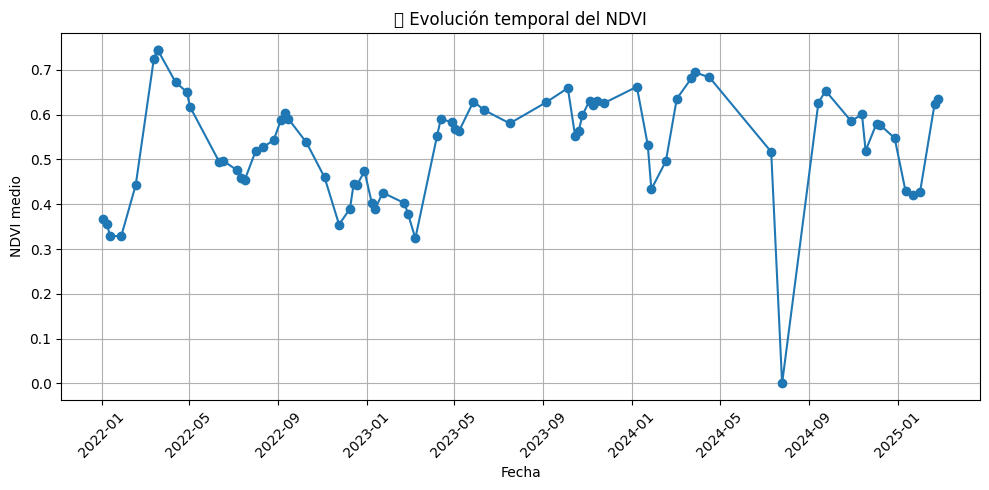

In [13]:
import matplotlib.pyplot as plt

# Asegurarnos que las fechas están en formato datetime
ndvi_df["fecha"] = pd.to_datetime(ndvi_df["fecha"])

# Crear gráfico
plt.figure(figsize=(10, 5))
plt.plot(ndvi_df["fecha"], ndvi_df["ndvi_mean"], marker='o', linestyle='-')
plt.title("📈 Evolución temporal del NDVI")
plt.xlabel("Fecha")
plt.ylabel("NDVI medio")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
#print(df.head())
#print(df["gndvi_mean"].describe())

✅ Procesando GNDVI: S2C_21HUA_20250122_0_L2A - 2025-01-22
🌿 GNDVI medio: 0.4729
✅ Procesando GNDVI: S2B_21HUA_20231005_0_L2A - 2023-10-05
🌿 GNDVI medio: 0.6040
✅ Procesando GNDVI: S2B_21HUA_20241228_0_L2A - 2024-12-28
🌿 GNDVI medio: 0.5446
✅ Procesando GNDVI: S2A_21HUA_20230123_0_L2A - 2023-01-23
🌿 GNDVI medio: 0.4762
✅ Procesando GNDVI: S2B_21HUA_20240123_0_L2A - 2024-01-23
🌿 GNDVI medio: 0.5509
✅ Procesando GNDVI: S2A_21HUA_20241113_0_L2A - 2024-11-13
🌿 GNDVI medio: 0.5762
✅ Procesando GNDVI: S2B_21HUA_20221209_0_L2A - 2022-12-09
🌿 GNDVI medio: 0.4632
✅ Procesando GNDVI: S2B_21HUA_20231025_0_L2A - 2023-10-25
🌿 GNDVI medio: 0.5738
✅ Procesando GNDVI: S2A_21HUA_20220217_0_L2A - 2022-02-17
🌿 GNDVI medio: 0.4097
✅ Procesando GNDVI: S2B_21HUA_20230227_0_L2A - 2023-02-27
🌿 GNDVI medio: 0.4586
✅ Procesando GNDVI: S2B_21HUA_20231114_0_L2A - 2023-11-14
🌿 GNDVI medio: 0.5941
✅ Procesando GNDVI: S2A_21HUA_20240417_0_L2A - 2024-04-17
🌿 GNDVI medio: 0.6356
✅ Procesando GNDVI: S2A_21HUA_20220128_0

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.3237
✅ Procesando GNDVI: S2A_21HUA_20230113_0_L2A - 2023-01-13
🌿 GNDVI medio: 0.4619
✅ Procesando GNDVI: S2B_21HUA_20241208_0_L2A - 2024-12-08
🌿 GNDVI medio: 0.5653
✅ Procesando GNDVI: S2A_21HUA_20221124_0_L2A - 2022-11-24
🌿 GNDVI medio: 0.4327
✅ Procesando GNDVI: S2A_21HUA_20231109_0_L2A - 2023-11-09
🌿 GNDVI medio: 0.5887
✅ Procesando GNDVI: S2B_21HUA_20220413_0_L2A - 2022-04-13


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.6379
✅ Procesando GNDVI: S2B_21HUA_20221229_0_L2A - 2022-12-29
🌿 GNDVI medio: 0.4936
✅ Procesando GNDVI: S2B_21HUA_20220503_0_L2A - 2022-05-03


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.6059
✅ Procesando GNDVI: S2B_21HUA_20230408_1_L2A - 2023-04-08


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5551
✅ Procesando GNDVI: S2B_21HUA_20221010_0_L2A - 2022-10-10


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5491
✅ Procesando GNDVI: S2B_21HUA_20230428_0_L2A - 2023-04-28
🌿 GNDVI medio: 0.5690
✅ Procesando GNDVI: S2A_21HUA_20221104_0_L2A - 2022-11-04
🌿 GNDVI medio: 0.5016
✅ Procesando GNDVI: S2B_21HUA_20230528_0_L2A - 2023-05-28


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.6175
✅ Procesando GNDVI: S2A_21HUA_20220915_0_L2A - 2022-09-15
🌿 GNDVI medio: 0.5867
✅ Procesando GNDVI: S2A_21HUA_20240726_0_L2A - 2024-07-26


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.0000
✅ Procesando GNDVI: S2A_21HUA_20220905_0_L2A - 2022-09-05


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5776
✅ Procesando GNDVI: S2A_21HUA_20230503_0_L2A - 2023-05-03
🌿 GNDVI medio: 0.5795
✅ Procesando GNDVI: S2B_21HUA_20220811_0_L2A - 2022-08-11


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5438
✅ Procesando GNDVI: S2A_21HUA_20220428_0_L2A - 2022-04-28


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.6380
✅ Procesando GNDVI: S2B_21HUA_20220910_0_L2A - 2022-09-10


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5854
✅ Procesando GNDVI: S2B_21HUA_20220103_0_L2A - 2022-01-03
🌿 GNDVI medio: 0.4473
✅ Procesando GNDVI: S2B_21HUA_20240711_0_L2A - 2024-07-11
🌿 GNDVI medio: 0.5431
✅ Procesando GNDVI: S2B_21HUA_20220113_0_L2A - 2022-01-13
🌿 GNDVI medio: 0.4276
✅ Procesando GNDVI: S2A_21HUA_20241203_0_L2A - 2024-12-03
🌿 GNDVI medio: 0.5685
✅ Procesando GNDVI: S2A_21HUA_20220108_0_L2A - 2022-01-08
🌿 GNDVI medio: 0.4453
✅ Procesando GNDVI: S2B_21HUA_20230108_0_L2A - 2023-01-08
🌿 GNDVI medio: 0.4526
✅ Procesando GNDVI: S2A_21HUA_20220717_0_L2A - 2022-07-17


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5236
✅ Procesando GNDVI: S2B_21HUA_20231124_0_L2A - 2023-11-24
🌿 GNDVI medio: 0.6021
✅ Procesando GNDVI: S2A_21HUA_20220707_0_L2A - 2022-07-07


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5583
✅ Procesando GNDVI: S2B_21HUA_20231104_0_L2A - 2023-11-04
🌿 GNDVI medio: 0.5945
✅ Procesando GNDVI: S2A_21HUA_20240914_0_L2A - 2024-09-14
🌿 GNDVI medio: 0.5963
✅ Procesando GNDVI: S2A_21HUA_20230612_0_L2A - 2023-06-12
🌿 GNDVI medio: 0.5900
✅ Procesando GNDVI: S2B_21HUA_20220612_0_L2A - 2022-06-12
🌿 GNDVI medio: 0.5445
✅ Procesando GNDVI: S2A_21HUA_20220617_0_L2A - 2022-06-17
🌿 GNDVI medio: 0.5774
✅ Procesando GNDVI: S2B_21HUA_20220801_0_L2A - 2022-08-01


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5615
✅ Procesando GNDVI: S2A_21HUA_20230413_0_L2A - 2023-04-13
🌿 GNDVI medio: 0.5901
✅ Procesando GNDVI: S2A_21HUA_20220319_1_L2A - 2022-03-19
🌿 GNDVI medio: 0.6661
✅ Procesando GNDVI: S2A_21HUA_20220319_0_L2A - 2022-03-19


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.6660
✅ Procesando GNDVI: S2B_21HUA_20220314_0_L2A - 2022-03-14


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.6421
✅ Procesando GNDVI: S2A_21HUA_20250112_0_L2A - 2025-01-12
🌿 GNDVI medio: 0.4763
✅ Procesando GNDVI: S2A_21HUA_20231020_0_L2A - 2023-10-20
🌿 GNDVI medio: 0.5634
✅ Procesando GNDVI: S2C_21HUA_20250201_0_L2A - 2025-02-01
🌿 GNDVI medio: 0.4819
✅ Procesando GNDVI: S2A_21HUA_20240108_0_L2A - 2024-01-08
🌿 GNDVI medio: 0.6156
✅ Procesando GNDVI: S2B_21HUA_20230717_0_L2A - 2023-07-17
🌿 GNDVI medio: 0.5852
✅ Procesando GNDVI: S2B_21HUA_20220712_0_L2A - 2022-07-12


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\700997635.py:34: RuntimeWarning: invalid value encountered in divide
  gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))


🌿 GNDVI medio: 0.5320
✅ Procesando GNDVI: S2B_21HUA_20230508_0_L2A - 2023-05-08
🌿 GNDVI medio: 0.5620
✅ Procesando GNDVI: S2A_21HUA_20220826_0_L2A - 2022-08-26
🌿 GNDVI medio: 0.5271
✅ Procesando GNDVI: S2A_21HUA_20240924_0_L2A - 2024-09-24
🌿 GNDVI medio: 0.6020
✅ Procesando GNDVI: S2C_21HUA_20250221_0_L2A - 2025-02-21
🌿 GNDVI medio: 0.5752
✅ Procesando GNDVI: S2B_21HUA_20241029_0_L2A - 2024-10-29
🌿 GNDVI medio: 0.5543
✅ Procesando GNDVI: S2A_21HUA_20230222_0_L2A - 2023-02-22
🌿 GNDVI medio: 0.4728
✅ Procesando GNDVI: S2B_21HUA_20230309_0_L2A - 2023-03-09
🌿 GNDVI medio: 0.4323
✅ Procesando GNDVI: S2B_21HUA_20221219_0_L2A - 2022-12-19
🌿 GNDVI medio: 0.4711
✅ Procesando GNDVI: S2B_21HUA_20230905_0_L2A - 2023-09-05
🌿 GNDVI medio: 0.5990
✅ Procesando GNDVI: S2A_21HUA_20221214_0_L2A - 2022-12-14
🌿 GNDVI medio: 0.4771
✅ Procesando GNDVI: S2A_21HUA_20240128_0_L2A - 2024-01-28
🌿 GNDVI medio: 0.4656
✅ Procesando GNDVI: S2A_21HUA_20240217_0_L2A - 2024-02-17
🌿 GNDVI medio: 0.4759
✅ Procesando GNDVI

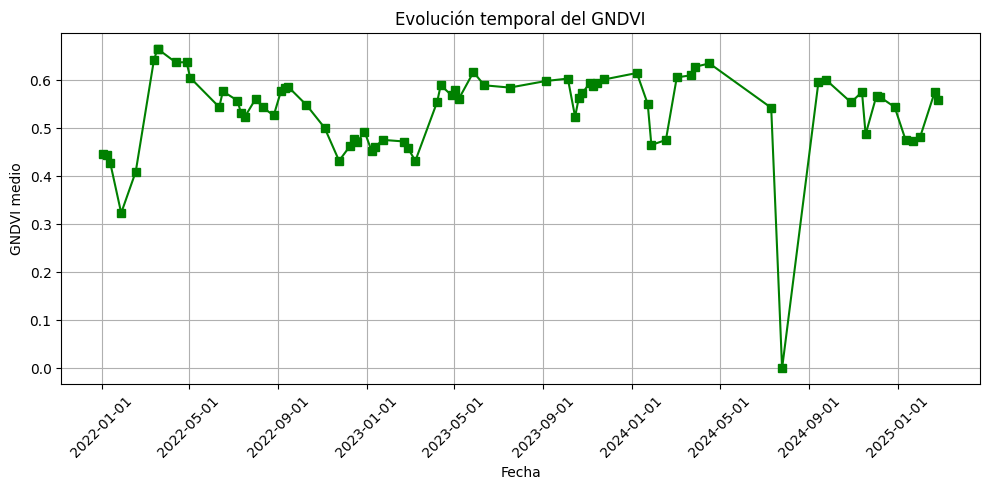

In [15]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegurarse de cargar el polígono una vez (en EPSG:4326)
aoi_gdf = gpd.read_file("aoi_polygon.geojson")

gndvi_series = []

for scene in scenes_sorted[:100]:  # ajustá el rango si querés más escenas
    scene_id = scene["id"]
    date = scene["properties"]["datetime"][:10]
    print(f"✅ Procesando GNDVI: {scene_id} - {date}")

    # Buscar paths locales de las bandas descargadas
    scene_dir = os.path.join(output_dir, scene_id)
    green_path = os.path.join(scene_dir, "green.tif")
    nir_path = os.path.join(scene_dir, "nir.tif")

    if not (os.path.exists(green_path) and os.path.exists(nir_path)):
        print(f"⚠️ Faltan archivos para {scene_id}, se omite.")
        continue

    # Leer las bandas ya descargadas
    with rasterio.open(nir_path) as nir_src, rasterio.open(green_path) as green_src:
        nir = nir_src.read(1).astype("float32") / 10000
        green = green_src.read(1).astype("float32") / 10000

        # Calcular GNDVI
        gndvi = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))
        gndvi = np.clip(gndvi, -1, 1)

        # Reproyectar polígono
        aoi_proj = aoi_gdf.to_crs(nir_src.crs)
        aoi_geom = [mapping(aoi_proj.iloc[0].geometry)]

        # Recortar por polígono
        try:
            out_image, out_transform = mask(nir_src, aoi_geom, crop=True)
        except Exception as e:
            print(f"❌ No se pudo recortar {scene_id}: {e}")
            continue

        row_start, col_start = ~nir_src.transform * (out_transform.c, out_transform.f)
        row_start, col_start = int(row_start), int(col_start)
        height, width = out_image.shape[1:]

        gndvi_crop = gndvi[row_start:row_start + height, col_start:col_start + width]

        # Calcular GNDVI medio
        valid = gndvi_crop[(gndvi_crop >= -1) & (gndvi_crop <= 1)]
        gndvi_mean = float(np.mean(valid)) if valid.size > 0 else np.nan
        print(f"🌿 GNDVI medio: {gndvi_mean:.4f}")
        gndvi_series.append((date, gndvi_mean))

# Crear DataFrame con resultados
gndvi_df = pd.DataFrame(gndvi_series, columns=["fecha", "gndvi_mean"]).sort_values("fecha")

# Graficar GNDVI
gndvi_df["fecha"] = pd.to_datetime(gndvi_df["fecha"])

plt.figure(figsize=(10, 5))
plt.plot(gndvi_df["fecha"], gndvi_df["gndvi_mean"], marker='s', linestyle='-', color='green')
plt.title("Evolución temporal del GNDVI")
plt.xlabel("Fecha")
plt.ylabel("GNDVI medio")
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

In [16]:
import os

# Mostrar directorio actual
print("📍 Estás en:", os.getcwd())

# Mostrar contenido del directorio actual
print("📁 Carpetas disponibles:", os.listdir())

📍 Estás en: d:\sentinel_data
📁 Carpetas disponibles: ['.git', 'aoi_polygon.geojson', 'aoi_polygon.kml', 'chirps-v2.0.2022.days_p05.nc', 'chirps-v2.0.2023.days_p05.nc', 'chirps-v2.0.2024.days_p05.nc', 'chirps-v2.0.2025.days_p05.nc', 'cordoba', 'deforestacion_20220413_20220503.cpg', 'deforestacion_20220413_20220503.dbf', 'deforestacion_20220413_20220503.prj', 'deforestacion_20220413_20220503.shp', 'deforestacion_20220413_20220503.shx', 'dymaxion', 'EntreRios', 'Laprida', 'mapas_cultivo.png', 'mapa_verano2023.html', 'MNC_invierno2021.tif', 'MNC_invierno2022.tif', 'MNC_invierno2023.tif', 'MNC_verano-2023.tif', 'MNC_verano-2024.tif', 'MNC_verano2021.tif', 'MNC_verano2022.tif', 'ndvi.tif', 'ndvi_promedios.csv', 'ph_en_agua_de_perfiles_suelo.png', 'recorte_cultivo.png', 'S2A_21HUA_20220108_0_L2A', 'S2A_21HUA_20220128_0_L2A', 'S2A_21HUA_20220217_0_L2A', 'S2A_21HUA_20220319_0_L2A', 'S2A_21HUA_20220319_1_L2A', 'S2A_21HUA_20220428_0_L2A', 'S2A_21HUA_20220617_0_L2A', 'S2A_21HUA_20220707_0_L2A', 'S

In [17]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd

# Asegurarse de que el polígono esté cargado antes
aoi_gdf = gpd.read_file("aoi_polygon.geojson")

minx, miny, maxx, maxy = aoi_gdf.total_bounds
start_date = "2022-01-01"
end_date = "2025-03-01"
max_cloud = 10

# Buscar y ordenar escenas
scenes = find_sentinel2_scenes((minx, miny, maxx, maxy), start_date, end_date, max_cloud)
scenes_sorted = sorted(scenes, key=lambda x: x["properties"].get("eo:cloud_cover", 100))

ndvi_series = []

for scene in scenes_sorted[:100]:
    scene_id = scene["id"]
    date = scene["properties"]["datetime"][:10]
    print(f"✅ Procesando: {scene_id} - {date}")

    # --- 1. Obtener bandas ya descargadas ---
    band_mapping = {"B04": "red", "B08": "nir"}
    band_files = {}
    for band_id, name in band_mapping.items():
        band_files[band_id] = download_band(scene, name, output_dir)

    if not all(band_files.values()):
        print("⚠️ Faltan bandas, salto esta escena")
        continue

    try:
        with rasterio.open(band_files["B08"]) as nir_src, rasterio.open(band_files["B04"]) as red_src:
            # Reproyectar el polígono al CRS de la imagen
            aoi_proj = aoi_gdf.to_crs(nir_src.crs)
            aoi_geom = [mapping(aoi_proj.iloc[0].geometry)]

            # Recortar ambas bandas con el polígono
            nir_crop, _ = mask(nir_src, aoi_geom, crop=True)
            red_crop, _ = mask(red_src, aoi_geom, crop=True)

            # Calcular NDVI con los recortes
            nir = nir_crop[0].astype("float32") / 10000
            red = red_crop[0].astype("float32") / 10000
            ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))
            ndvi_crop = np.clip(ndvi_crop, -1, 1)

            # Filtrar valores válidos
            valid = ndvi_crop[(ndvi_crop >= -1) & (ndvi_crop <= 1) & (ndvi_crop != 0)]
            ndvi_mean = float(np.mean(valid)) if valid.size > 0 else np.nan

            print(f"📈 NDVI medio: {ndvi_mean:.4f}")
            ndvi_series.append((date, ndvi_mean))

    except Exception as e:
        print(f"❌ Error procesando {scene_id}: {e}")
        continue

# --- 7. Crear DataFrame ---
ndvi_df = pd.DataFrame(ndvi_series, columns=["fecha", "ndvi_mean"]).sort_values("fecha")
print("\n📊 NDVI en el tiempo:")
print(ndvi_df)

URL de búsqueda: https://earth-search.aws.element84.com/v1/search?collections=sentinel-2-l2a&bbox=-58.9703,-36.1268,-58.8302,-36.0362&datetime=2022-01-01T00:00:00Z/2025-03-01T23:59:59Z&limit=100&query={"eo:cloud_cover":{"lte":10}}
Se encontraron 75 escenas
✅ Procesando: S2C_21HUA_20250122_0_L2A - 2025-01-22
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5287
✅ Procesando: S2B_21HUA_20231005_0_L2A - 2023-10-05
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5774
✅ Procesando: S2B_21HUA_20241228_0_L2A - 2024-12-28
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6197
✅ Procesando: S2A_21HUA_20230123_0_L2A - 2023-01-23
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4554
✅ Procesando: S2B_21HUA_20240123_0_L2A - 2024-01-23
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6363
✅ Procesando: S2A_21HUA_20241113_0_L2A - 2024-11-13
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6131
✅ Procesando: S2B_21HUA_20221209_0_L2A - 2022-12-09
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4404
✅ Procesando: S2B_21HUA_20231025_0_L2A - 2023-10-25
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5134
✅ Procesando: S2A_21HUA_20220217_0_L2A - 2022-02-17
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4725
✅ Procesando: S2B_21HUA_20230227_0_L2A - 2023-02-27
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5817
✅ Procesando: S2B_21HUA_20231114_0_L2A - 2023-11-14
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5796
✅ Procesando: S2A_21HUA_20240417_0_L2A - 2024-04-17
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6770
✅ Procesando: S2A_21HUA_20220128_0_L2A - 2022-01-28
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.3944
✅ Procesando: S2A_21HUA_20230113_0_L2A - 2023-01-13
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4261
✅ Procesando: S2B_21HUA_20241208_0_L2A - 2024-12-08
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6264
✅ Procesando: S2A_21HUA_20221124_0_L2A - 2022-11-24
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4341
✅ Procesando: S2A_21HUA_20231109_0_L2A - 2023-11-09
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5571
✅ Procesando: S2B_21HUA_20220413_0_L2A - 2022-04-13
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6792
✅ Procesando: S2B_21HUA_20221229_0_L2A - 2022-12-29
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4444
✅ Procesando: S2B_21HUA_20220503_0_L2A - 2022-05-03
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6021
✅ Procesando: S2B_21HUA_20230408_1_L2A - 2023-04-08
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5697
✅ Procesando: S2B_21HUA_20221010_0_L2A - 2022-10-10
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5284
✅ Procesando: S2B_21HUA_20230428_0_L2A - 2023-04-28
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5170
✅ Procesando: S2A_21HUA_20221104_0_L2A - 2022-11-04
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4750
✅ Procesando: S2B_21HUA_20230528_0_L2A - 2023-05-28
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5644
✅ Procesando: S2A_21HUA_20220915_0_L2A - 2022-09-15
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5445
✅ Procesando: S2A_21HUA_20240726_0_L2A - 2024-07-26
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4731
✅ Procesando: S2A_21HUA_20220905_0_L2A - 2022-09-05
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5390
✅ Procesando: S2A_21HUA_20230503_0_L2A - 2023-05-03
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5294
✅ Procesando: S2B_21HUA_20220811_0_L2A - 2022-08-11
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4657
✅ Procesando: S2A_21HUA_20220428_0_L2A - 2022-04-28
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6537
✅ Procesando: S2B_21HUA_20220910_0_L2A - 2022-09-10
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5572
✅ Procesando: S2B_21HUA_20220103_0_L2A - 2022-01-03
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6282
✅ Procesando: S2B_21HUA_20240711_0_L2A - 2024-07-11
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5049
✅ Procesando: S2B_21HUA_20220113_0_L2A - 2022-01-13
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5292
✅ Procesando: S2A_21HUA_20241203_0_L2A - 2024-12-03
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6392
✅ Procesando: S2A_21HUA_20220108_0_L2A - 2022-01-08
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5940
✅ Procesando: S2B_21HUA_20230108_0_L2A - 2023-01-08
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4257
✅ Procesando: S2A_21HUA_20220717_0_L2A - 2022-07-17
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.3864
✅ Procesando: S2B_21HUA_20231124_0_L2A - 2023-11-24
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5434
✅ Procesando: S2A_21HUA_20220707_0_L2A - 2022-07-07
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4174
✅ Procesando: S2B_21HUA_20231104_0_L2A - 2023-11-04
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5522
✅ Procesando: S2A_21HUA_20240914_0_L2A - 2024-09-14
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5991
✅ Procesando: S2A_21HUA_20230612_0_L2A - 2023-06-12
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5379
✅ Procesando: S2B_21HUA_20220612_0_L2A - 2022-06-12
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4390
✅ Procesando: S2A_21HUA_20220617_0_L2A - 2022-06-17
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4542
✅ Procesando: S2B_21HUA_20220801_0_L2A - 2022-08-01
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4412
✅ Procesando: S2A_21HUA_20230413_0_L2A - 2023-04-13
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5825
✅ Procesando: S2A_21HUA_20220319_1_L2A - 2022-03-19
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.7321
✅ Procesando: S2A_21HUA_20220319_0_L2A - 2022-03-19
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.7320
✅ Procesando: S2B_21HUA_20220314_0_L2A - 2022-03-14
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.7139
✅ Procesando: S2A_21HUA_20250112_0_L2A - 2025-01-12
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5596
✅ Procesando: S2A_21HUA_20231020_0_L2A - 2023-10-20
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4887
✅ Procesando: S2C_21HUA_20250201_0_L2A - 2025-02-01
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4963
✅ Procesando: S2A_21HUA_20240108_0_L2A - 2024-01-08
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.7208
✅ Procesando: S2B_21HUA_20230717_0_L2A - 2023-07-17
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5230
✅ Procesando: S2B_21HUA_20220712_0_L2A - 2022-07-12
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.3943
✅ Procesando: S2B_21HUA_20230508_0_L2A - 2023-05-08
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5250
✅ Procesando: S2A_21HUA_20220826_0_L2A - 2022-08-26
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5056
✅ Procesando: S2A_21HUA_20240924_0_L2A - 2024-09-24
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6175
✅ Procesando: S2C_21HUA_20250221_0_L2A - 2025-02-21
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4836
✅ Procesando: S2B_21HUA_20241029_0_L2A - 2024-10-29
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5800
✅ Procesando: S2A_21HUA_20230222_0_L2A - 2023-02-22
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5970
✅ Procesando: S2B_21HUA_20230309_0_L2A - 2023-03-09
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4838
✅ Procesando: S2B_21HUA_20221219_0_L2A - 2022-12-19
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4617
✅ Procesando: S2B_21HUA_20230905_0_L2A - 2023-09-05
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5676
✅ Procesando: S2A_21HUA_20221214_0_L2A - 2022-12-14
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.4407
✅ Procesando: S2A_21HUA_20240128_0_L2A - 2024-01-28
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5730
✅ Procesando: S2A_21HUA_20240217_0_L2A - 2024-02-17
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6468
✅ Procesando: S2B_21HUA_20240323_0_L2A - 2024-03-23
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6028
✅ Procesando: S2B_21HUA_20250226_0_L2A - 2025-02-26
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5789
✅ Procesando: S2B_21HUA_20241118_0_L2A - 2024-11-18
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.6420
✅ Procesando: S2B_21HUA_20240303_0_L2A - 2024-03-03
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.7101
✅ Procesando: S2B_21HUA_20231015_0_L2A - 2023-10-15
La banda red ya existe localmente
La banda nir ya existe localmente


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


📈 NDVI medio: 0.5059
✅ Procesando: S2A_21HUA_20240328_0_L2A - 2024-03-28
La banda red ya existe localmente
La banda nir ya existe localmente
📈 NDVI medio: 0.6937

📊 NDVI en el tiempo:
         fecha  ndvi_mean
32  2022-01-03   0.628226
36  2022-01-08   0.593976
34  2022-01-13   0.529242
12  2022-01-28   0.394424
8   2022-02-17   0.472469
..         ...        ...
51  2025-01-12   0.559579
0   2025-01-22   0.528729
53  2025-02-01   0.496294
60  2025-02-21   0.483627
70  2025-02-26   0.578864

[75 rows x 2 columns]


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1476151181.py:50: RuntimeWarning: invalid value encountered in divide
  ndvi_crop = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))


In [18]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd

# Cargar polígono
aoi_gdf = gpd.read_file("aoi_polygon.geojson")

minx, miny, maxx, maxy = aoi_gdf.total_bounds
start_date = "2022-01-01"
end_date = "2025-03-01"
max_cloud = 10

# Buscar escenas
scenes = find_sentinel2_scenes((minx, miny, maxx, maxy), start_date, end_date, max_cloud)
scenes_sorted = sorted(scenes, key=lambda x: x["properties"].get("eo:cloud_cover", 100))

gndvi_series = []

for scene in scenes_sorted[:100]:
    scene_id = scene["id"]
    date = scene["properties"]["datetime"][:10]
    print(f"✅ Procesando: {scene_id} - {date}")

    # Bandas necesarias para GNDVI
    band_mapping = {"B03": "green", "B08": "nir"}
    band_files = {}
    for band_id, name in band_mapping.items():
        band_files[band_id] = download_band(scene, name, output_dir)

    if not all(band_files.values()):
        print("⚠️ Faltan bandas, salto esta escena")
        continue

    try:
        with rasterio.open(band_files["B08"]) as nir_src, rasterio.open(band_files["B03"]) as green_src:
            aoi_proj = aoi_gdf.to_crs(nir_src.crs)
            aoi_geom = [mapping(aoi_proj.iloc[0].geometry)]

            # Recorte de bandas
            nir_crop, _ = mask(nir_src, aoi_geom, crop=True)
            green_crop, _ = mask(green_src, aoi_geom, crop=True)

            # Calcular GNDVI
            nir = nir_crop[0].astype("float32") / 10000
            green = green_crop[0].astype("float32") / 10000

            with np.errstate(divide='ignore', invalid='ignore'):
                gndvi_crop = np.where((nir + green) == 0, 0, (nir - green) / (nir + green))
                gndvi_crop = np.clip(gndvi_crop, -1, 1)

            valid = gndvi_crop[(gndvi_crop >= -1) & (gndvi_crop <= 1) & (gndvi_crop != 0)]
            gndvi_mean = float(np.mean(valid)) if valid.size > 0 else np.nan

            print(f"🌿 GNDVI medio: {gndvi_mean:.4f}")
            gndvi_series.append((date, gndvi_mean))

    except Exception as e:
        print(f"❌ Error procesando {scene_id}: {e}")
        continue

# Crear DataFrame
gndvi_df = pd.DataFrame(gndvi_series, columns=["fecha", "gndvi_mean"]).sort_values("fecha")
print("\n📊 GNDVI en el tiempo:")
print(gndvi_df)

URL de búsqueda: https://earth-search.aws.element84.com/v1/search?collections=sentinel-2-l2a&bbox=-58.9703,-36.1268,-58.8302,-36.0362&datetime=2022-01-01T00:00:00Z/2025-03-01T23:59:59Z&limit=100&query={"eo:cloud_cover":{"lte":10}}
Se encontraron 75 escenas
✅ Procesando: S2C_21HUA_20250122_0_L2A - 2025-01-22
La banda green ya existe localmente
La banda nir ya existe localmente
🌿 GNDVI medio: 0.5608
✅ Procesando: S2B_21HUA_20231005_0_L2A - 2023-10-05
La banda green ya existe localmente
La banda nir ya existe localmente
🌿 GNDVI medio: 0.5820
✅ Procesando: S2B_21HUA_20241228_0_L2A - 2024-12-28
La banda green ya existe localmente
La banda nir ya existe localmente
🌿 GNDVI medio: 0.6046
✅ Procesando: S2A_21HUA_20230123_0_L2A - 2023-01-23
La banda green ya existe localmente
La banda nir ya existe localmente
🌿 GNDVI medio: 0.4993
✅ Procesando: S2B_21HUA_20240123_0_L2A - 2024-01-23
La banda green ya existe localmente
La banda nir ya existe localmente
🌿 GNDVI medio: 0.6162
✅ Procesando: S2A_21HUA

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2877018317.py:21: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


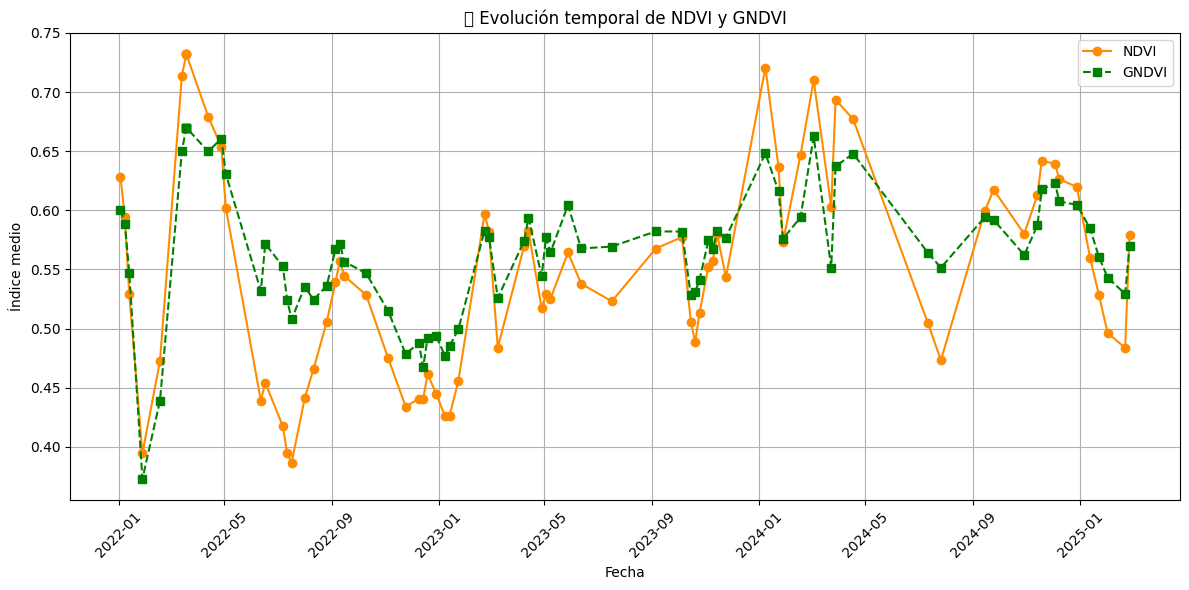

In [19]:
import matplotlib.pyplot as plt

# Asegurar formato datetime
ndvi_df["fecha"] = pd.to_datetime(ndvi_df["fecha"])
gndvi_df["fecha"] = pd.to_datetime(gndvi_df["fecha"])

# Unir ambos DataFrames por fecha
df_combinado = pd.merge(ndvi_df, gndvi_df, on="fecha", how="inner")

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_combinado["fecha"], df_combinado["ndvi_mean"], marker='o', linestyle='-', label="NDVI", color="darkorange")
plt.plot(df_combinado["fecha"], df_combinado["gndvi_mean"], marker='s', linestyle='--', label="GNDVI", color="green")

plt.title("🌱 Evolución temporal de NDVI y GNDVI")
plt.xlabel("Fecha")
plt.ylabel("Índice medio")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3335367433.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


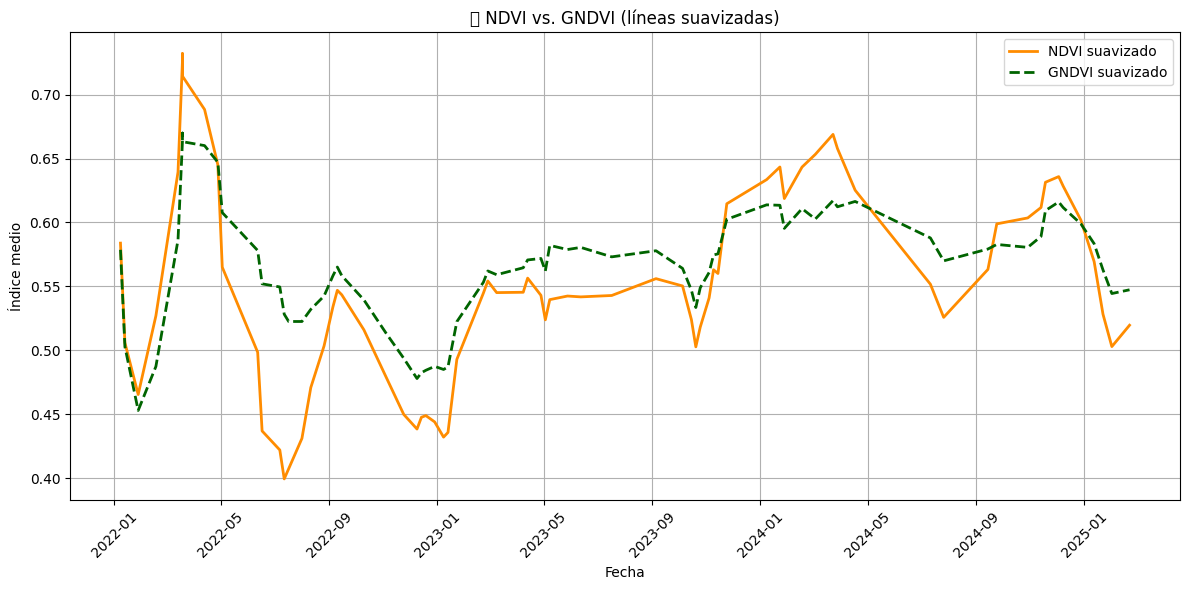

In [20]:
# Aplicar suavizado con media móvil
df_combinado["ndvi_smooth"] = df_combinado["ndvi_mean"].rolling(window=3, center=True).mean()
df_combinado["gndvi_smooth"] = df_combinado["gndvi_mean"].rolling(window=3, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_combinado["fecha"], df_combinado["ndvi_smooth"], color="darkorange", linewidth=2, label="NDVI suavizado")
plt.plot(df_combinado["fecha"], df_combinado["gndvi_smooth"], color="darkgreen", linestyle="--", linewidth=2, label="GNDVI suavizado")

plt.title("📉 NDVI vs. GNDVI (líneas suavizadas)")
plt.xlabel("Fecha")
plt.ylabel("Índice medio")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import linregress

# Ventana móvil de 5 períodos
def calc_slope(series):
    if series.isnull().sum() > 0:
        return np.nan
    x = np.arange(len(series))
    slope, _, _, _, _ = linregress(x, series)
    return slope

df_combinado["tendencia_ndvi"] = df_combinado["ndvi_smooth"].rolling(window=5, center=True).apply(calc_slope)

# Detectar descensos continuos
descenso_sostenido = df_combinado[df_combinado["tendencia_ndvi"] < -0.005]
print("📉 Zonas con tendencia negativa:")
print(descenso_sostenido[["fecha", "ndvi_smooth", "tendencia_ndvi"]])

📉 Zonas con tendencia negativa:
        fecha  ndvi_smooth  tendencia_ndvi
8  2022-03-19     0.732064       -0.009279
9  2022-03-19     0.714464       -0.021772
10 2022-04-13     0.688341       -0.040366
11 2022-04-28     0.645019       -0.055544
12 2022-05-03     0.564955       -0.064952
13 2022-06-12     0.498439       -0.057415
14 2022-06-17     0.436870       -0.040761
15 2022-07-07     0.421989       -0.021980
23 2022-09-15     0.543386       -0.014047
24 2022-10-10     0.515980       -0.025840
25 2022-11-04     0.479151       -0.027617
26 2022-11-24     0.449823       -0.017756
27 2022-12-09     0.438379       -0.006273
46 2023-10-05     0.550295       -0.011236
47 2023-10-15     0.523997       -0.012338
60 2024-03-28     0.657817       -0.024675
61 2024-04-17     0.625203       -0.039237
62 2024-07-11     0.551694       -0.028860
70 2024-12-08     0.628415       -0.015814
71 2024-12-28     0.601882       -0.027438
72 2025-01-12     0.569326       -0.032474
73 2025-01-22     0.52

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4081965105.py:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


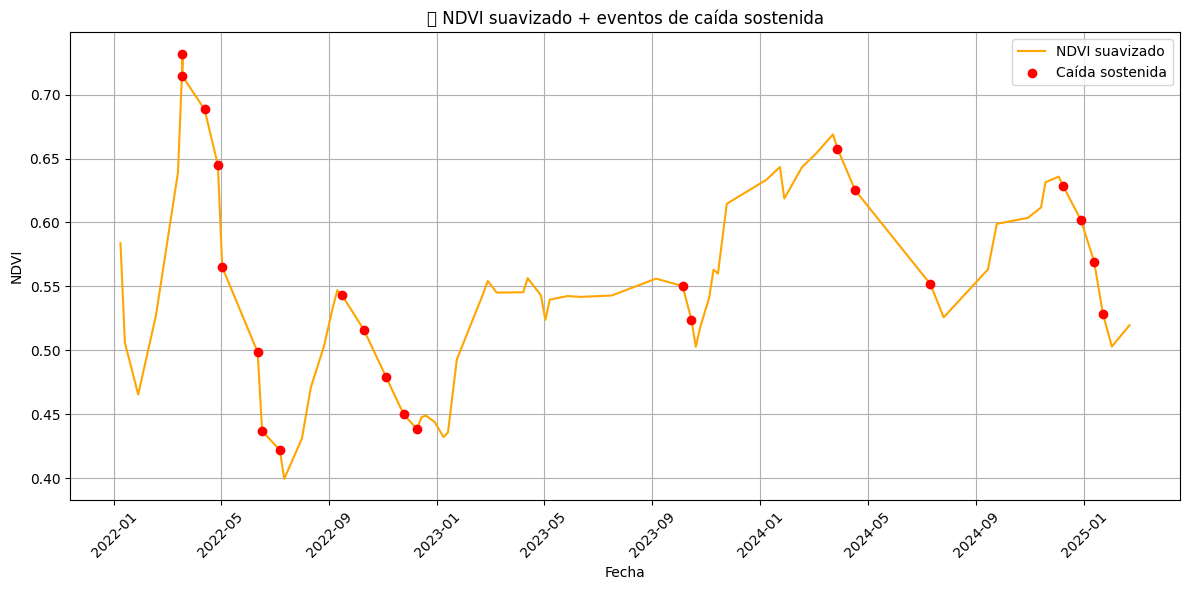

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_combinado["fecha"], df_combinado["ndvi_smooth"], label="NDVI suavizado", color="orange")

# Marcar las fechas con tendencia negativa
plt.scatter(descenso_sostenido["fecha"], descenso_sostenido["ndvi_smooth"], color="red", label="Caída sostenida", zorder=5)

plt.title("📉 NDVI suavizado + eventos de caída sostenida")
plt.xlabel("Fecha")
plt.ylabel("NDVI")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
eventos_fuertes = descenso_sostenido[descenso_sostenido["tendencia_ndvi"] < -0.03]
# Extraer pares antes-después
for i in eventos_fuertes.index:
    fecha = df_combinado.loc[i, "fecha"]
    ndvi_ini = df_combinado.loc[i - 2, "ndvi_smooth"]
    ndvi_fin = df_combinado.loc[i + 2, "ndvi_smooth"]
    print(f"{fecha} ➤ Cambio NDVI: {ndvi_ini:.3f} ➜ {ndvi_fin:.3f}  Δ = {ndvi_fin - ndvi_ini:.3f}")

2022-04-13 00:00:00 ➤ Cambio NDVI: 0.732 ➜ 0.565  Δ = -0.167
2022-04-28 00:00:00 ➤ Cambio NDVI: 0.714 ➜ 0.498  Δ = -0.216
2022-05-03 00:00:00 ➤ Cambio NDVI: 0.688 ➜ 0.437  Δ = -0.251
2022-06-12 00:00:00 ➤ Cambio NDVI: 0.645 ➜ 0.422  Δ = -0.223
2022-06-17 00:00:00 ➤ Cambio NDVI: 0.565 ➜ 0.399  Δ = -0.166
2024-04-17 00:00:00 ➤ Cambio NDVI: 0.669 ➜ 0.526  Δ = -0.143
2025-01-12 00:00:00 ➤ Cambio NDVI: 0.628 ➜ 0.503  Δ = -0.126


In [24]:
import os
carpetas = [f for f in os.listdir() if os.path.isdir(f)]
for c in carpetas:
    if "20220413" in c or "20220503" in c:
        print(c)

S2B_21HUA_20220413_0_L2A
S2B_21HUA_20220503_0_L2A


In [25]:
import os

carpeta = "S2B_21HUA_20220413_0_L2A"
archivos = os.listdir(carpeta)
for f in archivos:
    print(f)

blue.tif
green.tif
nir.tif
red.tif


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2970041021.py:20: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2970041021.py:37: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


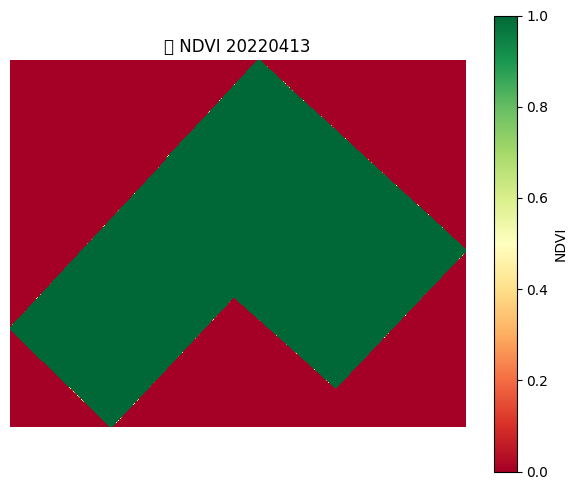

✅ Guardado: S2B_21HUA_20220413_0_L2A_20220413_ndvi_clipped.tif


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2970041021.py:20: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2970041021.py:37: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


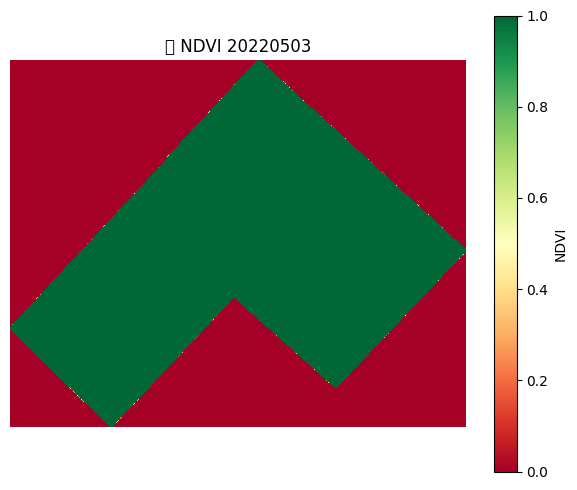

✅ Guardado: S2B_21HUA_20220503_0_L2A_20220503_ndvi_clipped.tif


In [26]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import os

# --- Cargar polígono de AOI ---
aoi = gpd.read_file("aoi_polygon.geojson")

def calcular_ndvi_y_mostrar(fecha_id, carpeta, guardar=False):
    # Usamos los nombres reales de tus archivos
    path_red = os.path.join(carpeta, "red.tif")
    path_nir = os.path.join(carpeta, "nir.tif")

    with rasterio.open(path_red) as red_src, rasterio.open(path_nir) as nir_src:
        red = red_src.read(1).astype("float32") / 10000
        nir = nir_src.read(1).astype("float32") / 10000
        ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))
        ndvi = np.clip(ndvi, -1, 1)

        # Reproyectar AOI al CRS del raster
        aoi_proj = aoi.to_crs(nir_src.crs)
        geometry = [mapping(aoi_proj.iloc[0].geometry)]

        # Recortar el NDVI al polígono
        ndvi_crop, transform = mask(nir_src, geometry, crop=True)
        ndvi_crop = ndvi_crop[0]

        # Mostrar el NDVI recortado
        plt.figure(figsize=(6, 5))
        plt.imshow(ndvi_crop, cmap="RdYlGn", vmin=0, vmax=1)
        plt.colorbar(label="NDVI")
        plt.title(f"🛰️ NDVI {fecha_id}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        # Guardar el NDVI si se solicita
        if guardar:
            out_path = f"{carpeta}_{fecha_id}_ndvi_clipped.tif"
            profile = nir_src.profile
            profile.update(dtype=rasterio.float32, count=1, compress='lzw', height=ndvi_crop.shape[0], width=ndvi_crop.shape[1], transform=transform)
            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(ndvi_crop.astype("float32"), 1)
            print(f"✅ Guardado: {out_path}")

# --- Procesar ambas fechas ---
calcular_ndvi_y_mostrar("20220413", "S2B_21HUA_20220413_0_L2A", guardar=True)
calcular_ndvi_y_mostrar("20220503", "S2B_21HUA_20220503_0_L2A", guardar=True)

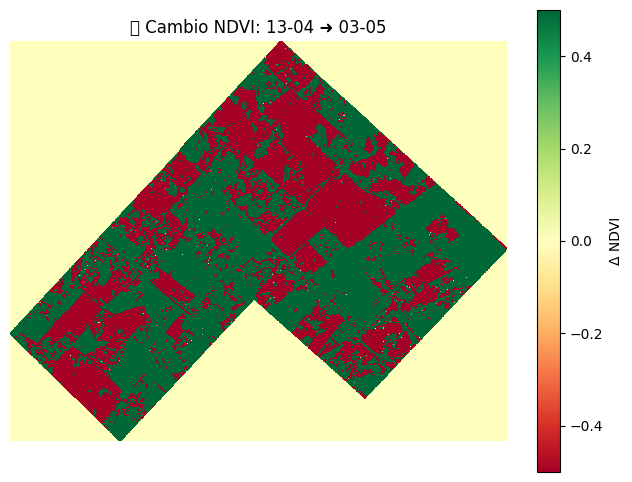

In [27]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Rutas a los NDVI procesados
ndvi_antes_path = "S2B_21HUA_20220413_0_L2A_20220413_ndvi_clipped.tif"
ndvi_despues_path = "S2B_21HUA_20220503_0_L2A_20220503_ndvi_clipped.tif"

# Leer los NDVI
with rasterio.open(ndvi_antes_path) as src_antes, rasterio.open(ndvi_despues_path) as src_despues:
    ndvi_antes = src_antes.read(1).astype("float32")
    ndvi_despues = src_despues.read(1).astype("float32")

# Calcular diferencia
diff_ndvi = ndvi_antes - ndvi_despues

# Mapa de diferencia
plt.figure(figsize=(8,6))
plt.imshow(diff_ndvi, cmap="RdYlGn", vmin=-0.5, vmax=0.5)
plt.colorbar(label="Δ NDVI")
plt.title("🛰️ Cambio NDVI: 13-04 ➜ 03-05")
plt.axis("off")
plt.show()

🌳 % del área con caída NDVI: 20.11%


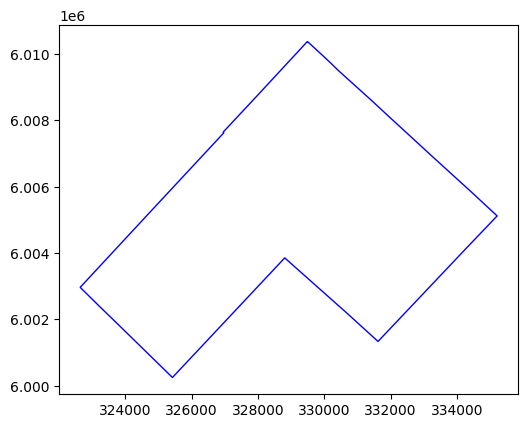

In [28]:
import geopandas as gpd

aoi = gpd.read_file("aoi_polygon.geojson").to_crs(src_antes.crs)
aoi.boundary.plot(ax=plt.gca(), edgecolor="blue", linewidth=1)

mask_def = diff_ndvi < -0.2
area_total = np.count_nonzero(~np.isnan(diff_ndvi))
area_def = np.count_nonzero(mask_def)
print(f"🌳 % del área con caída NDVI: {area_def / area_total * 100:.2f}%")

In [29]:
import rasterio.features
from shapely.geometry import shape
import geopandas as gpd

shapes = rasterio.features.shapes(mask_def.astype("uint8"), transform=src_antes.transform)
geoms = [shape(geom) for geom, val in shapes if val == 1]

gdf_def = gpd.GeoDataFrame(geometry=geoms, crs=src_antes.crs)
gdf_def.to_file("deforestacion_20220413_20220503.shp")

# Precipitaciones y datos de suelo

In [30]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import os
print(os.getcwd())

d:\sentinel_data


In [32]:
pip install pydap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
pip install netcdf4

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
pip install h5netcdf

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
pip uninstall netCDF4 h5netcdf -y


Found existing installation: netCDF4 1.7.2
Uninstalling netCDF4-1.7.2:
  Successfully uninstalled netCDF4-1.7.2
Found existing installation: h5netcdf 1.6.1
Uninstalling h5netcdf-1.6.1:
  Successfully uninstalled h5netcdf-1.6.1
Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install netCDF4 h5netcdf

  Using cached netCDF4-1.7.2-cp39-cp39-win_amd64.whl.metadata (1.8 kB)
  Using cached h5netcdf-1.6.1-py3-none-any.whl.metadata (13 kB)
Using cached netCDF4-1.7.2-cp39-cp39-win_amd64.whl (7.0 MB)
Using cached h5netcdf-1.6.1-py3-none-any.whl (49 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import xarray as xr
print(xr.backends.list_engines())

{'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html, 'h5netcdf': <H5netcdfBackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'pydap': <PydapBackendEntrypoint>
  Open remote datasets via OPeNDAP using pydap in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.PydapBackendEntrypoint.html, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarra

In [39]:
import xarray as xr
xr.backends.list_engines()

{'netcdf4': <NetCDF4BackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html,
 'h5netcdf': <H5netcdfBackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html,
 'scipy': <ScipyBackendEntrypoint>
   Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html,
 'pydap': <PydapBackendEntrypoint>
   Open remote datasets via OPeNDAP using pydap in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.PydapBackendEntrypoint.html,
 'store': <StoreBackendEntrypoint>
   Open AbstractDataStore instances in Xarray
   Learn more at https://docs.xarray.dev/en/stable/g

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1579225091.py:31: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


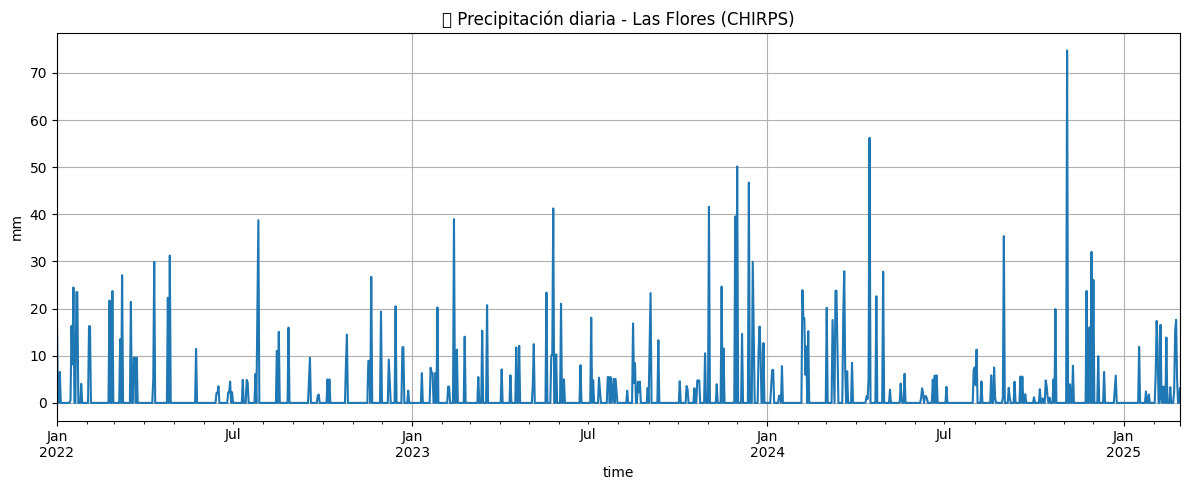

In [40]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# Coordenadas de Las Flores
lat = -36.05
lon = -59.1  # CHIRPS usa longitudes de 0 a 360

# Función para abrir y recortar un año
def cargar_recorte(file_path):
    ds = xr.open_dataset(file_path, engine="netcdf4")
    return ds['precip'].sel(latitude=lat, longitude=lon, method='nearest')

# Cargar solo el punto de interés en cada año
serie_2022 = cargar_recorte("chirps-v2.0.2022.days_p05.nc")
serie_2023 = cargar_recorte("chirps-v2.0.2023.days_p05.nc")
serie_2024 = cargar_recorte("chirps-v2.0.2024.days_p05.nc")
serie_2025 = cargar_recorte("chirps-v2.0.2025.days_p05.nc")

# Concatenar en el tiempo
serie_completa = xr.concat([serie_2022, serie_2023, serie_2024, serie_2025], dim="time")

# Convertir a pandas
serie_diaria = serie_completa.to_series()
serie_diaria.index = pd.to_datetime(serie_diaria.index)

# Graficar
serie_diaria.plot(figsize=(12,5), title="🌧️ Precipitación diaria - Las Flores (CHIRPS)")
plt.ylabel("mm")
plt.grid(True)
plt.tight_layout()
plt.show()



In [41]:
serie_completa.head()

<xarray.DataArray 'precip' (time: 5)> Size: 20B
array([19.703417,  0.      ,  0.      ,  6.567806,  0.      ],
      dtype=float32)
Coordinates:
    latitude   float32 4B -36.03
    longitude  float32 4B -59.08
  * time       (time) datetime64[ns] 40B 2022-01-01 2022-01-02 ... 2022-01-05
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [42]:
ndvi_df["ndvi_smooth"] = ndvi_df["ndvi_mean"].rolling(window=3, center=False).mean()


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1856731779.py:29: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1856731779.py:29: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IP

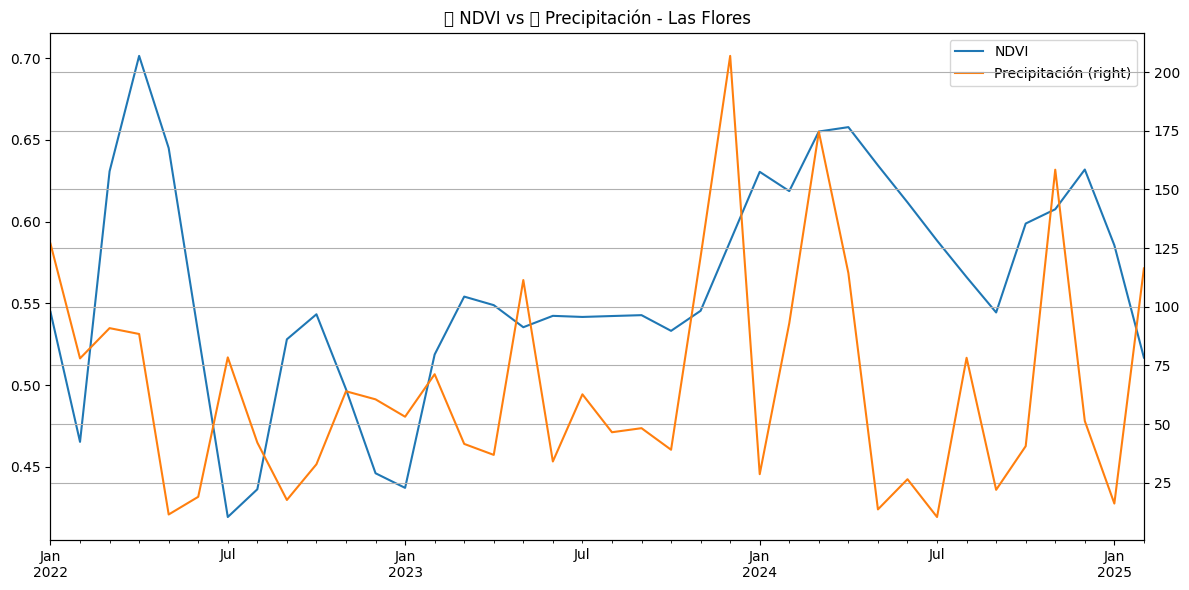

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# 🟢 Suavizado de NDVI
ndvi_df["ndvi_smooth"] = ndvi_df["ndvi_mean"].rolling(window=3, center=False).mean()

# 🟦 Conversión de precipitación a pandas Series
serie_precip = serie_completa.to_series()
serie_precip.index = pd.to_datetime(serie_precip.index)

# 📆 Agrupación mensual
precip_mensual = serie_precip.resample("M").sum()
ndvi_mensual = ndvi_df.set_index("fecha")["ndvi_smooth"].resample("M").mean()

# 🔄 Interpolación de NDVI faltantes
ndvi_mensual_interp = ndvi_mensual.interpolate(method="time")

# 📊 Combinación en un DataFrame
df_comparacion = pd.concat([ndvi_mensual_interp, precip_mensual], axis=1)
df_comparacion.columns = ["NDVI", "Precipitación"]

# 📈 Gráfico dual
df_comparacion.plot(
    secondary_y="Precipitación",
    figsize=(12,6),
    title="🌱 NDVI vs 🌧️ Precipitación - Las Flores"
)
plt.grid()
plt.tight_layout()
plt.show()

# Pasando a Google Earth Engine

In [44]:
pip install earthengine-api

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import ee
import geopandas as gpd

# Inicializar Earth Engine
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# Coordenadas del centro de Las Flores
LAS_FLORES_COORDS = [-35.9575, -59.1028]

# Crear polígono de ejemplo (o cargá tu AOI desde GeoJSON)
def crear_poligono_ejemplo(centro=LAS_FLORES_COORDS, tamano_km=2):
    delta = tamano_km / 111  # grados aproximados por km
    coords = [
        [centro[1] - delta, centro[0] - delta],
        [centro[1] + delta, centro[0] - delta],
        [centro[1] + delta, centro[0] + delta],
        [centro[1] - delta, centro[0] + delta],
        [centro[1] - delta, centro[0] - delta]
    ]
    return ee.Geometry.Polygon([coords])

# Crear polígono
aoi = crear_poligono_ejemplo()

In [46]:
import ee

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [47]:
def obtener_datos_suelo_openlandmap(poligono):
    propiedades = {
        "ph": "OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1a1a_250m_ll",
        "materia_organica": "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1a_250m_ll",
        "arcilla": "OpenLandMap/SOL/SOL_TEXTURE-CLAY_USDA-TT_M_sl1_250m_ll",
        "arena": "OpenLandMap/SOL/SOL_TEXTURE-SAND_USDA-TT_M_sl1_250m_ll",
        "limo": "OpenLandMap/SOL/SOL_TEXTURE-SILT_USDA-TT_M_sl1_250m_ll"
    }

    resultados_suelo = {}

    for prop, asset_id in propiedades.items():
        try:
            img = ee.Image(asset_id).select("b0")
            valor = img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=poligono,
                scale=250
            ).get("b0").getInfo()
            resultados_suelo[prop] = valor
        except Exception as e:
            print(f"❌ Error al obtener {prop}: {e}")
            resultados_suelo[prop] = None

    return resultados_suelo


In [48]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("D:/sentinel_data/suelo/SOTER_AR/Database/AR_SOTERv1.db")
# Mostrar tablas disponibles
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

df_suelos = pd.read_sql("SELECT * FROM RepresentativeHorizonValues", conn)
df_suelos.head()

                           name
0   RepresentativeHorizonValues
1                         Codes
2                   ClimateData
3                 SoilComponent
4             ClimateDataSource
5                ClimateStation
6                    Vegetation
7                    Laboratory
8                       Profile
9              LaboratoryMethod
10              ProfileDataBase
11         TerrainComponentData
12        FAO'88_classification
13                        Soils
14             AnalyticalMethod
15                    Sourcemap
16             TerrainComponent
17                      Terrain
18                      LandUse


PRID  HONU DIAH  DIAP HODE  HBDE  HBDI     SCMO  SCDR  STGR  ...  GYPS  \
0  AR 1.C     1   OC  None    A    10  None  10YR3/2  None  None  ...  None   
1  AR 1.C     2   OC    NI   BA    20  None  10YR3/1  None  None  ...  None   
2  AR 1.C     3   AR    NI  Bt1    33  None  10YR3/1  None  None  ...  None   
3  AR 1.C     4   AR    SO  Bt2    49  None  10YR3/1  None  None  ...  None   
4  AR 1.C     5   AR    SO  Bt3   100  None  10YR3/1  None  None  ...  None   

   TOTC TOTN P2O5  PRET  FEDE  FEPE  ALDE  ALPE  CLAY  
0  28.0  3.1  NaN  None  None  None  None  None  None  
1  28.0  2.0  NaN  None  None  None  None  None  None  
2  16.0  1.3  NaN  None  None  None  None  None  None  
3  14.0  0.8  NaN  None  None  None  None  None  None  
4  11.0  0.7  NaN  None  None  None  None  None  None  

[5 rows x 63 columns]

In [49]:
df_perfiles = pd.read_sql("SELECT * FROM Profile", conn)
df_perfiles.head()

PRID  PDID       LATI       LNGI   ELEV    SAYR  MNUM  LABO DRAI  \
0       AR 1.C  None        NaN        NaN    NaN  1987.0   8.0  AR04    M   
1    AR 1/806C  None -34.540001 -63.220001   97.0  1975.0   2.0  AR03    M   
2    AR 4/705C  None -32.980000 -61.189999   29.0  1981.0   2.0  AR03    I   
3    AR 5/720C  None -34.930000 -62.709999   96.0  1975.0   5.0  AR03    S   
4  AR A.GUIRAY  None        NaN        NaN  720.0  1986.0   4.0  AR07    W   

   INFR  ORGA  WRBC  WRBS CLAF  CLAV  PHAS  CLAN  STAX  
0  None  None  None  None  VRe  1988  None  None  EFBG  
1  None  None  None  None  SNm  1988  None  None  HBCB  
2  None  None  None  None  SNg  1988  None  None  IACE  
3  None  None  None  None  SNg  1988  None  None  IACF  
4  None  None  None  None  FRr  1988  None  None  DEEM

In [50]:
tablas_interes = [
    "RepresentativeHorizonValues",
    "SoilComponent",
    "Laboratory",
    "Profile",
    "ProfileDataBase"
]

for tabla in tablas_interes:
    try:
        df = pd.read_sql(f"SELECT * FROM {tabla} LIMIT 5", conn)
        print(f"🟩 {tabla}:")
        print(df.columns.tolist())
        print("-" * 40)
    except Exception as e:
        print(f"❌ Error al leer {tabla}: {e}")

🟩 RepresentativeHorizonValues:
['PRID', 'HONU', 'DIAH', 'DIAP', 'HODE', 'HBDE', 'HBDI', 'SCMO', 'SCDR', 'STGR', 'STSI', 'STTY', 'MINA', 'MINS', 'SDVC', 'SDCO', 'SDME', 'SDFI', 'SDVF', 'SDTO', 'STPC', 'CLPC', 'PSCL', 'BULK', 'MCT1', 'TEN2', 'MCT2', 'TEN3', 'MCT3', 'TEN4', 'MCT4', 'MCT5', 'HYDC', 'INFR', 'PHAQ', 'PHKC', 'ELCO', 'SONA', 'SOCA', 'SOMG', 'SOLK', 'SOCL', 'SSO4', 'SCO3', 'HCO3', 'EXCA', 'EXMG', 'EXNA', 'EXCK', 'EXAL', 'EXAC', 'CECS', 'TCEQ', 'GYPS', 'TOTC', 'TOTN', 'P2O5', 'PRET', 'FEDE', 'FEPE', 'ALDE', 'ALPE', 'CLAY']
----------------------------------------
🟩 SoilComponent:
['ISOC', 'SUID', 'TCID', 'SCID', 'PROP', 'PRID', 'NRPR', 'POSI', 'RKSC', 'STSC', 'ERTY', 'ERAA', 'ERDE', 'SCAP', 'RDEP', 'RELA']
----------------------------------------
🟩 Laboratory:
['LABO', 'LNAM']
----------------------------------------
🟩 Profile:
['PRID', 'PDID', 'LATI', 'LNGI', 'ELEV', 'SAYR', 'MNUM', 'LABO', 'DRAI', 'INFR', 'ORGA', 'WRBC', 'WRBS', 'CLAF', 'CLAV', 'PHAS', 'CLAN', 'STAX']
--------

In [51]:
# Cargar tablas
df_horizonte = pd.read_sql("SELECT PRID, PHAQ, PHKC, SOCA, SOMG, CLAY, STSI, STGR, STTY FROM RepresentativeHorizonValues", conn)
df_perfiles = pd.read_sql("SELECT PRID, LATI, LNGI FROM Profile", conn)

# Unir por PRID
df_suelo = pd.merge(df_horizonte, df_perfiles, on="PRID")

# Mostrar
print(df_suelo.head())

     PRID  PHAQ  PHKC  SOCA  SOMG  CLAY  STSI  STGR STTY  LATI  LNGI
0  AR 1.C   4.9   NaN   NaN   NaN  None  None  None    S   NaN   NaN
1  AR 1.C   5.9   NaN   NaN   NaN  None  None  None    A   NaN   NaN
2  AR 1.C   6.5   NaN   NaN   NaN  None  None  None    A   NaN   NaN
3  AR 1.C   7.3   NaN   NaN   NaN  None  None  None    S   NaN   NaN
4  AR 1.C   7.9   NaN   NaN   NaN  None  None  None    S   NaN   NaN


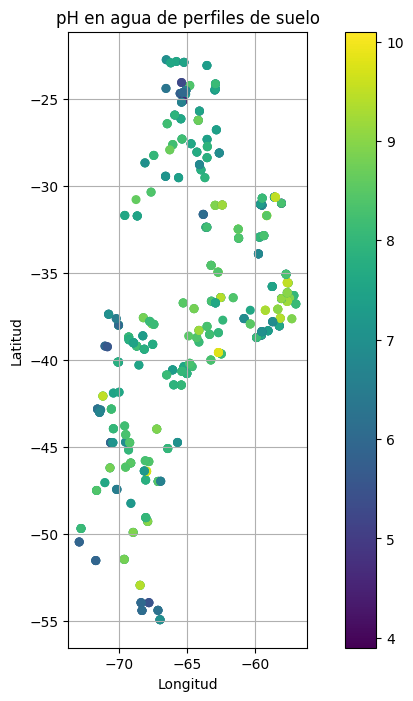

In [52]:
import sqlite3
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 1. Conexión
conn = sqlite3.connect("D:/sentinel_data/suelo/SOTER_AR/Database/AR_SOTERv1.db")

# 2. Leer datos
df_horizonte = pd.read_sql("""
    SELECT PRID, PHAQ, PHKC, SOCA, SOMG, CLAY, STSI, STGR, STTY
    FROM RepresentativeHorizonValues
""", conn)

df_perfiles = pd.read_sql("""
    SELECT PRID, LATI, LNGI FROM Profile
""", conn)

# 3. Unir tablas
df_suelo = pd.merge(df_horizonte, df_perfiles, on="PRID")

# 4. Crear geometría
geometry = [Point(xy) for xy in zip(df_suelo["LNGI"], df_suelo["LATI"])]
gdf_suelo = gpd.GeoDataFrame(df_suelo, geometry=geometry, crs="EPSG:4326")

# 5. Graficar (coloreando por pH en agua)
fig, ax = plt.subplots(figsize=(10, 8))
gdf_suelo.plot(ax=ax, column='PHAQ', cmap='viridis', legend=True, markersize=30)
plt.title("pH en agua de perfiles de suelo")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.show()

In [53]:
# Coordenadas aproximadas de Las Flores
lat_centro = -36.02
lon_centro = -59.10

# Margen alrededor
margen = 0.5

# Filtro espacial
df_las_flores = df_perfiles[
    (df_perfiles["LATI"] >= lat_centro - margen) &
    (df_perfiles["LATI"] <= lat_centro + margen) &
    (df_perfiles["LNGI"] >= lon_centro - margen) &
    (df_perfiles["LNGI"] <= lon_centro + margen)
]

print(f"Cantidad de perfiles en Las Flores: {df_las_flores.shape[0]}")

Cantidad de perfiles en Las Flores: 1


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_las_flores["PHAQ"].dropna(), bins=5, kde=True)
plt.title("Distribución de pH en agua - Perfiles de suelo en Las Flores")
plt.xlabel("pH")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

KeyError: 'PHAQ'

El pH entre 6 y 7.5 es ideal para muchos cultivos, ya que permite buena disponibilidad de nutrientes.

Esta zona no muestra suelos muy ácidos (<5.5) ni muy alcalinos (>8), al menos con esta muestra.

In [ ]:
ph_promedio = df_las_flores["PHAQ"].mean()
print(f"pH promedio en Las Flores: {ph_promedio:.2f}")

KeyError: 'PHAQ'

In [ ]:
ndvi_df["año"] = pd.to_datetime(ndvi_df["fecha"]).dt.year
ndvi_anual_las_flores = ndvi_df.groupby("año")["ndvi_smooth"].mean()
print(ndvi_anual_las_flores)

año
2022    0.519758
2023    0.526039
2024    0.617167
2025    0.544377
Name: ndvi_smooth, dtype: float64


Las Flores tiene suelos mayormente neutros a ligeramente alcalinos (pH ~7.3), y presenta un NDVI promedio relativamente alto en los últimos años.

# Analisis Mapas de Cultivo

In [55]:
import rasterio
from shapely.geometry import Polygon
import geopandas as gpd
from rasterio.mask import mask

# Coordenadas en orden lon, lat
polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230],
  [-58.88250, -36.04420], [-58.87160, -36.05250], [-58.86560, -36.05720],
  [-58.86120, -36.06060], [-58.85630, -36.06440], [-58.85090, -36.06860],
  [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810],
  [-58.88080, -36.11050], [-58.90160, -36.09490], [-58.94000, -36.12680],
  [-58.95710, -36.11270], [-58.96370, -36.10730], [-58.97030, -36.10180],
  [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]

polygon_geom = Polygon(polygon_coords)
aoi_gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom], crs="EPSG:4326")

def extraer_valores_cultivo(ruta_tif):
    with rasterio.open(ruta_tif) as src:
        aoi_proj = aoi_gdf.to_crs(src.crs)  # reproyectamos el AOI al sistema del raster
        out_image, out_transform = mask(src, aoi_proj.geometry, crop=True)
        valores = out_image[0]
        valores = valores[valores != src.nodata]  # eliminamos nodata
        return valores

In [56]:
archivos_mnc = {
    "invierno_2021": "D:/sentinel_data/MNC_invierno2021.tif",
    "invierno_2022": "D:/sentinel_data/MNC_invierno2022.tif",
    "invierno_2023": "D:/sentinel_data/MNC_invierno2023.tif",
    "verano_2021": "D:/sentinel_data/MNC_verano2021.tif",
    "verano_2022": "D:/sentinel_data/MNC_verano2022.tif",
    "verano_2023": "D:/sentinel_data/MNC_verano-2023.tif",
    "verano_2024": "D:/sentinel_data/MNC_verano-2024.tif"
}

valores_cultivo = {
    campana: extraer_valores_cultivo(ruta)
    for campana, ruta in archivos_mnc.items()
}

In [57]:
import numpy as np
# Diccionarios para campaña de invierno, verano y nodata
dicc_invierno = {
    16: "Cereales Inv (Trigo/Cebada/Avena...)",
    19: "Caña de azúcar (inv)",
    24: "Arveja",
    6:  "Garbanzo",
    26: "Papa (Primav/Verano Cuyo-NOA)",
    17: "Otros cultivos (cobertura)",
    18: "Barbecho Invierno",
    20: "No Agrícola Inv (pastizales, etc.)"
}

dicc_verano = {
    10: "Maíz",
    11: "Soja",
    12: "Girasol",
    13: "Poroto",
    14: "Caña de azúcar (ver)",
    15: "Algodón",
    16: "Maní",
    17: "Arroz",
    18: "Sorgo (grano)",
    19: "Girasol-CV",
    21: "Barbecho Verano",
    22: "No Agrícola Ver (pastizales, etc.)",
    26: "Papa (Verano BsAs)",
    28: "Verdeo de Sorgo",
    30: "Tabaco"
}

clase_nodata = {0: "Sin datos / Nubes"}

# Función genérica para obtener frecuencias
def obtener_frecuencia(valores, diccionario):
    unique, counts = np.unique(valores, return_counts=True)
    frecuencia = dict(zip([diccionario.get(v, clase_nodata.get(v, f"Clase {v} desconocida")) for v in unique], counts))
    return frecuencia

# Ejemplo de uso:
# valores_cultivo es un diccionario que debe contener los valores numéricos para cada campaña
valores_verano = valores_cultivo["verano_2023"]
frecuencia_verano = obtener_frecuencia(valores_verano, dicc_verano)
print("Frecuencia cultivos verano 2023:", frecuencia_verano)

valores_invierno = valores_cultivo["invierno_2023"]
frecuencia_invierno = obtener_frecuencia(valores_invierno, dicc_invierno)
print("Frecuencia cultivos invierno 2023:", frecuencia_invierno)

Frecuencia cultivos verano 2023: {'Sin datos / Nubes': 93304, 'Maíz': 6725, 'Soja': 4970, 'Girasol': 366, 'Barbecho Verano': 4, 'No Agrícola Ver (pastizales, etc.)': 69653, 'Clase 255 desconocida': 555}
Frecuencia cultivos invierno 2023: {'Sin datos / Nubes': 93304, 'Cereales Inv (Trigo/Cebada/Avena...)': 4299, 'Barbecho Invierno': 15529, 'No Agrícola Inv (pastizales, etc.)': 61912, 'Clase 255 desconocida': 533}


MemoryError: Unable to allocate 2.89 GiB for an array with shape (70641, 43994) and data type uint8

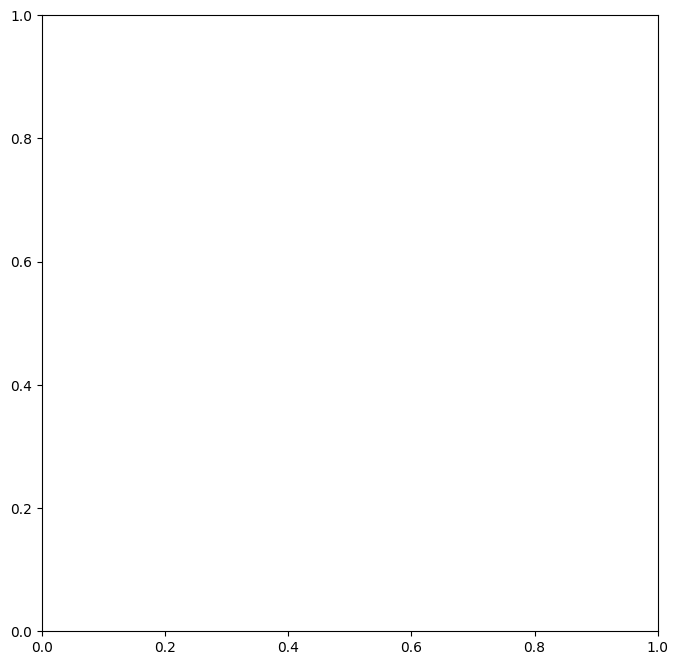

In [58]:
import rasterio
import matplotlib.pyplot as plt

def mostrar_mapa_cultivo(ruta_tif, titulo="Mapa de cultivo"):
    with rasterio.open(ruta_tif) as src:
        imagen = src.read(1)
        plt.figure(figsize=(10, 8))
        plt.imshow(imagen, cmap="viridis")
        plt.colorbar(label="Código de cultivo")
        plt.title(titulo)
        plt.axis("off")
        plt.show()

# Ejemplo
mostrar_mapa_cultivo("D:/sentinel_data/MNC_verano-2023.tif", "MNC Verano 2023")


In [ ]:
import folium
import rasterio
import numpy as np
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping

def mostrar_en_folium(ruta_tif, polygon_coords):
    # 🔁 Convertir coordenadas a polígono dentro de la función
    polygon = Polygon(polygon_coords)
    geojson = [mapping(polygon)]

    with rasterio.open(ruta_tif) as src:
        out_image, out_transform = mask(src, geojson, crop=True)

        # Solo una banda (asumo que hay una sola)
        out_image = out_image[0].astype(float)

        # Reemplazar nodata por np.nan
        out_image[out_image == src.nodata] = np.nan

        # Obtener centro para centrar el mapa
        center_lat = polygon.centroid.y
        center_lon = polygon.centroid.x

        m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        # Crear capa de imagen
        folium.raster_layers.ImageOverlay(
            image=out_image,
            bounds=[[src.bounds.bottom, src.bounds.left], [src.bounds.top, src.bounds.right]],
            opacity=0.6,
            colormap=lambda x: (x/20, x/25, x/30),  # Simple escala RGB
            name="Cultivo"
        ).add_to(m)

        folium.LayerControl().add_to(m)
        return m

# Usar la función con tu polígono
mapa = mostrar_en_folium("D:/sentinel_data/MNC_verano-2023.tif", polygon_coords)
mapa.save("mapa_verano2023.html")



In [59]:
import folium
import rasterio
import numpy as np
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import uuid

def mostrar_mapa_cultivo_png(ruta_tif, polygon_coords):
    polygon = Polygon(polygon_coords)
    geojson = [mapping(polygon)]

    with rasterio.open(ruta_tif) as src:
        out_image, out_transform = mask(src, geojson, crop=True)
        out_image = out_image[0].astype(float)
        out_image[out_image == src.nodata] = np.nan

    # 🌈 Colores fuertes para cultivos
    cmap = mcolors.ListedColormap(["#1f78b4", "#33a02c", "#ff7f00", "#6a3d9a"])  # Azulado, verde, naranja, violeta
    bounds = [0.5, 1.5, 2.5, 3.5, 256]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # 📷 Imagen temporal con UUID para evitar conflicto
    output_png = f"temp_cultivo_{uuid.uuid4().hex[:6]}.png"
    plt.figure(figsize=(4, 4), dpi=150)
    plt.axis("off")
    plt.imshow(out_image, cmap=cmap, norm=norm)
    plt.savefig(output_png, bbox_inches="tight", pad_inches=0)
    plt.close()

    # 🗺️ Crear mapa
    m = folium.Map(location=[polygon.centroid.y, polygon.centroid.x], zoom_start=12, tiles="OpenStreetMap")

    # 🌾 Imagen del cultivo
    folium.raster_layers.ImageOverlay(
        image=output_png,
        bounds=[[polygon.bounds[1], polygon.bounds[0]], [polygon.bounds[3], polygon.bounds[2]]],
        opacity=0.7,
        name="Mapa Cultivo"
    ).add_to(m)

    # 🔲 Dibujar polígono
    # GeoJSON válido
    geojson_feature = {
        "type": "Feature",
        "properties": {},
        "geometry": mapping(polygon)
    }

    folium.GeoJson(geojson_feature, name="Área de análisis", style_function=lambda x: {
        "color": "red", "weight": 2, "fillOpacity": 0
    }).add_to(m)

    folium.LayerControl().add_to(m)
    return m


In [60]:
mapa = mostrar_mapa_cultivo_png("D:/sentinel_data/MNC_verano-2023.tif", polygon_coords)
mapa.save("mapa_verano2023.html")


In [61]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
import numpy as np
import matplotlib.pyplot as plt

# Convertir las coordenadas a polígono shapely
from shapely.geometry import Polygon
polygon = Polygon(polygon_coords)
geojson = [mapping(polygon)]

# Ruta a tu archivo GeoTIFF
ruta_tif = "D:/sentinel_data/MNC_verano-2023.tif"

# Leer valores dentro del polígono
with rasterio.open(ruta_tif) as src:
    out_image, _ = mask(src, geojson, crop=True)
    cultivo_data = out_image[0]
    cultivo_data = cultivo_data.astype(float)
    cultivo_data[cultivo_data == src.nodata] = np.nan



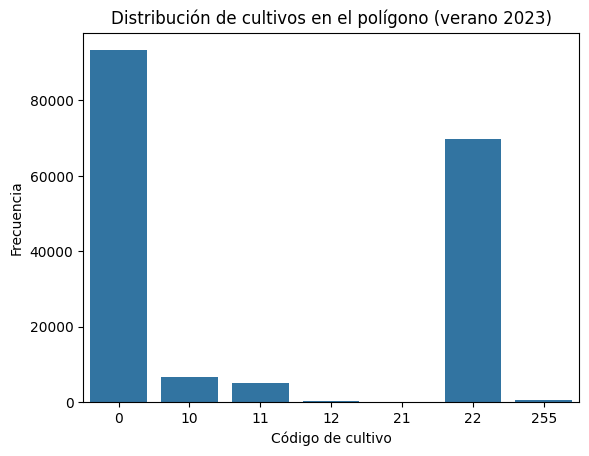

In [62]:
import seaborn as sns
import pandas as pd

# Convertir a array plano y eliminar NaNs
cultivos = cultivo_data.flatten()
cultivos = cultivos[~np.isnan(cultivos)]

# Mostrar frecuencia de valores únicos
sns.countplot(x=pd.Series(cultivos).astype(int))
plt.title("Distribución de cultivos en el polígono (verano 2023)")
plt.xlabel("Código de cultivo")
plt.ylabel("Frecuencia")
plt.show()


In [63]:
import numpy as np
import pandas as pd

# Diccionarios específicos según campaña (verano, invierno y nodata)
dicc_invierno = {
    16: "Cereales Inv (Trigo/Cebada/Avena...)",
    19: "Caña de azúcar (inv)",
    24: "Arveja",
    6:  "Garbanzo",
    26: "Papa (Primav/Verano Cuyo-NOA)",
    17: "Otros cultivos (cobertura)",
    18: "Barbecho Invierno",
    20: "No Agrícola Inv (pastizales, etc.)"
}

dicc_verano = {
    10: "Maíz",
    11: "Soja",
    12: "Girasol",
    13: "Poroto",
    14: "Caña de azúcar (ver)",
    15: "Algodón",
    16: "Maní",
    17: "Arroz",
    18: "Sorgo (grano)",
    19: "Girasol-CV",
    21: "Barbecho Verano",
    22: "No Agrícola Ver (pastizales, etc.)",
    26: "Papa (Verano BsAs)",
    28: "Verdeo de Sorgo",
    30: "Tabaco"
}

clase_nodata = {0: "Sin datos / Nubes"}

# Asumiendo que `cultivo_data` ya contiene el recorte del raster (elige la campaña adecuada)
cultivos_unicos, counts = np.unique(cultivo_data[~np.isnan(cultivo_data)], return_counts=True)
df_cultivos = pd.DataFrame({
    "Código": cultivos_unicos.astype(int),
    "Frecuencia": counts
})

# Cambia aquí el diccionario según la campaña deseada (invierno/verano)
df_cultivos["Cultivo"] = df_cultivos["Código"].map(lambda x: dicc_verano.get(x, dicc_invierno.get(x, clase_nodata.get(x, "Clase desconocida"))))

print(df_cultivos.sort_values("Frecuencia", ascending=False))


   Código  Frecuencia                             Cultivo
0       0       93304                   Sin datos / Nubes
5      22       69653  No Agrícola Ver (pastizales, etc.)
1      10        6725                                Maíz
2      11        4970                                Soja
6     255         555                   Clase desconocida
3      12         366                             Girasol
4      21           4                     Barbecho Verano


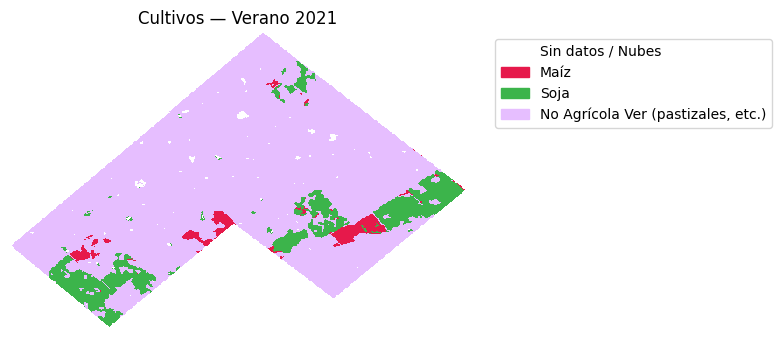

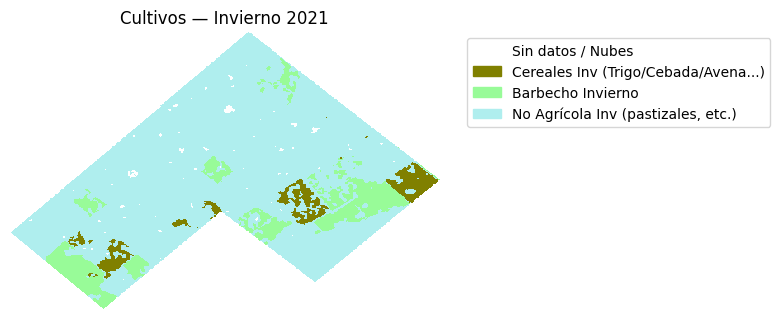

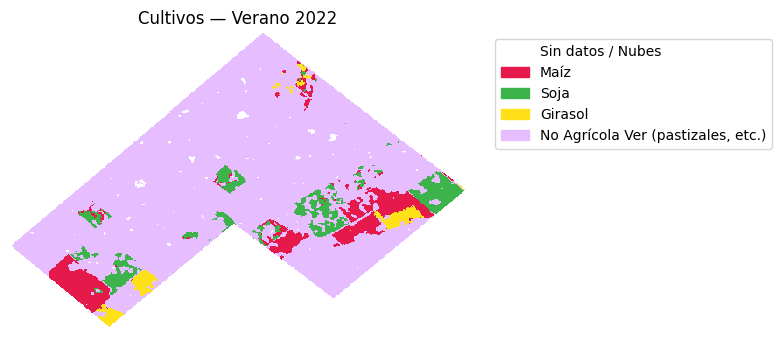

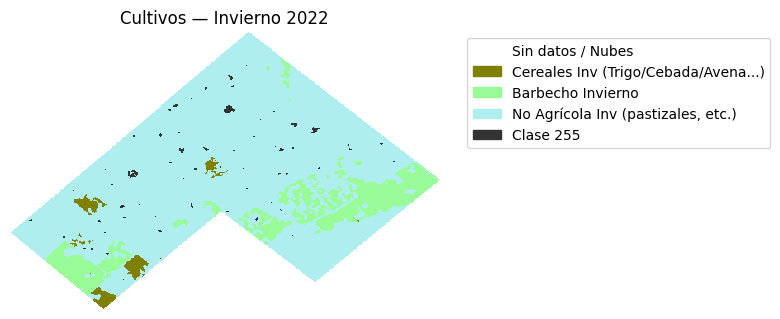

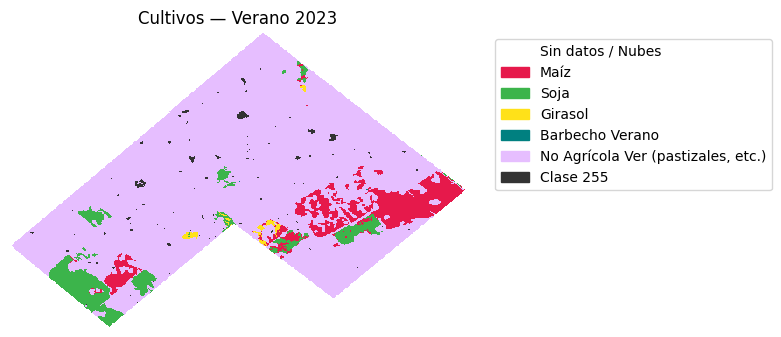

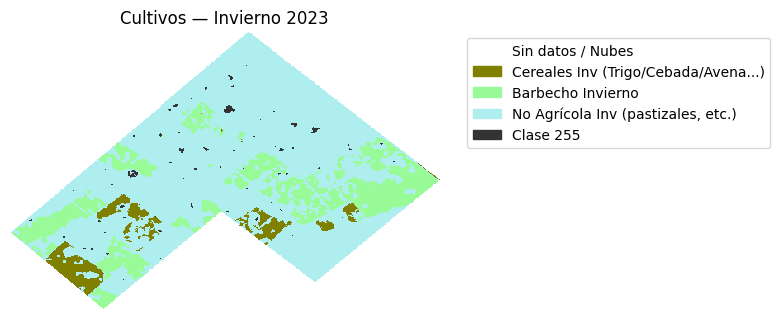

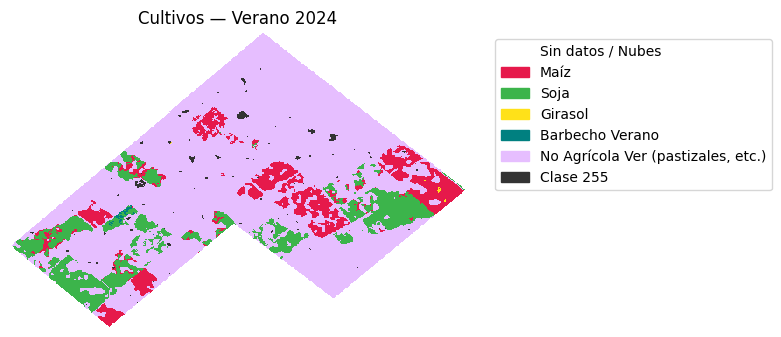

In [64]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Coordenadas del polígono
polygon_coords = [
    [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
    [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
    [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
    [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
    [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
    [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
    [-58.90920, -36.05020], [-58.89260, -36.03620]
]
polygon = Polygon(polygon_coords)
geojson = [mapping(polygon)]

# Diccionarios específicos según campaña (verano, invierno y nodata)
dicc_invierno = {
    16: "Cereales Inv (Trigo/Cebada/Avena...)",
    19: "Caña de azúcar (inv)",
    24: "Arveja",
    6:  "Garbanzo",
    26: "Papa (Primav/Verano Cuyo-NOA)",
    17: "Otros cultivos (cobertura)",
    18: "Barbecho Invierno",
    20: "No Agrícola Inv (pastizales, etc.)"
}

dicc_verano = {
    10: "Maíz",
    11: "Soja",
    12: "Girasol",
    13: "Poroto",
    14: "Caña de azúcar (ver)",
    15: "Algodón",
    16: "Maní",
    17: "Arroz",
    18: "Sorgo (grano)",
    19: "Girasol-CV",
    21: "Barbecho Verano",
    22: "No Agrícola Ver (pastizales, etc.)",
    26: "Papa (Verano BsAs)",
    28: "Verdeo de Sorgo",
    30: "Tabaco"
}

clase_nodata = {0: "Sin datos / Nubes"}

# --- 3) Diccionario de colores por clase (¡ajusta los colores que quieras!) ---
color_by_class = {
    0:  "#FFFFFF",  # blanco para nodata/nubes
    # verano
    10: "#e6194b", 11: "#3cb44b", 12: "#ffe119", 13: "#0082c8",
    14: "#f58231", 15: "#911eb4", 16: "#46f0f0", 17: "#f032e6",
    18: "#d2f53c", 19: "#fabebe", 21: "#008080", 22: "#e6beff",
    26: "#aa6e28", 28: "#800000", 30: "#aaffc3",
    # invierno
    16: "#808000", 19: "#ffd8b1", 24: "#000080", 6:  "#808080",
    26: "#000000", 17: "#ffe4e1", 18: "#98fb98", 20: "#afeeee"
}

# Archivos MNC ordenados
archivos_mnc = [
    ("Verano 2021", "D:/sentinel_data/MNC_verano2021.tif"),
    ("Invierno 2021", "D:/sentinel_data/MNC_invierno2021.tif"),
    ("Verano 2022", "D:/sentinel_data/MNC_verano2022.tif"),
    ("Invierno 2022", "D:/sentinel_data/MNC_invierno2022.tif"),
    ("Verano 2023", "D:/sentinel_data/MNC_verano-2023.tif"),
    ("Invierno 2023", "D:/sentinel_data/MNC_invierno2023.tif"),
    ("Verano 2024", "D:/sentinel_data/MNC_verano-2024.tif"),
]



for nombre, ruta in archivos_mnc:
    etiquetas = dicc_verano if "Verano" in nombre else dicc_invierno

    plt.figure(figsize=(8, 8))
    try:
        with rasterio.open(ruta) as src:
            # recortar a tu polígono
            img, tf = mask(src, geojson, crop=True)
            data = img[0]  # banda única con códigos
            nodata = src.nodata

            # 1) sustituir nodata por 0 (clase 'Sin datos')
            data = np.where(data == nodata, 0, data).astype(int)

            # 2) obtener clases presentes (incluye 0)
            clases = np.unique(data)

            # 3) construir el colormap en el orden de 'clases'
            colores = [ color_by_class.get(c, "#333333") for c in clases ]
            cmap = ListedColormap(colores)

            # 4) mapear cada pixel al índice de su clase en 'clases'
            idx = {c:i for i,c in enumerate(clases)}
            mapped = np.vectorize(lambda v: idx[v])(data)

            # 5) plot
            plt.imshow(mapped, cmap=cmap, interpolation="nearest")
            plt.title(f"Cultivos — {nombre}")
            plt.axis("off")

            # 6) leyenda
            patches = []
            for c in clases:
                label = clase_nodata.get(c) or etiquetas.get(c, f"Clase {c}")
                patches.append(mpatches.Patch(color=color_by_class.get(c,"#333333"), label=label))
            plt.legend(handles=patches, bbox_to_anchor=(1.05,1), loc="upper left")

    except Exception as e:
        plt.text(0.5,0.5, f"Error:\n{e}", ha='center', va='center')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

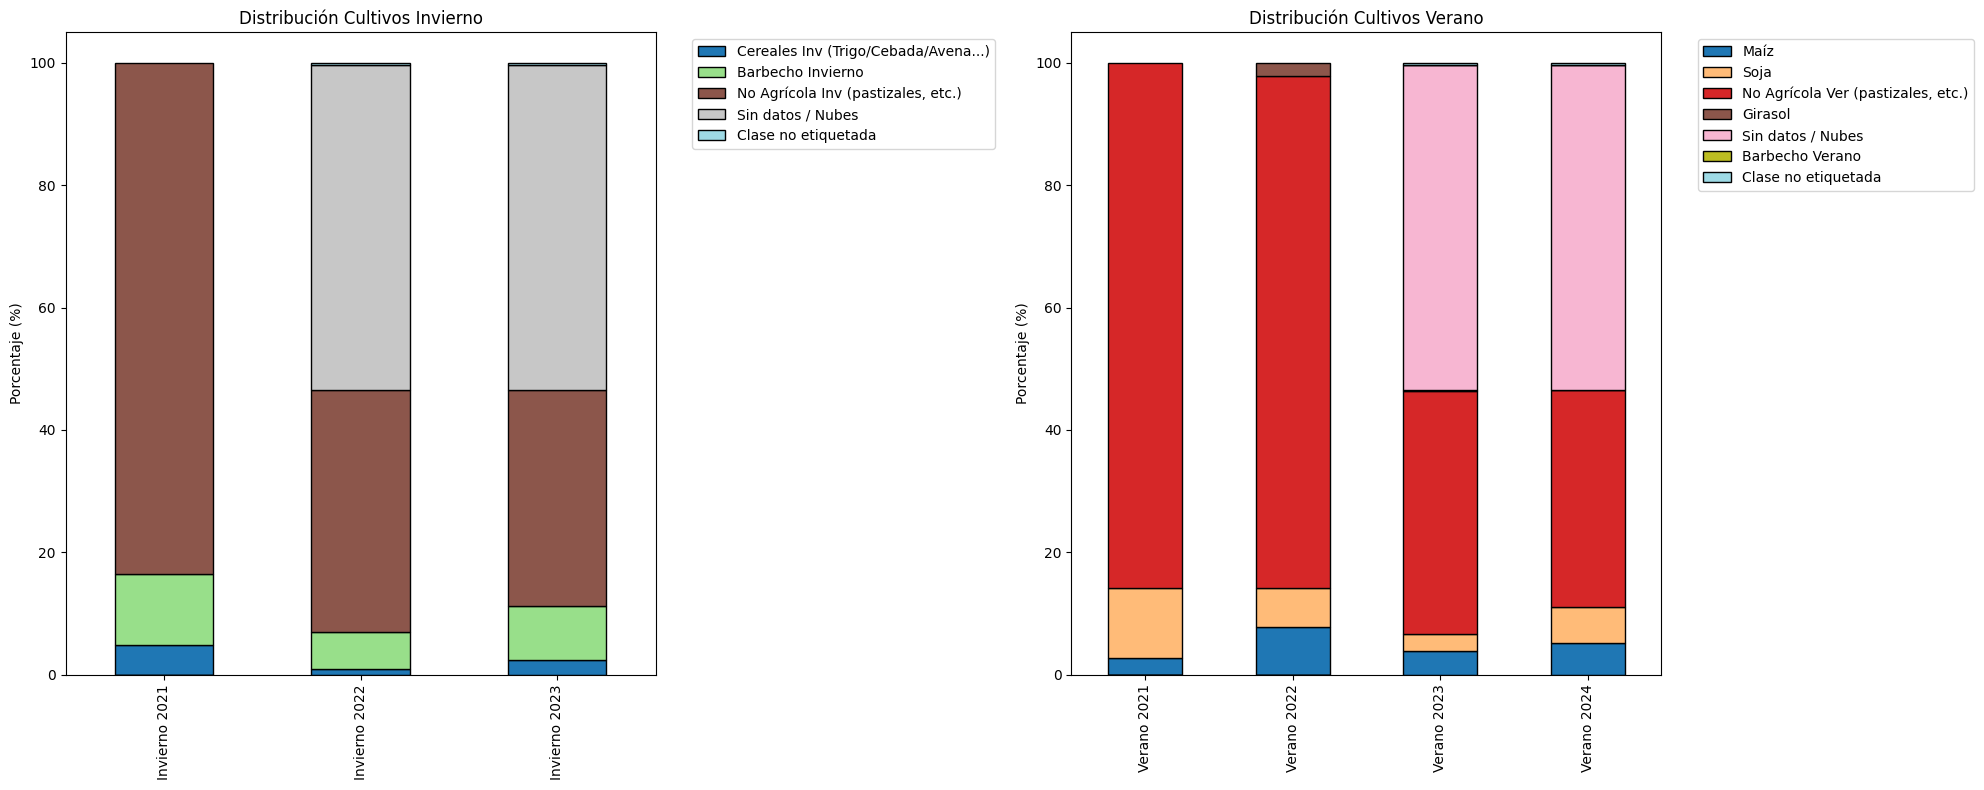

In [65]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Polígono de Las Flores
polygon_coords = [
    [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
    [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
    [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
    [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
    [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
    [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
    [-58.90920, -36.05020], [-58.89260, -36.03620]
]
polygon = Polygon(polygon_coords)
geojson = [mapping(polygon)]

# Diccionarios específicos según campaña (verano, invierno y nodata)
dicc_invierno = {
    16: "Cereales Inv (Trigo/Cebada/Avena...)",
    19: "Caña de azúcar (inv)",
    24: "Arveja",
    6:  "Garbanzo",
    26: "Papa (Primav/Verano Cuyo-NOA)",
    17: "Otros cultivos (cobertura)",
    18: "Barbecho Invierno",
    20: "No Agrícola Inv (pastizales, etc.)"
}

dicc_verano = {
    10: "Maíz",
    11: "Soja",
    12: "Girasol",
    13: "Poroto",
    14: "Caña de azúcar (ver)",
    15: "Algodón",
    16: "Maní",
    17: "Arroz",
    18: "Sorgo (grano)",
    19: "Girasol-CV",
    21: "Barbecho Verano",
    22: "No Agrícola Ver (pastizales, etc.)",
    26: "Papa (Verano BsAs)",
    28: "Verdeo de Sorgo",
    30: "Tabaco"
}

clase_nodata = {0: "Sin datos / Nubes"}

# Archivos de las campañas
archivos_mnc = {
    "Invierno 2021": "D:/sentinel_data/MNC_invierno2021.tif",
    "Invierno 2022": "D:/sentinel_data/MNC_invierno2022.tif",
    "Invierno 2023": "D:/sentinel_data/MNC_invierno2023.tif",
    "Verano 2021": "D:/sentinel_data/MNC_verano2021.tif",
    "Verano 2022":   "D:/sentinel_data/MNC_verano2022.tif",
    "Verano 2023":   "D:/sentinel_data/MNC_verano-2023.tif",
    "Verano 2024":   "D:/sentinel_data/MNC_verano-2024.tif",
}

# Procesar archivos
resultados_invierno, resultados_verano = {}, {}

for campania, ruta in archivos_mnc.items():
    cod_dict = dicc_invierno if "Invierno" in campania else dicc_verano

    with rasterio.open(ruta) as src:
        out_image, _ = mask(src, geojson, crop=True)
        banda = out_image[0].astype(float)
        banda[banda == src.nodata] = np.nan
        valores, counts = np.unique(banda[~np.isnan(banda)].astype(int), return_counts=True)
        total = counts.sum()
        
        porcentajes = {}
        for v, c in zip(valores, counts):
            if v in cod_dict:
                label = cod_dict[v]
            elif v == 0:
                label = clase_nodata[0]
            else:
                label = "Clase no etiquetada"
            porcentajes[label] = porcentajes.get(label, 0) + (c / total) * 100

        if "Invierno" in campania:
            resultados_invierno[campania] = porcentajes
        else:
            resultados_verano[campania] = porcentajes

# Convertir a DataFrames
df_invierno = pd.DataFrame(resultados_invierno).fillna(0)
df_verano = pd.DataFrame(resultados_verano).fillna(0)

# Gráficos separados
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_invierno.T.plot(kind='bar', stacked=True, ax=axs[0], colormap='tab20', edgecolor='black')
axs[0].set_title("Distribución Cultivos Invierno")
axs[0].set_ylabel("Porcentaje (%)")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

df_verano.T.plot(kind='bar', stacked=True, ax=axs[1], colormap='tab20', edgecolor='black')
axs[1].set_title("Distribución Cultivos Verano")
axs[1].set_ylabel("Porcentaje (%)")
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Temperatura

In [66]:
from shapely.geometry import mapping

# Suponiendo que `polygon_shapely` es tu polígono
polygon_gee = ee.Geometry.Polygon(mapping(polygon_shapely)['coordinates'])
polygon_gee_grande = polygon_gee.buffer(10000)

In [67]:
def obtener_temperatura_era5land(poligono, fecha_inicio, fecha_fin):
    era5 = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
            .filterDate(fecha_inicio, fecha_fin)
            .filterBounds(poligono)
            .select('temperature_2m'))

    def extraer_temp(img):
        media = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=poligono,
            scale=1000,
            maxPixels=1e13
        )
        return ee.Feature(None, {
            'temperatura': media.get('temperature_2m'),
            'fecha': img.date().format('YYYY-MM-dd')
        })

    features = era5.map(extraer_temp)
    return features


# Llamar a la función
fc = obtener_temperatura_era5land(polygon_gee, '2022-01-01', '2025-04-30')

# Traer a Python
datos = fc.getInfo()

# Armar el DataFrame
fechas = [f['properties']['fecha'] for f in datos['features']]
temps = [f['properties']['temperatura'] for f in datos['features']]
df_temp = pd.DataFrame({'fecha': fechas, 'temperatura': temps})
df_temp['fecha'] = pd.to_datetime(df_temp['fecha'])
df_temp['temperatura'] = df_temp['temperatura'] - 273.15  # Kelvin → °C

print(df_temp.head())

       fecha  temperatura
0 2022-01-01    26.346166
1 2022-01-02    27.030340
2 2022-01-03    27.916330
3 2022-01-04    28.119169
4 2022-01-05    20.720369


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2232622471.py:41: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2232622471.py:41: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2232622471.py:41: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783

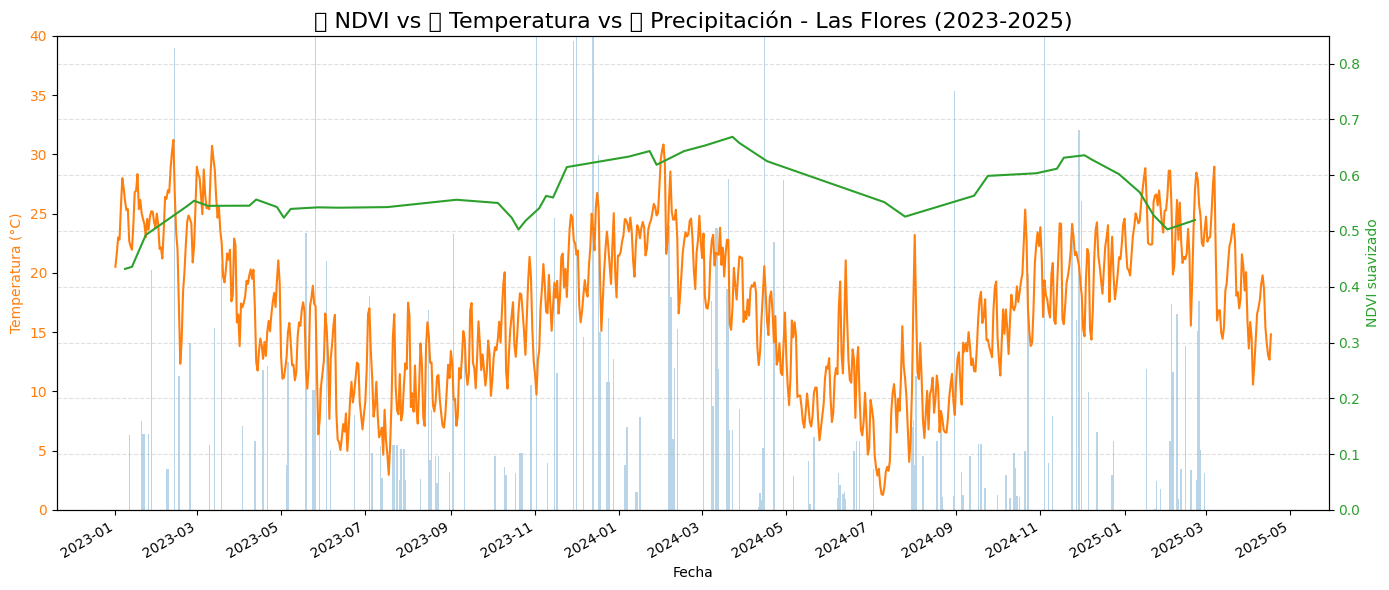

In [68]:
import matplotlib.dates as mdates
import seaborn as sns

# Definir el rango
inicio = "2023-01-01"
fin = "2025-04-30"

# Filtrar cada dataset
df_temp_recorte = df_temp[(df_temp['fecha'] >= inicio) & (df_temp['fecha'] <= fin)]
df_ndvi_recorte = df_combinado[(df_combinado['fecha'] >= inicio) & (df_combinado['fecha'] <= fin)]
serie_precip_recorte = serie_diaria[inicio:fin]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Temperatura
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Temperatura (°C)", color="tab:orange")
ax1.plot(df_temp_recorte['fecha'], df_temp_recorte['temperatura'], color="tab:orange")
ax1.tick_params(axis='y', labelcolor="tab:orange")
ax1.set_ylim(0, 40)  # 🔶 Limite eje izquierdo

# Precipitación (como barras)
ax1.bar(serie_precip_recorte.index, serie_precip_recorte.values, width=1.0,
        color='tab:blue', alpha=0.3, label='Precipitación (mm)')

# NDVI
ax2 = ax1.twinx()
ax2.set_ylabel("NDVI suavizado", color="tab:green")
ax2.plot(df_ndvi_recorte['fecha'], df_ndvi_recorte['ndvi_smooth'], color="tab:green")
ax2.tick_params(axis='y', labelcolor="tab:green")
ax2.set_ylim(0, 0.85)  # 🟢 Limite eje derecho

# Eje X con formato fecha
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
fig.autofmt_xdate()

# Estética
plt.title("🌿 NDVI vs 🌡️ Temperatura vs 🌧️ Precipitación - Las Flores (2023-2025)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Datos de Suelo

In [69]:
def obtener_propiedades_suelo_openlandmap(polygon_gee):
    propiedades = {
        "carbono": "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02",
        "arcilla": "OpenLandMap/SOL/SOL_CLAY-USDA_TEX_GLOBAL/v02",
        "arena":   "OpenLandMap/SOL/SOL_SAND-USDA_TEX_GLOBAL/v02",
        "limo":    "OpenLandMap/SOL/SOL_SILT-USDA_TEX_GLOBAL/v02"
    }

    bandas = ["b0", "b10", "b30", "b60", "b100", "b200"]
    etiquetas = ["0–5 cm", "5–15 cm", "15–30 cm", "30–60 cm", "60–100 cm", "100–200 cm"]

    resultados = {}

    for nombre, asset in propiedades.items():
        img = ee.Image(asset)
        valores = img.select(bandas).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=polygon_gee,
            scale=250,
            maxPixels=1e13
        )
        resultados[nombre] = [valores.get(b) for b in bandas]

    return pd.DataFrame(resultados, index=etiquetas)

In [70]:
df_suelo = obtener_propiedades_suelo_openlandmap(polygon_gee)
print(df_suelo.round(2))


                                                      carbono  \
0–5 cm      ee.ComputedObject({\n  "functionInvocationValu...   
5–15 cm     ee.ComputedObject({\n  "functionInvocationValu...   
15–30 cm    ee.ComputedObject({\n  "functionInvocationValu...   
30–60 cm    ee.ComputedObject({\n  "functionInvocationValu...   
60–100 cm   ee.ComputedObject({\n  "functionInvocationValu...   
100–200 cm  ee.ComputedObject({\n  "functionInvocationValu...   

                                                      arcilla  \
0–5 cm      ee.ComputedObject({\n  "functionInvocationValu...   
5–15 cm     ee.ComputedObject({\n  "functionInvocationValu...   
15–30 cm    ee.ComputedObject({\n  "functionInvocationValu...   
30–60 cm    ee.ComputedObject({\n  "functionInvocationValu...   
60–100 cm   ee.ComputedObject({\n  "functionInvocationValu...   
100–200 cm  ee.ComputedObject({\n  "functionInvocationValu...   

                                                        arena  \
0–5 cm      ee.Computed

In [71]:
# --- 5. Función para obtener propiedades del suelo desde SoilGrids v0.5 ---
def obtener_propiedades_suelo_soilgrids05(poligono):
    props = {
        "clay": "clay_mean",
        "sand": "sand_mean",
        "silt": "silt_mean",
        "ocd": "ocd_mean"  # materia orgánica
    }
    resultados = {}
    for nombre, banda in props.items():
        try:
            imagen = ee.Image(f"projects/soilgrids-isric/{banda}")
            media = imagen.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=poligono,
                scale=250,
                bestEffort=True
            )
            resultados[nombre] = media.getInfo()
        except Exception as e:
            print(f"Error con {nombre}: {e}")
            resultados[nombre] = {}
    return resultados

In [72]:
df_suelo = obtener_propiedades_suelo_soilgrids05(polygon_gee)
print(df_suelo)

{'clay': {'clay_0-5cm_mean': 257.9037121401444, 'clay_100-200cm_mean': 285.47102105362364, 'clay_15-30cm_mean': 306.8372410289606, 'clay_30-60cm_mean': 346.7924011946366, 'clay_5-15cm_mean': 257.1629842968399, 'clay_60-100cm_mean': 323.5905297614412}, 'sand': {'sand_0-5cm_mean': 431.3747905494259, 'sand_100-200cm_mean': 413.35616225096373, 'sand_15-30cm_mean': 406.234220024499, 'sand_30-60cm_mean': 384.06370574908533, 'sand_5-15cm_mean': 434.18604536832567, 'sand_60-100cm_mean': 391.7880257772712}, 'silt': {'silt_0-5cm_mean': 310.7425263528765, 'silt_100-200cm_mean': 301.2021500178213, 'silt_15-30cm_mean': 286.91793224658045, 'silt_30-60cm_mean': 269.145400690726, 'silt_5-15cm_mean': 308.63233793953884, 'silt_60-100cm_mean': 284.62899902085695}, 'ocd': {'ocd_0-5cm_mean': 398.84476691070097, 'ocd_100-200cm_mean': 131.42248177933644, 'ocd_15-30cm_mean': 203.85606187856163, 'ocd_30-60cm_mean': 92.25536377826303, 'ocd_5-15cm_mean': 313.27419691836246, 'ocd_60-100cm_mean': 69.5823483864624}

<Figure size 1000x600 with 0 Axes>

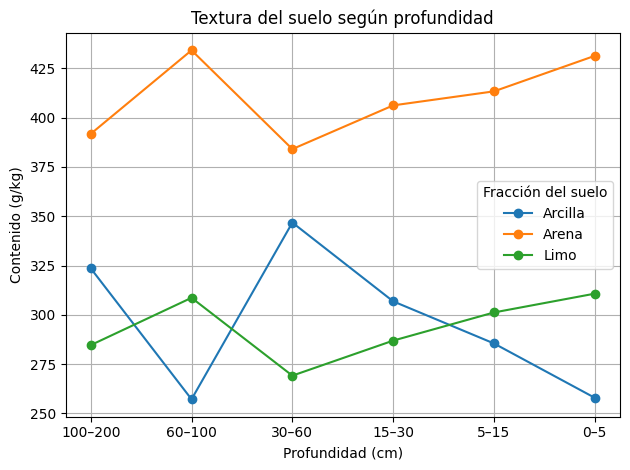

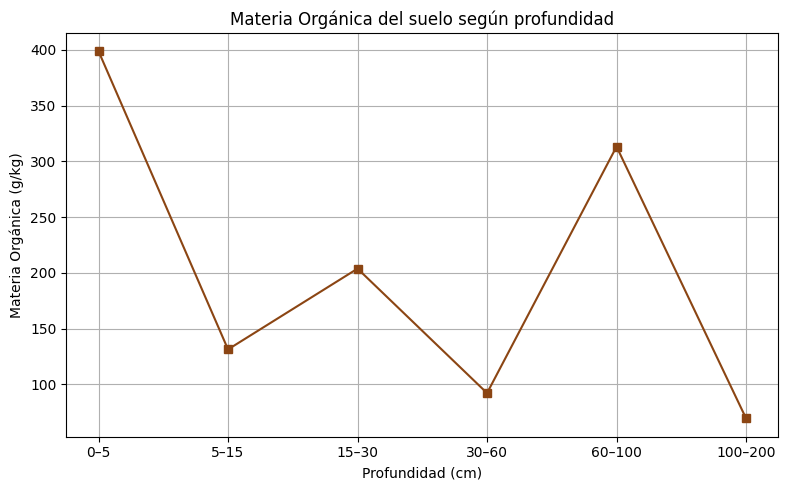

In [73]:
# Profundidades (como etiquetas)
prof_labels = ["0–5", "5–15", "15–30", "30–60", "60–100", "100–200"]

# Armar DataFrame
df = pd.DataFrame({
    "Arcilla": list(df_suelo['clay'].values()),
    "Arena": list(df_suelo['sand'].values()),
    "Limo": list(df_suelo['silt'].values()),
    "Materia Orgánica": list(df_suelo['ocd'].values())
}, index=prof_labels)

# Graficar
plt.figure(figsize=(10, 6))
df[["Arcilla", "Arena", "Limo"]].plot(marker='o')
plt.gca().invert_xaxis()
plt.title("Textura del suelo según profundidad")
plt.xlabel("Profundidad (cm)")
plt.ylabel("Contenido (g/kg)")
plt.grid(True)
plt.legend(title="Fracción del suelo")
plt.tight_layout()
plt.show()

# Gráfico separado para materia orgánica
plt.figure(figsize=(8, 5))
df["Materia Orgánica"].plot(marker='s', color='saddlebrown')
plt.title("Materia Orgánica del suelo según profundidad")
plt.xlabel("Profundidad (cm)")
plt.ylabel("Materia Orgánica (g/kg)")
plt.grid(True)
plt.tight_layout()
plt.show()

El valor en superficie es alto (>300 g/kg), lo cual es excelente.

Disminuye fuertemente con la profundidad, como es esperable.
Esto indica que hay un buen nivel de actividad biológica en superficie.

Fracción	Significado	Implicancias prácticas
Arcilla	Partículas muy finas (< 0.002 mm)	Alta retención de agua y nutrientes, pero poca aireación
Arena	Partículas grandes (> 0.05 mm)	Buena aireación y drenaje, baja capacidad de retención de agua/nutrientes
Limo	Tamaño intermedio	Favorece estructura y retención moderada de agua

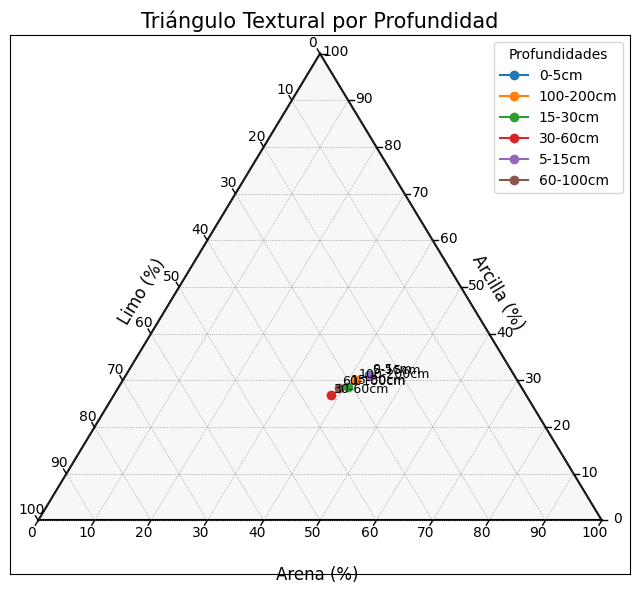

In [75]:
import ternary
import matplotlib.pyplot as plt

def normalizar_textura(dic):
    perfiles = []
    etiquetas = []
    
    # Extraer las profundidades comunes (desde las claves)
    profundidades = sorted(set([k.split("_")[1] for k in dic["clay"].keys()]))

    for prof in profundidades:
        try:
            clay = dic["clay"][f"clay_{prof}_mean"] / 10
            sand = dic["sand"][f"sand_{prof}_mean"] / 10
            silt = dic["silt"][f"silt_{prof}_mean"] / 10
            total = clay + sand + silt
            clay_p = (clay / total) * 100
            sand_p = (sand / total) * 100
            silt_p = (silt / total) * 100
            perfiles.append((sand_p, silt_p, clay_p))  # Orden: (arena, limo, arcilla)
            etiquetas.append(prof)
        except KeyError:
            print(f"❌ No se encontró alguna capa para {prof}")
            continue

    return perfiles, etiquetas

# --- Preparar los datos ---
perfiles, etiquetas = normalizar_textura(df_suelo)

# --- Gráfico ternario ---
fig, tax = ternary.figure(scale=100)
fig.set_size_inches(8, 7)
tax.set_title("Triángulo Textural por Profundidad", fontsize=15)
tax.boundary(linewidth=1.5)
tax.gridlines(color="gray", multiple=10)
tax.left_axis_label("Limo (%)", fontsize=12)
tax.right_axis_label("Arcilla (%)", fontsize=12)
tax.bottom_axis_label("Arena (%)", fontsize=12)

# --- Puntos y etiquetas ---
for punto, label in zip(perfiles, etiquetas):
    tax.plot([punto], marker='o', label=label)
    tax.annotate(label, punto, fontsize=9, xytext=(2, 2), textcoords='offset points')  # corregido

tax.legend(title="Profundidades")
tax.ticks(axis='lbr', multiple=10, linewidth=1)
tax.clear_matplotlib_ticks()
tax.show()


Todos los puntos están agrupados en la zona baja del triángulo, hacia la izquierda, lo que indica:

📉 Poca arena (entre 4% y 6%)

🧪 Mucho limo (50–60%)

🪨 Moderada arcilla (entre 39% y 49%)

Esto sugiere un suelo limoso a franco-limoso, que típicamente:

Tiene buena retención de agua

Buena fertilidad natural

Pero puede compactarse fácilmente y tener problemas de drenaje si no se maneja bien

📘 ¿Cómo interpretarlo a nivel agronómico?

Tipo de Suelo Estimado	Características agronómicas
Franco limoso	✅ Fertilidad media-alta, buena retención de agua, pero cuidado con compactación.
Profundidades mayores (100–200cm)	Suelen tener más arcilla → más densidad, menor drenaje.
Profundidades superficiales (0–5cm, 5–15cm)	Menos arcilla y más limo → mejores para siembra directa y desarrollo radicular inicial.

La textura del suelo y su evolución con la profundidad puede darte pistas de:


Indicador	¿Qué sugiere?
Suelos poco compactados y con buena cobertura superficial	Compatible con siembra directa
Contenido de materia orgánica alto en superficie	Compatible con sistemas conservacionistas (como SD)
Alta variabilidad de NDVI + cobertura vegetal persistente	Indicio de cultivos continuos, cobertura permanente

# INDICE DE SUELO DESNUDO (PARA SIEMBRA DIRECTA)

In [79]:
os.path.exists("D:/sentinel_data")

True

In [85]:
import os
import re
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, Polygon

# 1) Parámetros
base_path  = r"D:/sentinel_data"
start_date = datetime.strptime("2022-01-01", "%Y-%m-%d")
end_date   = datetime.strptime("2025-04-01", "%Y-%m-%d")

# 2) Tu AOI
polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi = gpd.GeoDataFrame({'geometry':[Polygon(polygon_coords)]}, crs="EPSG:4326")

# 3) Listar carpetas L2A
scene_dirs = [
    os.path.join(base_path, d)
    for d in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, d)) and "L2A" in d
]

# 4) Extraer fecha de carpeta y filtrar
scenes = []
for sd in scene_dirs:
    m = re.search(r"(\d{8})", sd)
    if not m: 
        continue
    dt = datetime.strptime(m.group(1), "%Y%m%d")
    if start_date <= dt <= end_date:
        scenes.append((dt, sd))
scenes_sorted = sorted(scenes, key=lambda x: x[0])

# 5) Helper para encontrar banda
def find_band(root, patterns):
    for dirpath, _, files in os.walk(root):
        for f in files:
            low = f.lower()
            if any(p in low for p in patterns) and f.endswith(".tif"):
                return os.path.join(dirpath, f)
    return None

ndti_records = []
for dt, scene_dir in scenes_sorted:
    date_str = dt.strftime("%Y-%m-%d")
    print(f"Procesando {os.path.basename(scene_dir)} ({date_str})")

    # buscar los archivos rojo/verde
    red_fp   = find_band(scene_dir, ["red", "b04"])
    green_fp = find_band(scene_dir, ["green", "b03"])
    if not red_fp or not green_fp:
        print("  ⚠️ No hallé red/green → salto")
        continue

    try:
        # abrimos sólo para recortar
        with rasterio.open(red_fp)   as src_r, \
             rasterio.open(green_fp) as src_g:

            # 1) recorte de cada banda al AOI
            aoi_proj = aoi.to_crs(src_r.crs)
            geom     = [mapping(aoi_proj.geometry.iloc[0])]
            red_crop, _   = mask(src_r, geom, crop=True)
            green_crop, _ = mask(src_g, geom, crop=True)

            # 2) convertir y normalizar
            red_arr   = red_crop[0].astype("float32") / 10000
            green_arr = green_crop[0].astype("float32") / 10000

            # 3) calcular NDTI en la ventana recortada
            sum_ =   red_arr + green_arr
            diff =   red_arr - green_arr
            # donde sum_==0 ponemos NaN para no distorsionar
            ndti_crop = np.where(sum_==0, np.nan, diff / sum_)
            ndti_crop = np.clip(ndti_crop, -1, 1)

            # 4) media
            valid = ndti_crop[~np.isnan(ndti_crop)]
            mean_ndti = float(np.nanmean(valid)) if valid.size else np.nan

            ndti_records.append((date_str, mean_ndti))
            print(f"  ➡️ NDTI medio = {mean_ndti:.4f}")

    except Exception as e:
        print(f"  ❌ Error en {scene_dir}: {e}")

# 7) DataFrame final
ndti_df = (
    pd.DataFrame(ndti_records, columns=["fecha","ndti_mean"])
      .assign(fecha=lambda df: pd.to_datetime(df["fecha"]))
      .sort_values("fecha")
      .reset_index(drop=True)
)

print("\n✅ Resultados:")
print(ndti_df)


Procesando S2B_21HUA_20220103_0_L2A (2022-01-03)
  ➡️ NDTI medio = -0.0769
Procesando S2A_21HUA_20220108_0_L2A (2022-01-08)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0370
Procesando S2B_21HUA_20220113_0_L2A (2022-01-13)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0056
Procesando S2A_21HUA_20220128_0_L2A (2022-01-28)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0279
Procesando S2A_21HUA_20220217_0_L2A (2022-02-17)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0464
Procesando S2B_21HUA_20220314_0_L2A (2022-03-14)
  ➡️ NDTI medio = -0.1547
Procesando S2A_21HUA_20220319_0_L2A (2022-03-19)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.1609
Procesando S2A_21HUA_20220319_1_L2A (2022-03-19)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.1610
Procesando S2B_21HUA_20220413_0_L2A (2022-04-13)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0824
Procesando S2A_21HUA_20220428_0_L2A (2022-04-28)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0228
Procesando S2B_21HUA_20220503_0_L2A (2022-05-03)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0187
Procesando S2B_21HUA_20220612_0_L2A (2022-06-12)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.1132
Procesando S2A_21HUA_20220617_0_L2A (2022-06-17)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.1533
Procesando S2A_21HUA_20220707_0_L2A (2022-07-07)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.1737
Procesando S2B_21HUA_20220712_0_L2A (2022-07-12)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.1614
Procesando S2A_21HUA_20220717_0_L2A (2022-07-17)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.1487
Procesando S2B_21HUA_20220801_0_L2A (2022-08-01)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.1136
Procesando S2B_21HUA_20220811_0_L2A (2022-08-11)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0662
Procesando S2A_21HUA_20220826_0_L2A (2022-08-26)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0260
Procesando S2A_21HUA_20220905_0_L2A (2022-09-05)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0196
Procesando S2B_21HUA_20220910_0_L2A (2022-09-10)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0040
Procesando S2A_21HUA_20220915_0_L2A (2022-09-15)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0041
Procesando S2B_21HUA_20221010_0_L2A (2022-10-10)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0083
Procesando S2A_21HUA_20221104_0_L2A (2022-11-04)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0426
Procesando S2A_21HUA_20221124_0_L2A (2022-11-24)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0483
Procesando S2B_21HUA_20221209_0_L2A (2022-12-09)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0508
Procesando S2A_21HUA_20221214_0_L2A (2022-12-14)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0285
Procesando S2B_21HUA_20221219_0_L2A (2022-12-19)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0303
Procesando S2B_21HUA_20221229_0_L2A (2022-12-29)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0515
Procesando S2B_21HUA_20230108_0_L2A (2023-01-08)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0518
Procesando S2A_21HUA_20230113_0_L2A (2023-01-13)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0620
Procesando S2A_21HUA_20230123_0_L2A (2023-01-23)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0364
Procesando S2A_21HUA_20230222_0_L2A (2023-02-22)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0392
Procesando S2B_21HUA_20230227_0_L2A (2023-02-27)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0235
Procesando S2B_21HUA_20230309_0_L2A (2023-03-09)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0449
Procesando S2B_21HUA_20230408_1_L2A (2023-04-08)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0127
Procesando S2A_21HUA_20230413_0_L2A (2023-04-13)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0015
Procesando S2B_21HUA_20230428_0_L2A (2023-04-28)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0247
Procesando S2A_21HUA_20230503_0_L2A (2023-05-03)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0536
Procesando S2B_21HUA_20230508_0_L2A (2023-05-08)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0341
Procesando S2B_21HUA_20230528_0_L2A (2023-05-28)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0233
Procesando S2A_21HUA_20230612_0_L2A (2023-06-12)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0135
Procesando S2B_21HUA_20230717_0_L2A (2023-07-17)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0436
Procesando S2B_21HUA_20230905_0_L2A (2023-09-05)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0023
Procesando S2B_21HUA_20231005_0_L2A (2023-10-05)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0261
Procesando S2B_21HUA_20231015_0_L2A (2023-10-15)
  ➡️ NDTI medio = 0.0109
Procesando S2A_21HUA_20231020_0_L2A (2023-10-20)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0404
Procesando S2B_21HUA_20231025_0_L2A (2023-10-25)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0177
Procesando S2B_21HUA_20231104_0_L2A (2023-11-04)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0040
Procesando S2A_21HUA_20231109_0_L2A (2023-11-09)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0125
Procesando S2B_21HUA_20231114_0_L2A (2023-11-14)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0286
Procesando S2B_21HUA_20231124_0_L2A (2023-11-24)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0225
Procesando S2A_21HUA_20240108_0_L2A (2024-01-08)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.1922
Procesando S2B_21HUA_20240123_0_L2A (2024-01-23)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0691
Procesando S2A_21HUA_20240128_0_L2A (2024-01-28)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0258
Procesando S2A_21HUA_20240217_0_L2A (2024-02-17)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.1172
Procesando S2B_21HUA_20240303_0_L2A (2024-03-03)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.1411
Procesando S2B_21HUA_20240323_0_L2A (2024-03-23)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0885
Procesando S2A_21HUA_20240328_0_L2A (2024-03-28)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.1471
Procesando S2A_21HUA_20240417_0_L2A (2024-04-17)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.1062
Procesando S2B_21HUA_20240711_0_L2A (2024-07-11)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0690
Procesando S2A_21HUA_20240726_0_L2A (2024-07-26)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0929
Procesando S2A_21HUA_20240914_0_L2A (2024-09-14)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0432
Procesando S2A_21HUA_20240924_0_L2A (2024-09-24)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0816
Procesando S2B_21HUA_20241029_0_L2A (2024-10-29)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0618
Procesando S2A_21HUA_20241113_0_L2A (2024-11-13)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0843
Procesando S2B_21HUA_20241118_0_L2A (2024-11-18)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0994
Procesando S2A_21HUA_20241203_0_L2A (2024-12-03)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0653
Procesando S2B_21HUA_20241208_0_L2A (2024-12-08)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0716
Procesando S2B_21HUA_20241228_0_L2A (2024-12-28)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = -0.0625
Procesando S2A_21HUA_20250112_0_L2A (2025-01-12)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0093
Procesando S2C_21HUA_20250122_0_L2A (2025-01-22)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0228
Procesando S2C_21HUA_20250201_0_L2A (2025-02-01)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0454
Procesando S2C_21HUA_20250221_0_L2A (2025-02-21)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


  ➡️ NDTI medio = 0.0421
Procesando S2B_21HUA_20250226_0_L2A (2025-02-26)
  ➡️ NDTI medio = -0.0498

✅ Resultados:
        fecha  ndti_mean
0  2022-01-03  -0.076931
1  2022-01-08  -0.036976
2  2022-01-13   0.005631
3  2022-01-28  -0.027857
4  2022-02-17  -0.046403
..        ...        ...
70 2025-01-12   0.009340
71 2025-01-22   0.022818
72 2025-02-01   0.045423
73 2025-02-21   0.042111
74 2025-02-26  -0.049798

[75 rows x 2 columns]


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\4099204692.py:86: RuntimeWarning: invalid value encountered in divide
  ndti_crop = np.where(sum_==0, np.nan, diff / sum_)


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\1499235008.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129521 (\N{BRICK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


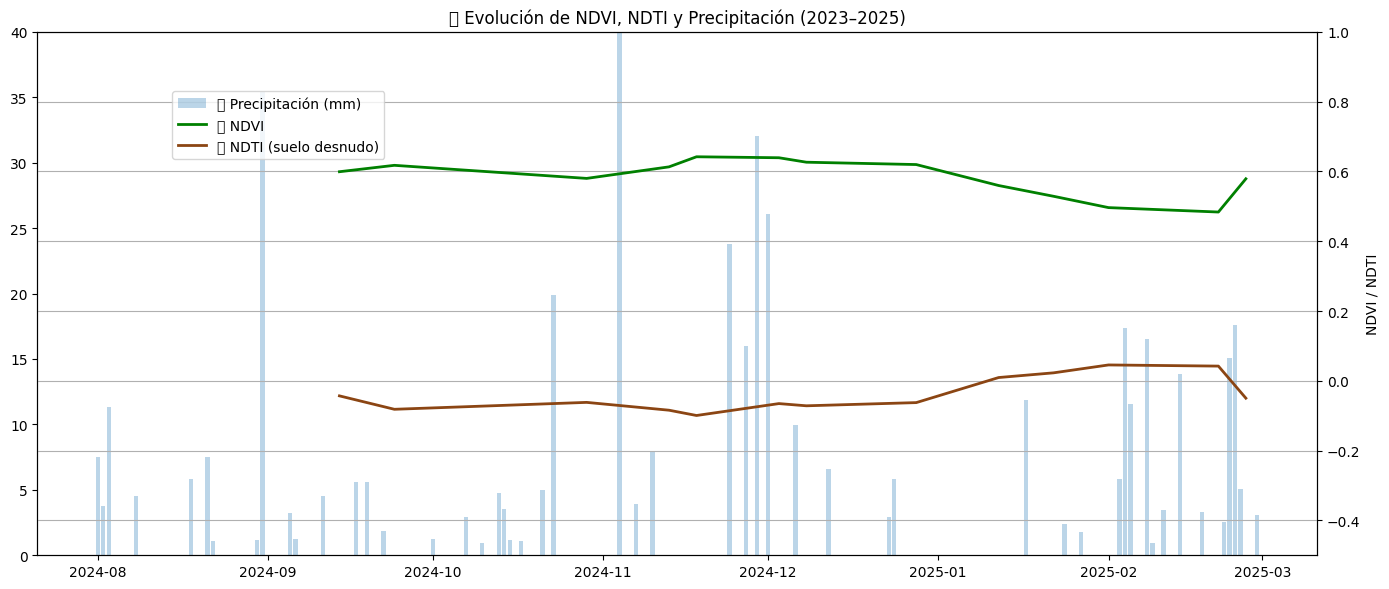

In [86]:
import matplotlib.pyplot as plt

# --- Definir rango de fechas ---
inicio = "2024-08-01"
fin = "2025-04-30"

# --- Asegurar formato datetime ---
ndvi_df["fecha"] = pd.to_datetime(ndvi_df["fecha"])
ndti_df["fecha"] = pd.to_datetime(ndti_df["fecha"])
serie_precip.index = pd.to_datetime(serie_precip.index)

# --- Filtrar por fechas ---
ndvi_filtrado = ndvi_df[(ndvi_df["fecha"] >= inicio) & (ndvi_df["fecha"] <= fin)]
ndti_filtrado = ndti_df[(ndti_df["fecha"] >= inicio) & (ndti_df["fecha"] <= fin)]
precip_filtrada = serie_precip[(serie_precip.index >= inicio) & (serie_precip.index <= fin)]

# --- Crear figura
fig, ax1 = plt.subplots(figsize=(14, 6))

# Precipitación como barras (eje izquierdo)
ax1.bar(precip_filtrada.index, precip_filtrada, color='tab:blue', alpha=0.3, label="🌧️ Precipitación (mm)")
ax1.set_ylim(0, 40)

# NDVI y NDTI en eje derecho
ax2 = ax1.twinx()
ax2.plot(ndvi_filtrado["fecha"], ndvi_filtrado["ndvi_mean"], color="green", label="🌿 NDVI", linewidth=2)
ax2.plot(ndti_filtrado["fecha"], ndti_filtrado["ndti_mean"], color="saddlebrown", label="🧱 NDTI (suelo desnudo)", linewidth=2)
ax2.set_ylabel("NDVI / NDTI")
ax2.set_ylim(-0.5, 1.0)

# Título y leyenda
plt.title("📊 Evolución de NDVI, NDTI y Precipitación (2023–2025)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()

Ene–Mar 2024:

NDVI sube de forma clara → vegetación activa.

NDTI no sube demasiado → ¿siembra directa?

Hay lluvias previas en dic/ene → posible siembra post-precipitación.

Octubre 2023:

Baja fuerte del NDVI.

NDTI sube un poco → probable labranza o cosecha.

Picos de NDTI (↑) combinados con bajo NDVI → indican suelo trabajado o barbecho.

Ej: si NDTI sube y NDVI cae, puede haber habido una labranza convencional.

Si el NDTI no sube pero el NDVI luego crece rápidamente, puede indicar siembra directa:

No hay exposición de suelo (NDTI plano).

Pero el verde (NDVI) crece → señal de siembra sin remover suelo.

Ver si esos eventos coinciden con lluvias previas:

Un pico de NDTI tras lluvia + NDVI posterior puede reforzar la hipótesis de siembra directa post-lluvia.

📍 Posibles eventos de labranza detectados:
        fecha  ndvi_mean  ndti_mean  delta_ndvi  delta_ndti
2  2022-01-13   0.529242   0.005631   -0.064734    0.042607
10 2022-04-13   0.679174  -0.082441   -0.052801    0.078607
12 2022-05-03   0.602143   0.018694   -0.051598    0.041517
13 2022-06-12   0.438982   0.113213   -0.163161    0.094519
25 2022-11-04   0.474996   0.042560   -0.053406    0.034302
36 2023-03-09   0.483826   0.044939   -0.097911    0.068460
47 2023-10-15   0.505863   0.010872   -0.071525    0.036990
55 2024-01-23   0.636324  -0.069064   -0.084431    0.123111
56 2024-01-28   0.573000  -0.025773   -0.063324    0.043292
59 2024-03-23   0.602793  -0.088469   -0.107349    0.052657
62 2024-07-11   0.504950   0.069036   -0.172049    0.175241
72 2025-01-12   0.559579   0.009340   -0.060092    0.071841


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3042033439.py:53: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129521 (\N{BRICK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(by

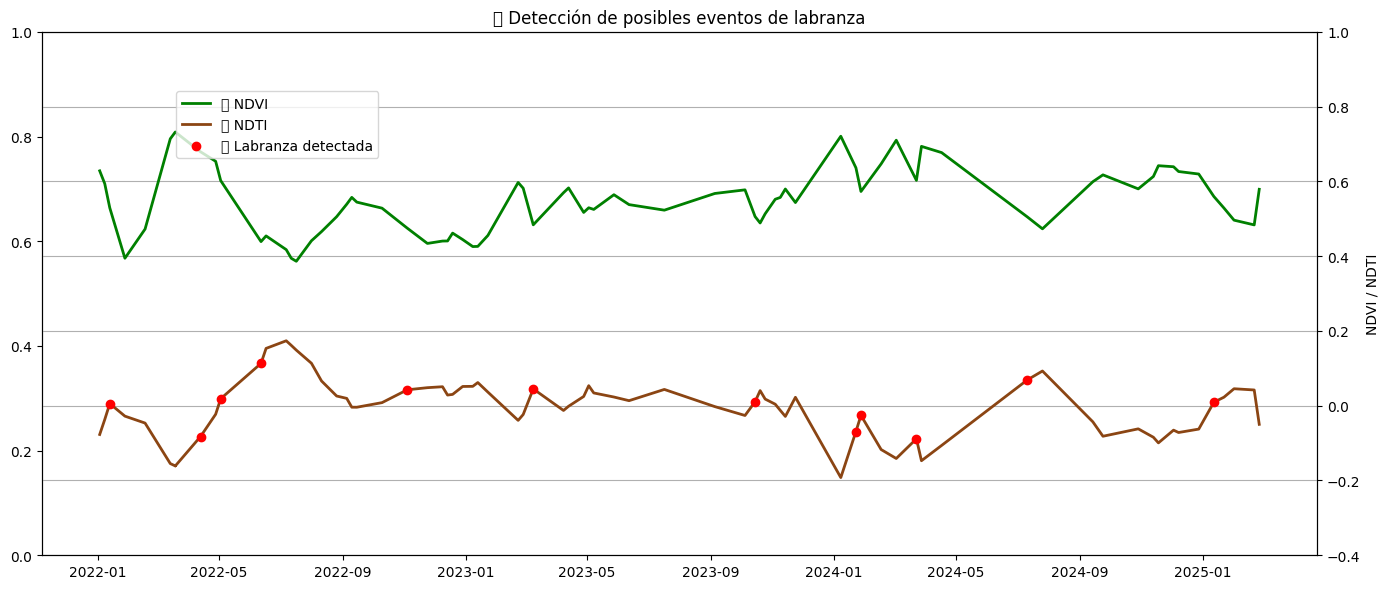

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Asegurarse de que las fechas estén bien formateadas ---
ndvi_df['fecha'] = pd.to_datetime(ndvi_df['fecha'])
ndti_df['fecha'] = pd.to_datetime(ndti_df['fecha'])

# --- 2. Unificar en un solo DataFrame ---
df_labranza = pd.merge(ndvi_df, ndti_df, on="fecha", how="inner")
df_labranza = df_labranza.sort_values("fecha").reset_index(drop=True)

# --- 3. Calcular diferencia de NDVI y NDTI entre fechas consecutivas ---
df_labranza["delta_ndvi"] = df_labranza["ndvi_mean"].diff()
df_labranza["delta_ndti"] = df_labranza["ndti_mean"].diff()

# --- 4. Definir condiciones para posible labranza ---
# Por ejemplo: NDVI baja más de 0.05 y NDTI sube más de 0.03
evento_labranza = df_labranza[
    (df_labranza["delta_ndvi"] < -0.05) &
    (df_labranza["delta_ndti"] > 0.03)
].copy()

print("📍 Posibles eventos de labranza detectados:")
print(evento_labranza[["fecha", "ndvi_mean", "ndti_mean", "delta_ndvi", "delta_ndti"]])

# --- 5. Graficar ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Precipitación (si tenés serie_completa)
try:
    serie_completa['fecha'] = pd.to_datetime(serie_completa['fecha'])
    ax1.bar(serie_completa['fecha'], serie_completa['precipitacion'], 
            color='lightblue', label='🌧️ Precipitación (mm)', alpha=0.3)
    ax1.set_ylim(0, 40)
except:
    pass

# NDVI y NDTI
ax2 = ax1.twinx()
ax2.plot(df_labranza['fecha'], df_labranza['ndvi_mean'], color='green', label='🌿 NDVI', linewidth=2)
ax2.plot(df_labranza['fecha'], df_labranza['ndti_mean'], color='saddlebrown', label='🧱 NDTI', linewidth=2)

# Marcar eventos detectados
ax2.scatter(evento_labranza['fecha'], evento_labranza['ndti_mean'], 
            color='red', label='🔴 Labranza detectada', zorder=5)

ax2.set_ylim(-0.4, 1)
ax2.set_ylabel("NDVI / NDTI", color="black")

plt.title("🔍 Detección de posibles eventos de labranza")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3608781363.py:55: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


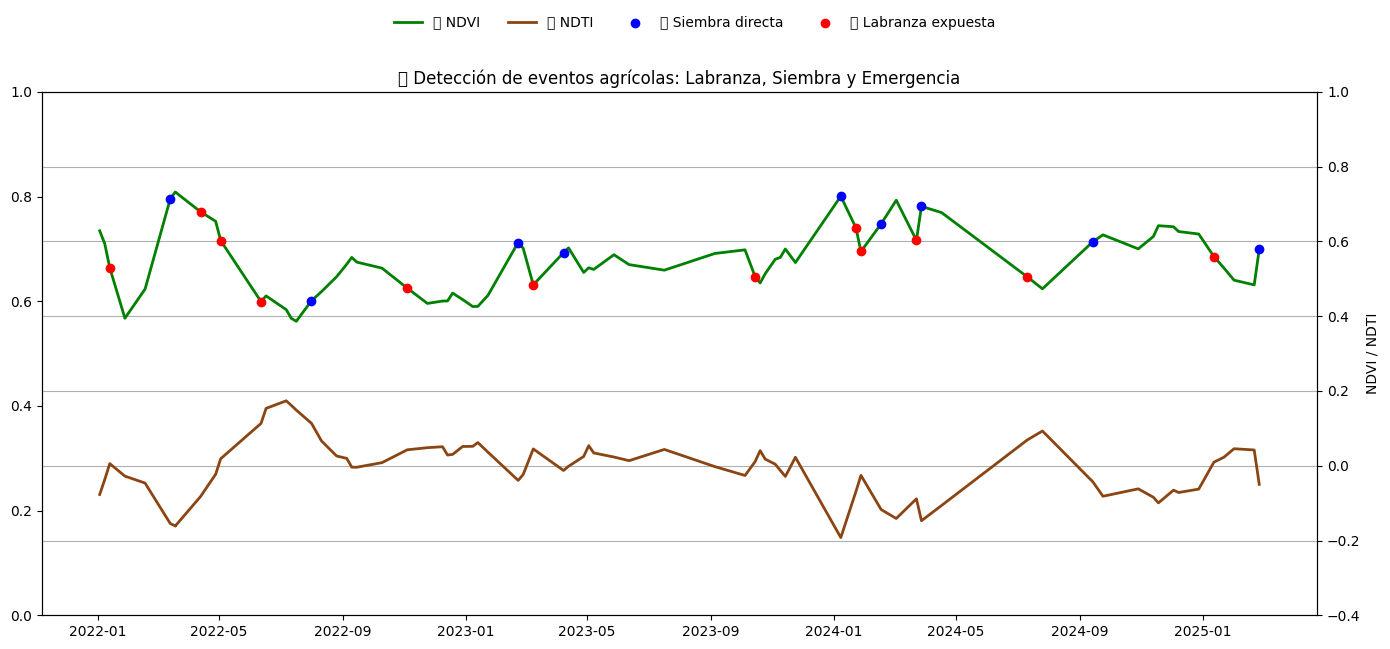

In [88]:
import matplotlib.pyplot as plt
# Calcular deltas
df_labranza["delta_ndvi"] = df_labranza["ndvi_mean"].diff()
df_labranza["delta_ndti"] = df_labranza["ndti_mean"].diff()

# --- 1. Detectar eventos de LABRANZA (NDVI baja, NDTI sube) ---
eventos_labranza = df_labranza[
    (df_labranza["delta_ndvi"] < -0.05) &
    (df_labranza["delta_ndti"] > 0.03)
].copy()

# --- 2. Detectar eventos de SIEMBRA DIRECTA (NDVI sube, NDTI baja) ---
eventos_siembra = df_labranza[
    (df_labranza["delta_ndvi"] > 0.05) &
    (df_labranza["delta_ndti"] < -0.03)
].copy()

# --- 3. Detectar eventos de EMERGENCIA POST-LABRANZA (NDVI sube, NDTI sube) ---
eventos_emergencia = df_labranza[
    (df_labranza["delta_ndvi"] > 0.05) &
    (df_labranza["delta_ndti"] > 0.03)
].copy()

# --- 4. Gráfico combinado ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Precipitación
try:
    ax1.bar(serie_completa['fecha'], serie_completa['precipitacion'],
            color='lightblue', label='🌧️ Precipitación (mm)', alpha=0.3)
    ax1.set_ylim(0, 40)
except:
    pass

# NDVI y NDTI
ax2 = ax1.twinx()
ax2.plot(df_labranza['fecha'], df_labranza['ndvi_mean'], color='green', label='🌿 NDVI', linewidth=2)
ax2.plot(df_labranza['fecha'], df_labranza['ndti_mean'], color='saddlebrown', label='🧱 NDTI', linewidth=2)
ax2.set_ylim(-0.4, 1)
ax2.set_ylabel("NDVI / NDTI", color="black")

# Eventos: Siembra (🔵), Labranza (🔴), Emergencia post-labranza (🟣)
ax2.scatter(eventos_siembra['fecha'], eventos_siembra['ndvi_mean'],
            color='blue', label='🔵 Siembra directa', zorder=5)
ax2.scatter(eventos_labranza['fecha'], eventos_labranza['ndvi_mean'],
            color='red', label='🔴 Labranza expuesta', zorder=5)

# Estética
plt.title("🌱 Detección de eventos agrícolas: Labranza, Siembra y Emergencia")

# Leyenda debajo del gráfico
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol=4, fontsize=10, frameon=False)

plt.grid(True)
plt.tight_layout()
plt.show()

🟢 Curva Verde – NDVI (Normalized Difference Vegetation Index):
Refleja la cobertura vegetal.

Valores cercanos a 0.9 indican vegetación densa y sana (ej. cultivos en crecimiento).

Descensos bruscos pueden sugerir cosecha o remoción de cobertura.

🤎 Curva Marrón – NDTI (Normalized Difference Tillage Index):
Refleja la exposición del suelo.

Valores positivos (cerca de 0.1 a 0.2) indican mayor presencia de suelo desnudo o labranza.

Valores cercanos a cero o negativos indican cobertura vegetal o mínima alteración del suelo.

🔴 Puntos Rojos – Eventos de Labranza expuesta:
Ubicados donde hay un descenso en NDVI acompañado de un aumento de NDTI.

Esto sugiere que se removió cobertura vegetal y el suelo quedó expuesto, posiblemente por labranza convencional.

🔵 Puntos Azules – Eventos de Siembra directa:
Ubicados donde hay descenso en NDVI pero el NDTI permanece bajo o estable.

Esto sugiere que se removió vegetación (ej. rastrojos) sin exponer el suelo, compatible con prácticas de siembra directa.

🔴 Labranza: baja vegetación y aumento de suelo desnudo.

🔵 Siembra directa: aumento de vegetación sin exposición de suelo.

🟣 Emergencia post-labranza: crecimiento posterior tras labranza.

# Información de Cultivos

In [89]:
def obtener_datos_cultivo_argentina(poligono, año):
    """
    Obtiene el histograma de clases de uso del suelo para un polígono
    utilizando MapBiomas Argentina - Colección 1.
    """
    try:
        # Cargar la colección de MapBiomas Argentina
        mapbiomas = ee.Image(f'projects/mapbiomas-public/assets/argentina/collection1/mapbiomas_argentina_collection1_integration_v1')

        # Extraer la banda correspondiente al año deseado (los años están como 'classification_YYYY')
        banda = f"classification_{año}"
        imagen_anual = mapbiomas.select(banda)

        # Reducir por región
        clasificacion = imagen_anual.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=poligono,
            scale=30,
            maxPixels=1e13
        )

        resultado = clasificacion.getInfo()
        return resultado.get(banda, {})
    
    except Exception as e:
        print(f"⚠️ Error al obtener datos MapBiomas Argentina para {año}: {e}")
        return {}

In [90]:
# polygon_gee debe estar definido como un ee.Geometry.Polygon
resultados_2022 = obtener_datos_cultivo_argentina(polygon_gee, 2022)
print("Distribución de clases para 2022:", resultados_2022)


Distribución de clases para 2022: {'11': 3552.223529411764, '12': 46486.78823529413, '15': 19955.52941176472, '18': 11338.992156862747, '3': 184.2549019607843, '4': 17.396078431372548, '9': 730.9803921568625}


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3473089139.py:23: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3473089139.py:23: UserWarning: Glyph 128167 (\N{DROPLET}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3473089139.py:23: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3473089139.py:23: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3473089139.py:23: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3473089139.py:23: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from current font.
  plt.tight_layout()
C:\U

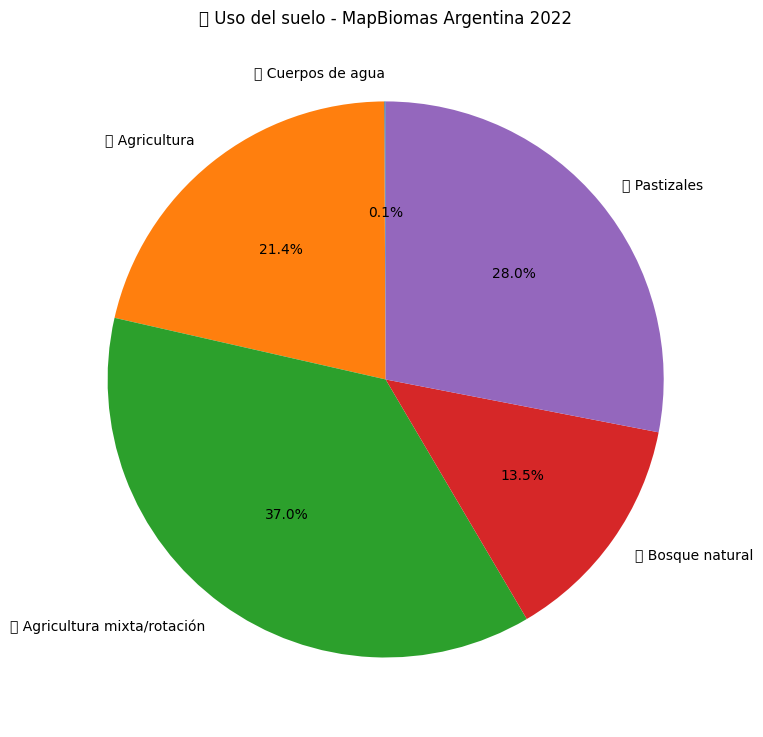

In [91]:
import matplotlib.pyplot as plt

# Mapeo de clases según MapBiomas Argentina
leyenda_mapbiomas = {
    '3': "🌳 Bosque natural",
    '4': "🌾 Pastizales",
    '12': "💧 Cuerpos de agua",
    '15': "🌱 Agricultura",
    '18': "🔁 Agricultura mixta/rotación"
}

# Diccionario de frecuencias que obtuviste
datos_clases = {'12': 1.13, '15': 290.39, '18': 503.49, '3': 183.26, '4': 381.30}

# Preparar datos para gráfico
labels = [leyenda_mapbiomas.get(k, f"Clase {k}") for k in datos_clases.keys()]
valores = list(datos_clases.values())

# Gráfico
plt.figure(figsize=(8, 8))
plt.pie(valores, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("🗺️ Uso del suelo - MapBiomas Argentina 2022")
plt.tight_layout()
plt.show()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3764996970.py:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


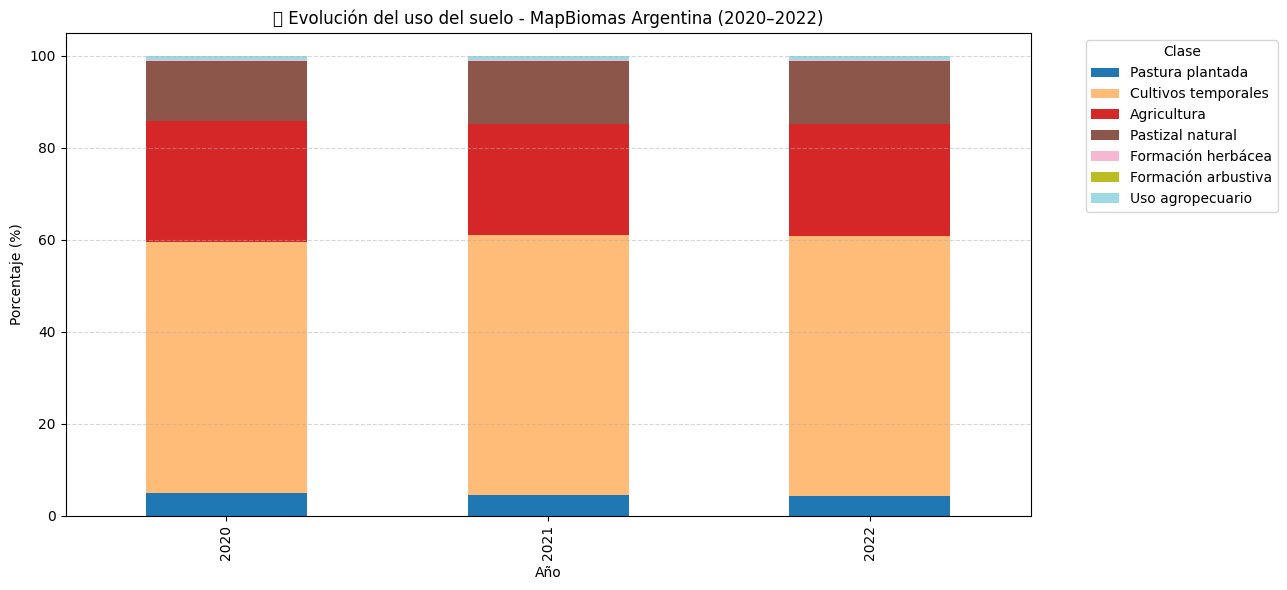

In [92]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Inicializar Earth Engine
ee.Initialize()

# Polígono de interés
polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
polygon_gee = ee.Geometry.Polygon([polygon_coords])

# Función para obtener datos MapBiomas Argentina
def obtener_datos_cultivo_argentina(poligono, año):
    try:
        mapbiomas = ee.Image(
            'projects/mapbiomas-public/assets/argentina/collection1/mapbiomas_argentina_collection1_integration_v1'
        )
        banda = f"classification_{año}"
        imagen_anual = mapbiomas.select(banda)
        clasificacion = imagen_anual.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=poligono,
            scale=30,
            maxPixels=1e13
        )
        resultado = clasificacion.getInfo()
        return resultado.get(banda, {})
    except Exception as e:
        print(f"⚠️ Error al obtener datos MapBiomas Argentina para {año}: {e}")
        return {}

# Diccionario de equivalencias de clases MapBiomas Argentina
clases_mapbiomas = {
    "1": "Bosque natural",
    "2": "Bosque plantado",
    "3": "Formación herbácea",
    "4": "Formación arbustiva",
    "5": "Manglar",
    "9": "Uso agropecuario",
    "10": "Silvopastoril",
    "11": "Pastura plantada",
    "12": "Cultivos temporales",
    "13": "Cultivos permanentes",
    "14": "Mosaico agrícola y pastizal",
    "15": "Agricultura",
    "16": "Mosaico agrícola y urbano",
    "18": "Pastizal natural",
    "19": "Áreas urbanas",
    "21": "Humedal",
    "22": "Cuerpos de agua",
    "24": "Sin vegetación",
    "25": "Otros"
}

# Años a analizar
anios = [2020, 2021, 2022]

# Extraer datos
datos_por_año = {}
for año in anios:
    datos_por_año[año] = obtener_datos_cultivo_argentina(polygon_gee, año)

# Convertir a DataFrame
df = pd.DataFrame(datos_por_año).fillna(0).T
df.index.name = 'Año'
df.columns = df.columns.astype(str)

# Renombrar columnas con nombres legibles
df.rename(columns=clases_mapbiomas, inplace=True)

# Eliminar columnas con 0 en todos los años
df = df.loc[:, (df != 0).any(axis=0)]

# Convertir a proporciones (%)
df_prop = df.div(df.sum(axis=1), axis=0) * 100

# Graficar
df_prop.plot(kind='bar', stacked=True, figsize=(13, 6), colormap='tab20')
plt.title("📊 Evolución del uso del suelo - MapBiomas Argentina (2020–2022)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Año")
plt.legend(title="Clase", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Comparando con NDVI Zonal

In [93]:
def obtener_ndvi_promedio_zonal(poligono_zona, fecha_inicio, fecha_fin):
    coleccion = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(poligono_zona)
        .filterDate(fecha_inicio, fecha_fin)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
        .select(["B4", "B8"])
    )

    def calcular_ndvi(img):
        ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
        return ndvi.set("system:time_start", img.get("system:time_start"))

    coleccion_ndvi = coleccion.map(calcular_ndvi)

    # Reducir NDVI promedio para cada imagen
    reducida = coleccion_ndvi.map(
        lambda img: ee.Feature(
            None,
            {
                "NDVI": img.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=poligono_zona,
                    scale=10,
                    bestEffort=True
                ).get("NDVI"),
                "fecha": img.date().format("YYYY-MM-dd")
            }
        )
    )

    # Traer los datos a Python
    features = reducida.getInfo()["features"]
    fechas = [f["properties"]["fecha"] for f in features]
    valores = [f["properties"]["NDVI"] for f in features]

    df = pd.DataFrame({"fecha": fechas, "ndvi_prom_zona": valores})
    df["fecha"] = pd.to_datetime(df["fecha"])
    df = df.dropna().sort_values("fecha")

    return df

In [94]:
# Transformar a CRS proyectado para hacer buffer en metros
aoi_buffered = aoi_gdf.to_crs(epsg=3857).buffer(50000).to_crs(epsg=4326)  # 5 km buffer
zona_buffer = aoi_buffered.unary_union  # Usá union_all() si estás en geopandas >= 1.2
poligono_zona = ee.Geometry.Polygon(list(zona_buffer.exterior.coords))

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3171802818.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  zona_buffer = aoi_buffered.unary_union  # Usá union_all() si estás en geopandas >= 1.2


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2502978970.py:21: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2502978970.py:21: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


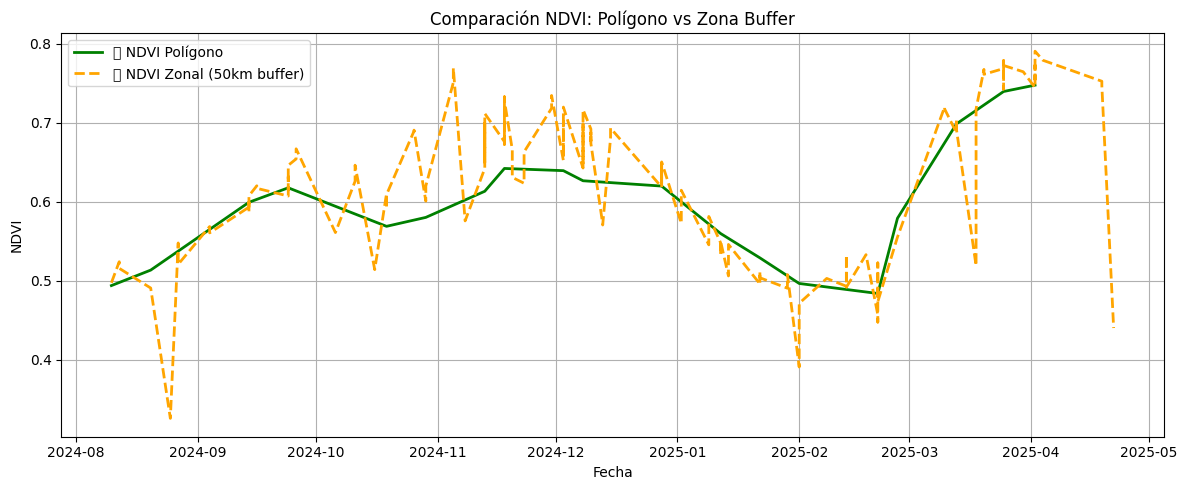

In [95]:
from shapely.geometry import mapping

# --- 1. Definir el polígono del AOI como ee.Geometry
aoi_polygon = ee.Geometry.Polygon(list(aoi_gdf.iloc[0].geometry.exterior.coords))

# --- 2. Obtener NDVI para polígono y zona buffer ---
ndvi_poligono = obtener_ndvi_promedio_zonal(aoi_polygon, "2024-08-01", "2025-04-30")
ndvi_zona = obtener_ndvi_promedio_zonal(poligono_zona, "2024-08-01", "2025-04-30")
ndvi_zona.rename(columns={"ndvi_prom_zona": "ndvi_prom_zona"}, inplace=True)  # opcional


# --- 4. Graficar ---
plt.figure(figsize=(12, 5))
plt.plot(ndvi_poligono["fecha"], ndvi_poligono["ndvi_prom_zona"], label="🌿 NDVI Polígono", color="green", linewidth=2)
plt.plot(ndvi_zona["fecha"], ndvi_zona["ndvi_prom_zona"], label="🌱 NDVI Zonal (50km buffer)", color="orange", linestyle="--", linewidth=2)
plt.title("Comparación NDVI: Polígono vs Zona Buffer")
plt.xlabel("Fecha")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Deforestación

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2981900040.py:51: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


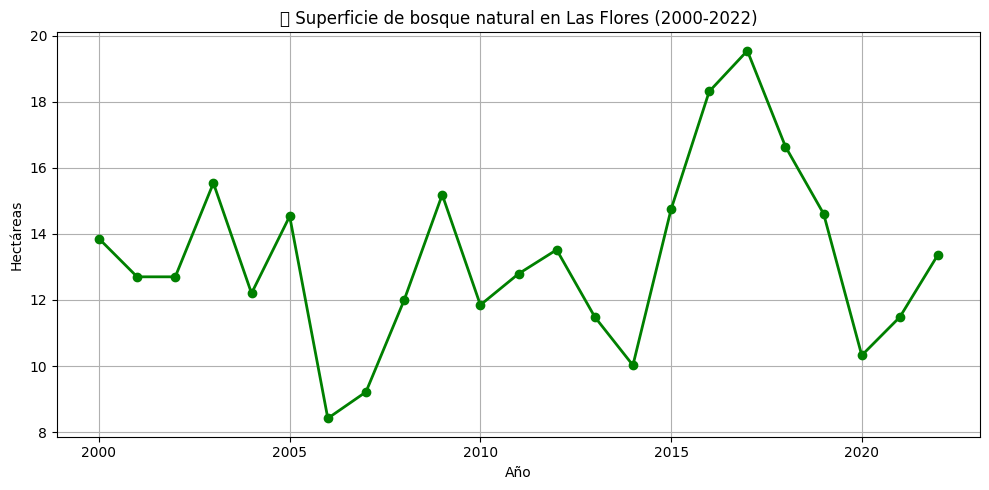

In [96]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

ee.Initialize()



polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
pampa_poly = ee.Geometry.Polygon([polygon_coords])





coleccion = ee.Image("projects/mapbiomas-public/assets/argentina/collection1/mapbiomas_argentina_collection1_integration_v1")
anios = list(range(2000, 2023))
clase_bosque = 3  # Bosque natural

superficies = []
for anio in anios:
    banda = f"classification_{anio}"
    imagen = coleccion.select(banda)
    bosque = imagen.eq(clase_bosque)
    area_ha = bosque.multiply(ee.Image.pixelArea()).divide(10000)
    stats = area_ha.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=pampa_poly,
        scale=30,
        maxPixels=1e13
    )
    ha_bosque = stats.getInfo().get(banda, 0)
    superficies.append({"año": anio, "ha_bosque": ha_bosque})

df_bosque = pd.DataFrame(superficies)

plt.figure(figsize=(10, 5))
plt.plot(df_bosque["año"], df_bosque["ha_bosque"], marker="o", color="green", linewidth=2)
plt.title("🌳 Superficie de bosque natural en Las Flores (2000-2022)")
plt.xlabel("Año")
plt.ylabel("Hectáreas")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2994843299.py:59: UserWarning: Glyph 129717 (\N{WOOD}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129717 (\N{WOOD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


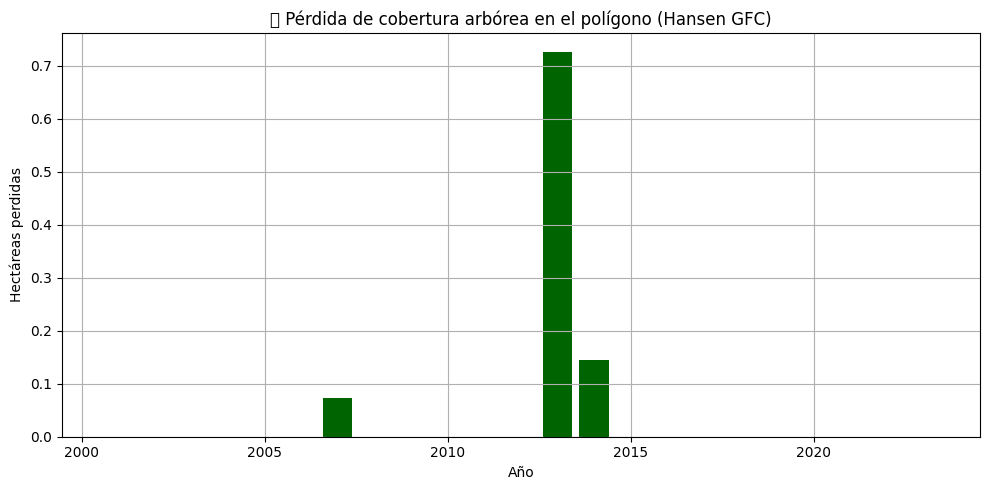

In [97]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Inicializar Earth Engine
ee.Initialize()

# Polígono personalizado
polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi_polygon = ee.Geometry.Polygon([polygon_coords])

# Hansen dataset
hansen = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")
loss_image = hansen.select("lossyear")

# Función para contar pérdida por año
def count_loss(year):
    mask = loss_image.eq(year)
    area_image = mask.multiply(ee.Image.pixelArea()).divide(10000)
    area = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi_polygon,
        scale=30,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        "year": 2000 + year,
        "loss_ha": area.get("lossyear")
    })

# Construir colección de features
features = ee.FeatureCollection([count_loss(y) for y in range(1, 24)])  # Años 2001-2023
features_list = features.toList(features.size()).getInfo()

# Convertir a DataFrame
data = []
for f in features_list:
    props = f["properties"]
    if props.get("loss_ha") is not None:
        data.append({"year": props["year"], "loss_ha": props["loss_ha"]})

df_loss = pd.DataFrame(data).sort_values("year")

# Graficar
plt.figure(figsize=(10, 5))
plt.bar(df_loss["year"], df_loss["loss_ha"], color="darkgreen")
plt.title("🪵 Pérdida de cobertura arbórea en el polígono (Hansen GFC)")
plt.xlabel("Año")
plt.ylabel("Hectáreas perdidas")
plt.grid(True)
plt.tight_layout()
plt.show()


In [98]:
import ee
import folium
from shapely.geometry import Polygon
import geopandas as gpd
from IPython.display import display

# 1. Inicializar Earth Engine
ee.Initialize()

# 2. Definir tu AOI
polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
poly = Polygon(polygon_coords)
aoi = ee.Geometry.Polygon([polygon_coords])

# 3. Cargar Hansen GFC
hansen = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")

# 4. Extraer la banda 'loss' (1 = pérdida en algún año, 0 = sin pérdida)
loss_binary = hansen.select('loss').clip(aoi)

# 5. Definir estilo para la máscara de pérdida: rojo donde loss==1
loss_vis = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'FF0000']  # 0 negro/transparente, 1 rojo
}

# 6. Generar el MapID
map_id = loss_binary.getMapId(loss_vis)

# 7. Crear mapa con folium centrado en el AOI
centroide = poly.centroid
m = folium.Map(location=[centroide.y, centroide.x], zoom_start=14)

# 8. Capa AOI
gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs='EPSG:4326')
folium.GeoJson(gdf, name="AOI").add_to(m)

# 9. Capa de deforestación (siempre rojo)
folium.TileLayer(
    tiles=map_id['tile_fetcher'].url_format,
    attr='Hansen GFC',
    name='❌ Pérdida forestal (2001–2023)',
    overlay=True,
    control=True,
    opacity=0.7
).add_to(m)

# 10. Control de capas y mostrar
folium.LayerControl().add_to(m)
display(m)


In [99]:
import ee
import pandas as pd

# Asegurarse de que Earth Engine esté inicializado
ee.Initialize()

# 1. Definir el polígono (tu AOI)
polygon_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi = ee.Geometry.Polygon([polygon_coords])

# 2. Cargar la capa de año de pérdida (lossyear)
hansen = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")
lossyear = hansen.select("lossyear")

# 3. Calcular hectáreas deforestadas por año (2001 a 2023)
resultados = []

for i in range(1, 24):  # valores de 1 a 23 = años 2001 a 2023
    year_mask = lossyear.eq(i)
    
    area = year_mask.multiply(ee.Image.pixelArea()).clip(aoi)
    total_area = area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).getInfo()

    # Convertimos a hectáreas (1 ha = 10,000 m²)
    ha = total_area.get("lossyear", 0) / 10000 if total_area.get("lossyear") else 0
    resultados.append({"Año": 2000 + i, "Hectáreas perdidas": round(ha, 2)})

# 4. Mostrar los resultados
df_perdidas = pd.DataFrame(resultados)
print(df_perdidas)

     Año  Hectáreas perdidas
0   2001                0.00
1   2002                0.00
2   2003                0.00
3   2004                0.00
4   2005                0.00
5   2006                0.00
6   2007                0.07
7   2008                0.00
8   2009                0.00
9   2010                0.00
10  2011                0.00
11  2012                0.00
12  2013                0.73
13  2014                0.15
14  2015                0.00
15  2016                0.00
16  2017                0.00
17  2018                0.00
18  2019                0.00
19  2020                0.00
20  2021                0.00
21  2022                0.00
22  2023                0.00


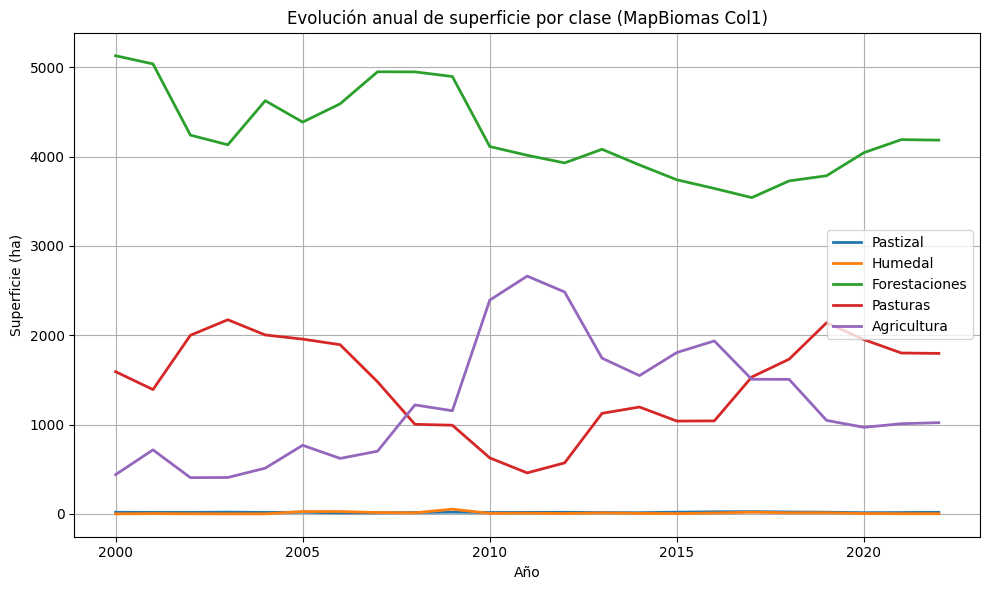

In [100]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Inicializar Earth Engine
ee.Initialize()

coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]

aoi = ee.Geometry.Polygon([coords])

# Función que para un año devuelve superficie por clase (ha)
def superficie_por_clase(aoi, año):
    asset = 'projects/mapbiomas-public/assets/argentina/collection1/' \
            'mapbiomas_argentina_collection1_integration_v1'
    img = ee.Image(asset).select(f'classification_{año}')
    # Reducimos región a histograma de conteo de píxeles
    hist = img.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=aoi,
        scale=30,
        maxPixels=1e12
    ).getInfo()
    conteos = hist.get(f'classification_{año}', {})
    # Convertir conteos a superficie en ha (cada píxel ≈ 30×30 m)
    retorno = {}
    for clase, count in conteos.items():
        ha = (count * 30 * 30) / 10000
        retorno[int(clase)] = ha
    return retorno

# Recorrer los años y armar DataFrame
clases = [3,4,12,15,18]
años = list(range(2000, 2023))
data = {c: [] for c in clases}
data['año'] = años

for año in años:
    sup = superficie_por_clase(aoi, año)
    for c in clases:
        data[c].append(sup.get(c, 0.0))

df = pd.DataFrame(data).set_index('año')

# Graficar
plt.figure(figsize=(10,6))
for c in clases:
    nombre = {3:'Pastizal',4:'Humedal',12:'Forestaciones',15:'Pasturas',18:'Agricultura'}[c]
    plt.plot(df.index, df[c], label=f'{nombre}', linewidth=2)
plt.title("Evolución anual de superficie por clase (MapBiomas Col1)")
plt.xlabel("Año")
plt.ylabel("Superficie (ha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
# (asegurate de tener esto en el tope de tu módulo)
load_dotenv()

class AgricultureSatelliteData:
    # … tus métodos anteriores …

    def get_weather_data_from_smn(self, province, aoi_gdf, last_days=30):
        """
        Obtiene estadísticos meteorológicos para el centroide
        de 'aoi_gdf' usando la API de NASA POWER.
        Devuelve temp min/max, días >30°C, <3°C, días con precip y precip total.
        """
        # Coordenadas del centroide
        centroid = aoi_gdf.geometry.centroid.iloc[0]
        lat, lon = centroid.y, centroid.x

        # Fechas
        end = datetime.utcnow().date()
        start = end - timedelta(days=last_days)
        start_str = start.strftime("%Y%m%d")
        end_str = end.strftime("%Y%m%d")

        # Parámetros NASA POWER
        params = {
            "start":   start_str,
            "end":     end_str,
            "latitude":  lat,
            "longitude": lon,
            "parameters": "T2M_MIN,T2M_MAX,PRECTOT",
            "community":  "AG",
            "format":     "JSON",
        }
        url = "https://power.larc.nasa.gov/api/temporal/daily/point"

        try:
            r = requests.get(url, params=params, timeout=30)
            r.raise_for_status()
            payload = r.json()["properties"]["parameter"]
        except Exception as e:
            print(f"Error al conectar con NASA POWER: {e}")
            return None

        # Convertir a DataFrame
        df = pd.DataFrame({
            "tmin": pd.Series(payload["T2M_MIN"]),
            "tmax": pd.Series(payload["T2M_MAX"]),
            "prec": pd.Series(payload["PRECTOT"])
        }, index=pd.to_datetime(list(payload["T2M_MIN"].keys()), format="%Y%m%d"))

        # Calcular estadísticos
        min_temp = float(df["tmin"].min())
        max_temp = float(df["tmax"].max())
        days_above_30 = int((df["tmax"] > 30).sum())
        days_below_3  = int((df["tmin"] < 3).sum())
        precip_days  = int((df["prec"] > 0).sum())
        acc_precip   = float(df["prec"].sum())

        return {
            "province": province,
            "weather_data": {
                "min_temp_last_30_days": min_temp,
                "max_temp_last_30_days": max_temp,
                "days_above_30C": days_above_30,
                "days_below_3C": days_below_3,
                "precipitation_days": precip_days,
                "accumulated_precipitation": acc_precip,
            }
        }

In [103]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd

class AgricultureSatelliteData:
    # … tus otros métodos …

    def get_weather_data_from_smn(self, province, aoi_gdf,
                                  start_date: str = None,
                                  end_date:   str = None,
                                  last_days: int = 30):
        """
        Obtiene estadísticas meteorológicas de NASA POWER para el centroide de 'aoi_gdf'.

        Args:
          province:     Nombre de la provincia (solo para etiqueta).
          aoi_gdf:      GeoDataFrame con tu AOI, crs EPSG:4326.
          start_date:   Fecha inicio “YYYY-MM-DD”. Si None, se usa end-last_days.
          end_date:     Fecha fin “YYYY-MM-DD”. Si None, se usa ayer.
          last_days:    Si no das fechas, rango final será last_days días.
        """
        # 1) Calcular centroide en EPSG:4326
        proj = aoi_gdf.to_crs(epsg=3857)
        cent = proj.geometry.centroid.iloc[0]
        centroid = gpd.GeoSeries([cent], crs=3857).to_crs(epsg=4326).iloc[0]
        lat, lon = centroid.y, centroid.x

        # 2) Fechas
        today = datetime.utcnow().date()
        E = datetime.strptime(end_date, "%Y-%m-%d").date() if end_date else (today - timedelta(days=1))
        S = datetime.strptime(start_date, "%Y-%m-%d").date() if start_date else (E - timedelta(days=last_days))
        S_str, E_str = S.strftime("%Y%m%d"), E.strftime("%Y%m%d")

        # 3) Llamada NASA POWER pidiendo PRECTOTCORR
        url = "https://power.larc.nasa.gov/api/temporal/daily/point"
        params = {
            "start":     S_str,
            "end":       E_str,
            "latitude":  lat,
            "longitude": lon,
            "parameters":"T2M_MIN,T2M_MAX,PRECTOTCORR",
            "community": "AG",
            "format":    "JSON",
        }
        try:
            r = requests.get(url, params=params, timeout=30)
            r.raise_for_status()
            payload = r.json()["properties"]["parameter"]
        except Exception as e:
            print(f"❌ Error conectando a NASA POWER: {e}")
            return None

        print("🔑 Claves recibidas:", list(payload.keys()))

        # 4) Extraer series
        tmin = pd.Series(payload.get("T2M_MIN", {}), name="tmin")
        tmax = pd.Series(payload.get("T2M_MAX", {}), name="tmax")
        prec = pd.Series(payload.get("PRECTOTCORR", {}), name="prec")

        # 5) Montar DataFrame y convertir a numérico
        df = pd.concat([tmin, tmax, prec], axis=1)
        df.index = pd.to_datetime(df.index, format="%Y%m%d")
        df = df.apply(pd.to_numeric, errors="coerce")

        print(f"📊 Registros totales: {len(df)}  |  "
              f"tmin válidos: {df['tmin'].count()}  "
              f"tmax válidos: {df['tmax'].count()}  "
              f"prec válidos: {df['prec'].count()}")

        if df[["tmin","tmax","prec"]].dropna(how="all").empty:
            print(f"⚠️ No hay datos útiles entre {S} y {E}")
            return None

        # 6) Limpieza: reemplazar Tmin = -999, imputar, y clip de precipitación
        df["tmin"] = df["tmin"].replace(-999, pd.NA).astype("Float64")
        min_valid = df["tmin"].min(skipna=True)
        df["tmin"] = df["tmin"].fillna(min_valid)
        df["prec"] = df["prec"].clip(lower=0)

        # 7) Estadísticos
        stats = {
            "province": province,
            "weather_data": {
                "period_start":    S,
                "period_end":      E,
                "min_temp":        float(df["tmin"].min()),
                "max_temp":        float(df["tmax"].max()),
                "days_above_30C":  int((df["tmax"] > 30).sum()),
                "days_below_3C":   int((df["tmin"] < 3).sum()),
                "precip_days":     int((df["prec"] > 0).sum()),
                "accum_precip_mm": float(df["prec"].sum()),
            }
        }
        return stats


# — Ejemplo de uso —
if __name__ == "__main__":
    from shapely.geometry import Polygon

    # Definí tu AOI
    coords = [
    [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
    [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
    [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
    [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
    [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
    [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
    [-58.90920, -36.05020], [-58.89260, -36.03620]
    ] 
    aoi = gpd.GeoDataFrame({'geometry':[Polygon(coords)]}, crs="EPSG:4326")

    agri = AgricultureSatelliteData()
    res  = agri.get_weather_data_from_smn(
        province="Las Flores",
        aoi_gdf=aoi,
        last_days=90
    )
    print(res)

🔑 Claves recibidas: ['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR']
📊 Registros totales: 91  |  tmin válidos: 91  tmax válidos: 91  prec válidos: 91
{'province': 'Las Flores', 'weather_data': {'period_start': datetime.date(2025, 1, 24), 'period_end': datetime.date(2025, 4, 24), 'min_temp': 6.16, 'max_temp': 40.94, 'days_above_30C': 36, 'days_below_3C': 0, 'precip_days': 60, 'accum_precip_mm': 296.29999999999995}}


# Humedad en el Suelo

In [104]:
import ee
import geopandas as gpd
from datetime import datetime, timedelta

# Inicializar Earth Engine
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

class AgricultureSatelliteData:
    def __init__(self):
        pass

    def get_soil_moisture_data(self,
                               province: str,
                               aoi_gdf: gpd.GeoDataFrame,
                               start_date: str = None,
                               end_date:   str = None,
                               last_days:  int = 30,
                               hist_start_year: int = 2015,
                               hist_end_year:   int = None):
        """
        Obtiene humedad superficial SMAP L3 (0–5 cm) para el centroide de aoi_gdf,
        calcula la media histórica (mismo día-mes entre hist_start_year y el año anterior)
        y la anomalía (actual − histórico).
        """
        # 1) Centroide en EPSG:4326
        proj = aoi_gdf.to_crs(epsg=3857)
        cent = proj.geometry.centroid.iloc[0]
        centroid = gpd.GeoSeries([cent], crs=3857).to_crs(epsg=4326).geometry.iloc[0]
        lat, lon = centroid.y, centroid.x

        # 2) Rango actual
        today = datetime.utcnow().date()
        E = (datetime.strptime(end_date, "%Y-%m-%d").date()
             if end_date else today - timedelta(days=1))
        S = (datetime.strptime(start_date, "%Y-%m-%d").date()
             if start_date else E - timedelta(days=last_days))
        print(f"🔍 SMAP L3 SSM: {S} → {E}")

        # 3) Colección y promedio actual
        col = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
               .filterDate(S.strftime("%Y-%m-%d"),
                           (E + timedelta(days=1)).strftime("%Y-%m-%d"))
               .select(["soil_moisture_am", "soil_moisture_pm"]))
        if col.size().getInfo() == 0:
            print("⚠️ No hay imágenes SMAP en ese rango.")
            return None

        mean_img = col.mean()
        avg_ssm = mean_img.expression(
            "(am + pm) / 2",
            {"am": mean_img.select("soil_moisture_am"),
             "pm": mean_img.select("soil_moisture_pm")}
        ).rename("ssm")

        geom = ee.Geometry.Polygon(list(aoi_gdf.geometry.iloc[0].exterior.coords))
        ssm_curr = avg_ssm.reduceRegion(
            ee.Reducer.mean(), geometry=geom, scale=9000, maxPixels=1e9
        ).get("ssm")
        ssm_curr = ee.Number(ssm_curr).getInfo()
        print(f"➡️ Humedad superficial promedio actual (m³/m³): {ssm_curr:.4f}")

        # 4) Históricos
        end_hist = hist_end_year or (S.year - 1)
        sd = datetime.combine(S, datetime.min.time())
        ed = datetime.combine(E, datetime.min.time())

        hist_imgs = []
        for y in range(hist_start_year, end_hist + 1):
            s = sd.replace(year=y).strftime("%Y-%m-%d")
            e = ed.replace(year=y).strftime("%Y-%m-%d")
            col_h = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
                     .filterDate(s, (datetime.strptime(e, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d"))
                     .select(["soil_moisture_am", "soil_moisture_pm"]))
            if col_h.size().getInfo() > 0:
                # renombrar la banda ssm
                mi = col_h.mean().expression(
                    "(am + pm) / 2",
                    {"am": col_h.mean().select("soil_moisture_am"),
                     "pm": col_h.mean().select("soil_moisture_pm")}
                ).rename("ssm")
                hist_imgs.append(mi)

        if not hist_imgs:
            print(f"⚠️ Sin histórico SMAP L3 entre {hist_start_year} y {end_hist}")
            hist_mean = None
        else:
            hist_coll = ee.ImageCollection(hist_imgs)
            # reducir a un solo valor medio
            hist_mean = hist_coll.mean().reduceRegion(
                ee.Reducer.mean(), geometry=geom, scale=9000, maxPixels=1e9
            )
            # si no existe la clave 'ssm', devolvemos None
            hist_mean = hist_mean.get("ssm")
            hist_mean = ee.Number(hist_mean).getInfo() if hist_mean else None
            if hist_mean is not None:
                print(f"➡️ Humedad superficial histórica (m³/m³): {hist_mean:.4f}")

        # 5) Anomalía
        anomaly = None
        if hist_mean is not None:
            anomaly = ssm_curr - hist_mean
            print(f"➡️ Anomalía SSM: {anomaly:.4f} (actual − histórico)")

        return {
            "province": province,
            "soil_moisture": {
                "period_start":     S,
                "period_end":       E,
                "surface_ssm_m3m3": ssm_curr,
                "historic_ssm":     hist_mean,
                "anomaly":          anomaly
            }
        }

# — Ejemplo de uso —
if __name__ == "__main__":
    from shapely.geometry import Polygon

    coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
    
    aoi_gdf = gpd.GeoDataFrame(geometry=[Polygon(coords)], crs="EPSG:4326")

    agri = AgricultureSatelliteData()
    res = agri.get_soil_moisture_data(
        province="Córdoba",
        aoi_gdf=aoi_gdf,
        last_days=90,
        hist_start_year=2015
    )
    print(res)





🔍 SMAP L3 SSM: 2025-01-24 → 2025-04-24
➡️ Humedad superficial promedio actual (m³/m³): 0.3012
➡️ Humedad superficial histórica (m³/m³): 0.2717
➡️ Anomalía SSM: 0.0295 (actual − histórico)
{'province': 'Córdoba', 'soil_moisture': {'period_start': datetime.date(2025, 1, 24), 'period_end': datetime.date(2025, 4, 24), 'surface_ssm_m3m3': 0.30116314329047056, 'historic_ssm': 0.2716753232120956, 'anomaly': 0.02948782007837497}}


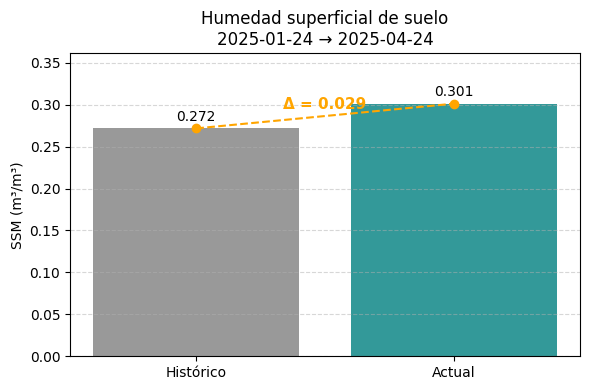

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponemos que ya tienes 'res' con la salida del método:
# {
#   "province": "Entre Rios",
#   "soil_moisture": {
#       "period_start": date1,
#       "period_end":   date2,
#       "surface_ssm_m3m3": actual,
#       "historic_ssm":     historic,
#       "anomaly":          anomaly
#   }
# }

sm = res['soil_moisture']
actual   = sm['surface_ssm_m3m3']
historic = sm['historic_ssm']
anomaly  = sm['anomaly']
period   = f"{sm['period_start']} → {sm['period_end']}"

# Preparamos un DataFrame para graficar
df = pd.DataFrame({
    'Periodo': ['Histórico', 'Actual'],
    'SSM (m³/m³)': [historic, actual]
})

fig, ax = plt.subplots(figsize=(6,4))

# Barras comparativas
bars = ax.bar(df['Periodo'], df['SSM (m³/m³)'], color=['gray','teal'], alpha=0.8)

# Anotación de los valores encima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.005, f"{h:.3f}",
            ha='center', va='bottom', fontsize=10)

# Línea de anomalía
ax.plot([0,1], [historic, actual], color='orange', linestyle='--', marker='o')
ax.text(0.5, (historic+actual)/2 + 0.005,
        f"Δ = {anomaly:.3f}", color='orange',
        ha='center', va='bottom', fontsize=11, fontweight='bold')

# Titulares y estilo
ax.set_title(f"Humedad superficial de suelo\n{period}", fontsize=12)
ax.set_ylabel("SSM (m³/m³)")
ax.set_ylim(0, max(actual, historic)*1.2)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

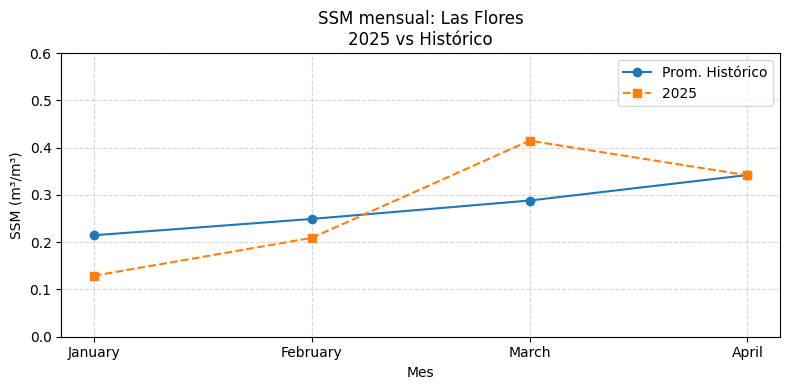

      month  historic    target
0   January  0.214634  0.128946
1  February  0.249190  0.209097
2     March  0.288167  0.414739
3     April  0.342052  0.341600


In [106]:
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import ee

class AgricultureSatelliteData:
    # … tus otros métodos …

    def compare_monthly_ssm(self,
                            province: str,
                            aoi_gdf,
                            target_year: int,
                            months: list,
                            hist_start_year: int = 2015,
                            hist_end_year: int = None):
        """
        Compara mes a mes el SSM de SMAP para 'target_year' vs promedio histórico.
        Args:
          province:       etiqueta (p.ej. "Entre Ríos")
          aoi_gdf:        GeoDataFrame EPSG:4326 con tu AOI
          target_year:    año de interés (2025)
          months:         lista de meses (enteros 1–12) a comparar
          hist_start_year: primer año histórico (p.ej. 2015)
          hist_end_year:   último año histórico (por defecto año anterior a target_year)
        """
        # Inicializar EE si hace falta
        try:
            ee.Initialize()
        except:
            ee.Authenticate()
            ee.Initialize()

        # Geometría
        coords = list(aoi_gdf.geometry.iloc[0].exterior.coords)
        aoi = ee.Geometry.Polygon([coords])
        end_hist = hist_end_year or (target_year - 1)

        records = []
        for m in months:
            # fechas target
            last_day = calendar.monthrange(target_year, m)[1]
            start_t = f"{target_year}-{m:02d}-01"
            end_t   = f"{target_year}-{m:02d}-{last_day}"

            # collection target
            coll_t = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
                      .filterDate(start_t, ee.Date(end_t).advance(1, 'day'))
                      .filterBounds(aoi)
                      .select(["soil_moisture_am","soil_moisture_pm"]))
            count_t = coll_t.size().getInfo()
            stat_t = None
            if count_t > 0:
                mean_t = coll_t.mean()
                expr_t = mean_t.expression(
                    "(am + pm) / 2",
                    {"am": mean_t.select("soil_moisture_am"),
                     "pm": mean_t.select("soil_moisture_pm")}
                ).rename("ssm")
                stat_t = expr_t.reduceRegion(
                    ee.Reducer.mean(),
                    geometry=aoi,
                    scale=9000,
                    maxPixels=1e9
                ).get("ssm").getInfo()

            # promedio histórico
            hist_vals = []
            for y in range(hist_start_year, end_hist+1):
                last = calendar.monthrange(y, m)[1]
                coll_h = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
                          .filterDate(f"{y}-{m:02d}-01", ee.Date(f"{y}-{m:02d}-{last}").advance(1,'day'))
                          .filterBounds(aoi)
                          .select(["soil_moisture_am","soil_moisture_pm"]))
                if coll_h.size().getInfo() == 0:
                    continue
                mean_h = coll_h.mean()
                expr_h = mean_h.expression(
                    "(am + pm) / 2",
                    {"am": mean_h.select("soil_moisture_am"),
                     "pm": mean_h.select("soil_moisture_pm")}
                ).rename("ssm")
                val_h = expr_h.reduceRegion(
                    ee.Reducer.mean(),
                    geometry=aoi,
                    scale=9000,
                    maxPixels=1e9
                ).get("ssm").getInfo()
                if val_h is not None:
                    hist_vals.append(val_h)

            hist_avg = sum(hist_vals) / len(hist_vals) if hist_vals else None

            records.append({
                "month":    calendar.month_name[m],
                "historic": hist_avg,
                "target":   stat_t
            })

        # DataFrame y plot
        df = pd.DataFrame(records)
        x = df["month"]
        plt.figure(figsize=(8,4))
        plt.plot(x, df["historic"], marker='o', label="Prom. Histórico")
        plt.plot(x, df["target"],   marker='s', linestyle='--', label=f"{target_year}")
        plt.title(f"SSM mensual: {province}\n{target_year} vs Histórico")
        plt.xlabel("Mes"); plt.ylabel("SSM (m³/m³)")
        plt.ylim(0, 0.6); plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(); plt.tight_layout(); plt.show()

        return df

# — Ejemplo de uso —
if __name__ == "__main__":
    import geopandas as gpd
    from shapely.geometry import Polygon

    coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
    aoi_gdf = gpd.GeoDataFrame({'geometry':[Polygon(coords)]}, crs="EPSG:4326")

    agri = AgricultureSatelliteData()
    df_monthly = agri.compare_monthly_ssm(
        province="Las Flores",
        aoi_gdf=aoi_gdf,
        target_year=2025,
        months=[1,2,3,4],      # meses a comparar
        hist_start_year=2015
    )
    print(df_monthly)


        month       pet_mm       pr_mm   balance_mm
0  2023-01-01  1890.913249   68.018760 -1822.894489
1  2023-02-01  1628.720456   40.123423 -1588.597032
2  2023-03-01  1356.457552   29.778802 -1326.678749
3  2023-04-01   777.011341   33.540488  -743.470853
4  2023-05-01   444.817753   86.126497  -358.691256
5  2023-06-01   295.784897   19.000000  -276.784897
6  2023-07-01   312.218336   45.444356  -266.773980
7  2023-08-01   630.256386   69.520456  -560.735930
8  2023-09-01   711.104928   39.548967  -671.555962
9  2023-10-01  1200.551722   46.781611 -1153.770111
10 2023-11-01  1523.781823  124.247271 -1399.534552
11 2023-12-01  1584.078749  142.156333 -1441.922417
12 2024-01-01  1822.964388   24.877689 -1798.086698
13 2024-02-01  1344.449179  110.685904 -1233.763275
14 2024-03-01  1111.986910  146.221463  -965.765448
15 2024-04-01   695.522999  148.890938  -546.632061
16 2024-05-01   417.856545    6.012083  -411.844462
17 2024-06-01   277.101643   28.116163  -248.985480
18 2024-07-0

C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3770848334.py:106: UserWarning: Glyph 128167 (\N{DROPLET}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\3770848334.py:106: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128167 (\N{DROPLET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


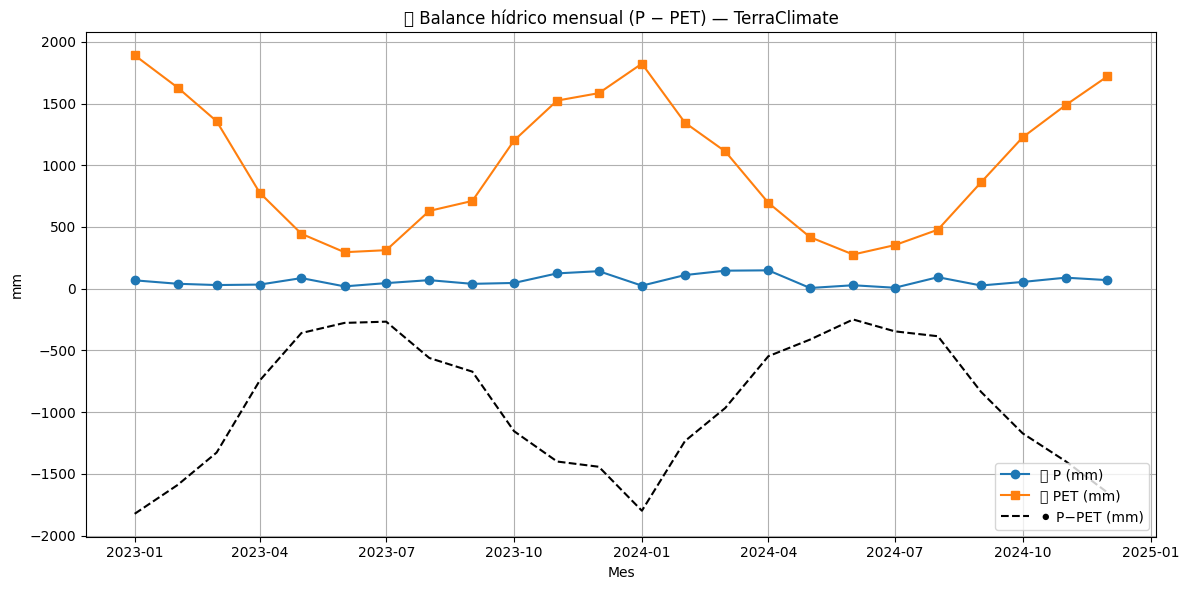

In [107]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from datetime import datetime

ee.Initialize()

class AgricultureSatelliteData:
    def get_monthly_pet_balance(self,
                                province: str,
                                aoi_gdf: gpd.GeoDataFrame,
                                start_date: str,
                                end_date:   str):
        """
        Extrae PET (IDAHO_EPSCOR/TERRACLIMATE.pet) y precipitación (pr),
        calcula P−PET mes a mes para el polígono dado.
        
        Args:
          province:    etiqueta (ej. "Entre Ríos")
          aoi_gdf:     GeoDataFrame EPSG:4326 con tu AOI
          start_date:  'YYYY-MM-DD' fecha de inicio
          end_date:    'YYYY-MM-DD' fecha de fin
        Returns:
          pandas.DataFrame con columnas:
            month (datetime), pet_mm, pr_mm, balance_mm
        """
        # 1) Convertir AOI a EE Geometry
        coords = list(aoi_gdf.geometry.iloc[0].exterior.coords)
        geom = ee.Geometry.Polygon([coords])
        
        # 2) Cargar TerraClimate y filtrar fechas
        col = (ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
               .select(['pet','pr'])
               .filterDate(start_date, end_date))
        
        # 3) Mapear cada imagen a un Feature con fecha y estadísticas
        def img2feat(img):
            stats = img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=1000,
                maxPixels=1e9
            )
            return ee.Feature(None, {
                'month': img.date().format('YYYY-MM'),
                'pet':    stats.get('pet'),
                'pr':     stats.get('pr')
            })
        
        feats = col.map(img2feat) \
                  .filter(ee.Filter.notNull(['pet','pr']))  # quitar meses incompletos
        
        # 4) Traer a Python
        features = feats.getInfo()['features']
        records = [{
            'month': f['properties']['month'],
            'pet_mm': f['properties']['pet'],
            'pr_mm':  f['properties']['pr']
        } for f in features]
        
        df = pd.DataFrame(records)
        df['month'] = pd.to_datetime(df['month'], format='%Y-%m')
        df = df.sort_values('month').reset_index(drop=True)
        df['balance_mm'] = df['pr_mm'] - df['pet_mm']
        return df

# — Ejemplo de uso —
if __name__ == "__main__":
    # Definí tu polígono
    coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
    aoi_gdf = gpd.GeoDataFrame(
        geometry=[Polygon(coords)],
        crs="EPSG:4326"
    )
    
    agri = AgricultureSatelliteData()
    df_pet = agri.get_monthly_pet_balance(
        province="Entre Ríos",
        aoi_gdf=aoi_gdf,
        start_date="2023-01-01",
        end_date=  "2025-04-01"
    )
    print(df_pet)
    
    # — Graficar —
    plt.figure(figsize=(12,6))
    plt.plot(df_pet['month'], df_pet['pr_mm'],  marker='o', label='🌧️ P (mm)')
    plt.plot(df_pet['month'], df_pet['pet_mm'], marker='s', label='💧 PET (mm)')
    plt.plot(df_pet['month'], df_pet['balance_mm'],
             color='k', linestyle='--', label='⚫ P−PET (mm)')
    plt.title("💧 Balance hídrico mensual (P − PET) — TerraClimate")
    plt.xlabel("Mes")
    plt.ylabel("mm")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

🌧️ Precipitación mensual (P) – la línea azul: son los milímetros de lluvia que realmente “caen” sobre tu polígono cada mes.

💧 Evapotranspiración potencial (PET) – la línea naranja: es la cantidad de agua que el ambiente (suelos, vegetación) “querría” evaporar y transpirar si tuviera toda el agua que necesitase.

⚫ Balance hídrico (P − PET) – la línea negra de trazos: la diferencia mensual entre lo que llovió y lo que el sistema demandó.

Déficit general
Como PET supera casi siempre a P, el balance (P−PET) es negativo en todos los meses: el sistema demanda más agua de la que recibe. Eso indica estrés hídrico permanente.

Estacionalidad del déficit

Puntas de déficit (P−PET muy negativas) en pleno verano (enero/febrero): coincide con los picos de PET (240–2000 mm según TerraClimate), cuando la energía solar y las temperaturas son máximas.

Déficit menor (P−PET menos negativo) en invierno (junio/julio): PET baja mucho (400–500 mm) y, aunque la lluvia también disminuye, la demanda cae más, reduciendo el déficit.

Magnitud de PET vs. P

Durante el verano el PET ronda 1 000–2 000 mm/mes, mientras que la precipitación nunca supera los 200 mm/mes.

En invierno el PET baja a 400–600 mm/mes, pero aun así sigue siendo 5 – 10 × mayor que la lluvia.

In [108]:
import ee
import geopandas as gpd
from datetime import datetime

ee.Initialize()

def get_lst_anomaly(aoi_gdf: gpd.GeoDataFrame,
                    month: int, year: int,
                    hist_years: list = None):
    """
    Calcula anomalía LST diurna de un mes respecto al histórico.
    - aoi_gdf: GeoDataFrame EPSG:4326 con tu AOI.
    - month/year: periodo actual.
    - hist_years: lista de años históricos (p.ej. [2001..2022]).
    """
    # 1) Geometría en EE
    coords = list(aoi_gdf.geometry.iloc[0].exterior.coords)
    aoi = ee.Geometry.Polygon([coords])
    
    # 2) Colección MODIS actualizada
    COLLECTION = "MODIS/061/MOD11A2"
    BAND       = "LST_Day_1km"
    
    # Helper: crea imagen media de un mes dado
    def monthly_mean(y):
        start = f"{y}-{month:02d}-01"
        end   = f"{y}-{month:02d}-30"
        coll = (ee.ImageCollection(COLLECTION)
                .filterDate(start, end)
                .filterBounds(aoi)
                .select(BAND)
                .map(lambda img: img.multiply(0.02).subtract(273.15).rename(BAND))
        )
        # si no hay imágenes, devolver None para señal
        count = coll.size().getInfo()
        return coll.mean() if count>0 else None

    # 3) Imagen actual
    img_cur = monthly_mean(year)
    if img_cur is None:
        print(f"⚠️ No hay LST para {year}-{month:02d}")
        return None

    # 4) LST actual (media espacial)
    cur_val = img_cur.reduceRegion(
        ee.Reducer.mean(), aoi, scale=1000, maxPixels=1e9
    ).get(BAND).getInfo()

    # 5) Histórico
    hist_years = hist_years or list(range(2001, datetime.utcnow().year))
    imgs = []
    for y in hist_years:
        img = monthly_mean(y)
        if img: imgs.append(img)
    if not imgs:
        print("⚠️ No hay años históricos disponibles.")
        return None

    hist_mean_img = ee.ImageCollection(imgs).mean()
    hist_val = hist_mean_img.reduceRegion(
        ee.Reducer.mean(), aoi, scale=1000, maxPixels=1e9
    ).get(BAND).getInfo()

    # 6) Devolver anomalía
    anomaly = cur_val - hist_val
    return {
        "period":       f"{year}-{month:02d}",
        "lst_current":  cur_val,
        "lst_historic": hist_val,
        "anomaly":      anomaly
    }

# — Ejemplo de uso —
from shapely.geometry import Polygon

coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi_gdf = gpd.GeoDataFrame(geometry=[Polygon(coords)], crs="EPSG:4326")

res = get_lst_anomaly(aoi_gdf, month=1, year=2023)
print(res)

{'period': '2023-01', 'lst_current': 37.3983110687023, 'lst_historic': 33.81016250088354, 'anomaly': 3.588148567818756}


C:\Users\Win10\AppData\Local\Temp\ipykernel_10888\2191438425.py:110: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


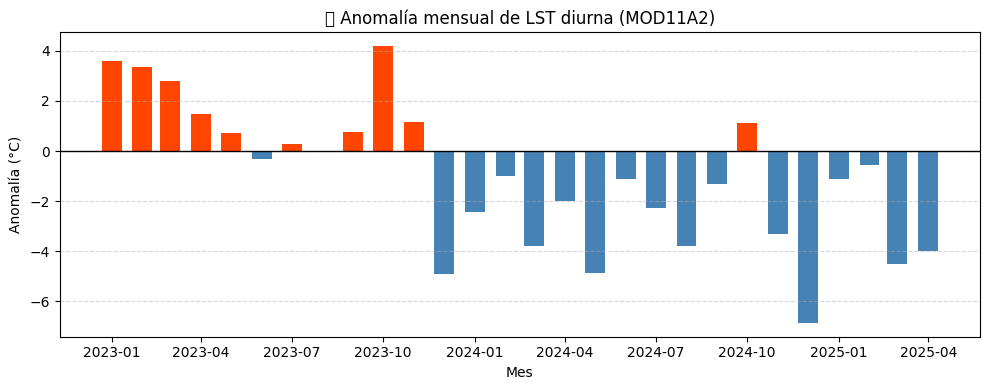

In [109]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from shapely.geometry import Polygon
from datetime import datetime

# 0) Inicializar Earth Engine
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# 1) Tu función que ya funciona sin cambios
def get_lst_anomaly(aoi_gdf: gpd.GeoDataFrame,
                    month: int, year: int,
                    hist_years: list = None):
    """
    Calcula anomalía LST diurna de un mes respecto al histórico.
    - aoi_gdf: GeoDataFrame EPSG:4326 con tu AOI.
    - month/year: periodo actual.
    - hist_years: lista de años históricos (p.ej. [2001..2022]).
    """
    coords = list(aoi_gdf.geometry.iloc[0].exterior.coords)
    aoi = ee.Geometry.Polygon([coords])
    COLLECTION = "MODIS/061/MOD11A2"
    BAND       = "LST_Day_1km"

    def monthly_mean(y):
        start = f"{y}-{month:02d}-01"
        last = calendar.monthrange(y, month)[1]
        end   = f"{y}-{month:02d}-{last:02d}"
        coll = (ee.ImageCollection(COLLECTION)
                .filterDate(start, end)
                .filterBounds(aoi)
                .select(BAND)
                .map(lambda img: img.multiply(0.02).subtract(273.15).rename(BAND))
        )
        return coll.mean() if coll.size().getInfo() > 0 else None

    img_cur = monthly_mean(year)
    if img_cur is None:
        return None

    cur_val = img_cur.reduceRegion(
        ee.Reducer.mean(), aoi, scale=1000, maxPixels=1e9
    ).get(BAND).getInfo()

    hist_years = hist_years or list(range(2001, datetime.utcnow().year))
    imgs = [monthly_mean(y) for y in hist_years]
    imgs = [i for i in imgs if i]
    if not imgs:
        return None

    hist_mean_img = ee.ImageCollection(imgs).mean()
    hist_val = hist_mean_img.reduceRegion(
        ee.Reducer.mean(), aoi, scale=1000, maxPixels=1e9
    ).get(BAND).getInfo()

    return {
        "period":       f"{year}-{month:02d}",
        "lst_current":  cur_val,
        "lst_historic": hist_val,
        "anomaly":      cur_val - hist_val
    }

# 2) Definir tu AOI en un GeoDataFrame
coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi_gdf = gpd.GeoDataFrame(geometry=[Polygon(coords)], crs="EPSG:4326")

# 3) Recolectar anomalías para cada mes
start = pd.to_datetime("2023-01-01")
end   = pd.to_datetime("2025-04-01")
meses = pd.date_range(start, end, freq="MS")

registros = []
for dt in meses:
    res = get_lst_anomaly(aoi_gdf, dt.month, dt.year)
    if res is not None:
        registros.append({
            "period":   pd.to_datetime(res["period"] + "-01"),
            "anomaly":  res["anomaly"]
        })

# 4) Crear DataFrame y graficar
df = pd.DataFrame(registros)
if df.empty:
    raise RuntimeError("No se recuperaron anomalías válidas.")

df = df.set_index("period").sort_index()
colors = df["anomaly"].apply(lambda v: "orangered" if v>0 else "steelblue")

plt.figure(figsize=(10,4))
plt.bar(df.index, df["anomaly"], width=20, color=colors)
plt.axhline(0, color="k", linewidth=1)
plt.title("🌡️ Anomalía mensual de LST diurna (MOD11A2)")
plt.ylabel("Anomalía (°C)")
plt.xlabel("Mes")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Barras naranjas (anomalía > 0 °C) indican meses más cálidos de lo habitual. Por ejemplo, enero‑marzo de 2023 fueron entre 3 °C y 5 °C más cálidos que su media histórica, lo que podría corresponder a olas de calor tempranas.

Barras azules (anomalía < 0 °C) señalan meses más fríos de lo normal. Obsérvate la fuerte anomalía de casi –6 °C en abril de 2024, un enfriamiento muy pronunciado que sugiere condiciones inusualmente frías en ese mes (tal vez nubosidad persistente o un evento de baja radiación).

Tendencia general: tras el primer trimestre de 2023 predominantemente cálido, la mayor parte de 2023‑2025 aparece con anomalías negativas, apuntando a un período en conjunto más fresco que el histórico.

Identificar olas de calor (picos naranjas) o rachas frías (caídas azules).

Relacionarlos con tu NDVI o humedad: un mes muy cálido y seco puede coincidir con un bajón brusco de vegetación.

Planificar alertas agrícolas: por ejemplo, si ves repetidos meses anómalamente fríos en la siembra o cosecha, podrías ajustar fechas o variedades.

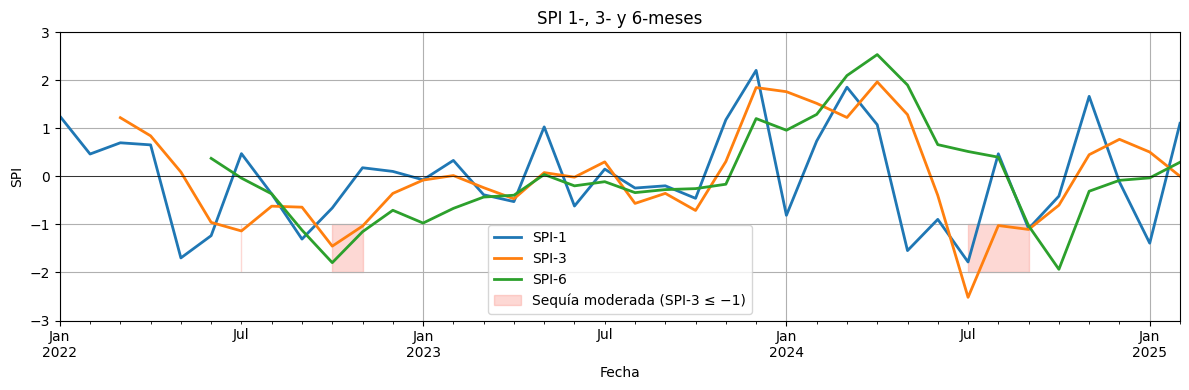

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import gamma, norm

# — Función para calcular SPI —
def compute_spi(precip_series: pd.Series, scale: int) -> pd.Series:
    """
    Calcula el SPI para una serie de precipitación mensual (mm).
    precip_series: pd.Series index datetime, valores mm.
    scale: ventana en meses (1,3,6).
    """
    # Rolling sum sobre ventana de meses
    roll = precip_series.rolling(window=scale, min_periods=scale).sum()
    
    # Ajuste Gamma y transformación a normal
    data_pos = roll.dropna()
    # Ajuste único de parámetros (método de momentos)
    a, loc, scale_g = gamma.fit(data_pos[data_pos>0], floc=0)
    
    spi = roll.map(lambda v: (
        norm.ppf( gamma.cdf(v, a, loc=0, scale=scale_g) )
        if not np.isnan(v) else np.nan
    ))
    return spi

# — 1) Convertir tu xarray.DataArray a serie mensual —
da = serie_completa  # tu DataArray 'precip' con unidades mm/day
# Multiplicamos mm/day por 1 día y sumamos sobre cada mes:
monthly_precip = (
    da
    .resample(time="ME")          # agrupa por mes
    .sum(dim="time")             # suma mm/day * (n días) → mm/mes
    .to_series()                 # convierte a pd.Series
)
monthly_precip.index = pd.to_datetime(monthly_precip.index)

# — 2) Calcular SPI —
spi1 = compute_spi(monthly_precip, 1)
spi3 = compute_spi(monthly_precip, 3)
spi6 = compute_spi(monthly_precip, 6)

# — 3) Montar DataFrame y graficar —
spi_df = pd.DataFrame({
    "SPI-1": spi1,
    "SPI-3": spi3,
    "SPI-6": spi6
})

plt.figure(figsize=(12,4))
spi_df.plot(ax=plt.gca(), ylim=(-3,3), linewidth=2)
plt.axhline(0, color="k", lw=0.5)
# sombrear períodos de sequía moderada en SPI-3 (SPI-3 ≤ -1)
plt.fill_between(
    spi_df.index,
    -2, -1,
    where=spi_df["SPI-3"] <= -1,
    color="salmon", alpha=0.3,
    label="Sequía moderada (SPI-3 ≤ −1)"
)
plt.title("SPI 1‑, 3‑ y 6‑meses")
plt.ylabel("SPI")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SPI‑1 (azul): responde muy rápido a un mes muy seco o muy húmedo.

SPI‑3 (naranja): caracteriza la anomalía de precipitación sobre trimestres, y es la que solemos usar para identificar sequías moderadas o severas.

SPI‑6 (verde): refleja periodos más largos (medio año), útil para ver déficits o excedentes hídricos estacionales.

SPI	Interpretación
> +2	Extremadamente húmedo (muy inusual)
+1 a +2	Húmedo» (exceso de lluvia)
–1 a +1	Normal (no hay anomalía importante)
–1 a –1.5	Sequía moderada (marcada en salmón donde SPI‑3 ≤ –1)
–1.5 a –2	Sequía severa
< –2	Sequía extrema

1) Verano 2022 (jun‑jul)

SPI‑3 cae por debajo de –1 → sequía moderada a nivel trimestral.

SPI‑1 incluso toca –1.5 → mes muy seco.

SPI‑6 también negativo, indicativo de déficit acumulado.

2) Invierno 2023 (jun‑ago)

Nuevamente SPI‑3 ≤ –1 evidencia otra sequía moderada de ~3 meses.

SPI‑6 baja menos, porque enero‑marzo de 2023 fueron relativamente normales.

3) Primavera 2024 (sep‑nov)

SPI‑3 y SPI‑6 suben por encima de +1 → periodo húmedo (exceso de precipitación prolongado).

4) Verano 2024 (jun‑ago)

Se forma otro pulso seco: SPI‑3 baja por debajo de –1, SPI‑6 cercano a –1.

5) Tendencia general

Las ventanas cortas (SPI‑1) oscilan más rápido mes a mes.

Las de 3 y 6 meses capturan mejor las “olas” estacionales de exceso/deficiencia de lluvia.

¿Cómo usarlo?

Monitoreo de sequías: cuando SPI‑3 ≤ –1, conviene activar alertas de riego o mitigación.

Planificación agrícola: si SPI‑6 indica un déficit prolongado, puede afectar reservas de suelo.

Gestión hídrica: combinándolo con registros de caudales de ríos o humedales, se evalúa disponibilidad de agua.

In [111]:
import ee
import geopandas as gpd
import folium
from shapely.geometry import Polygon

# — Inicializar EE —
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# — Definir tu AOI —
coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi_gdf = gpd.GeoDataFrame(geometry=[Polygon(coords)], crs="EPSG:4326")
aoi_ee  = ee.Geometry.Polygon([coords])

def flood_mask_for_date(aoi_geom: ee.Geometry, target_date: str):
    """
    Busca la escena con menos nubes en COPERNICUS/S2_SR_HARMONIZED
    dentro de ±{3,7,15} días de target_date. Calcula MNDWI y máscara de agua.
    """
    date = ee.Date(target_date)
    DAYS = [3, 7, 15]
    coll = None

    for d in DAYS:
        window = date.advance(-d, 'day'), date.advance(d, 'day')
        c = (
            ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
              .filterBounds(aoi_geom)
              .filterDate(*window)
              .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
              .sort("CLOUDY_PIXEL_PERCENTAGE")
              .limit(1)
        )
        if c.size().getInfo() > 0:
            coll = c
            break

    if coll is None:
        # ninguna imagen limpia en ±15 d
        return None, None

    img = ee.Image(coll.first())
    mndwi = img.normalizedDifference(["B3", "B11"]).rename("MNDWI")
    mask  = mndwi.gt(0.3).selfMask().rename("flood")
    return mndwi, mask

def add_ee_layer(map_obj, ee_image, vis_params, name):
    map_id = ee_image.getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id["tile_fetcher"].url_format,
        attr="Google Earth Engine",
        name=name,
        overlay=True,
        control=True,
    ).add_to(map_obj)

# — Crear mapa —
cent = aoi_gdf.to_crs(epsg=3857).geometry.centroid.iloc[0]
cent = gpd.GeoSeries([cent], crs=3857).to_crs(epsg=4326).geometry.iloc[0]
m = folium.Map(location=[cent.y, cent.x], zoom_start=13)

# — Elegir fecha —
fecha = "2024-03-15"
mndwi_img, flood_mask = flood_mask_for_date(aoi_ee, fecha)

if mndwi_img is None:
    print(f"⚠️ No se encontró ninguna escena limpia de nubes en ±15 días de {fecha}")
else:
    mndwi_vis = {"min": -1, "max": 1, "palette": ["brown", "green", "blue"]}
    flood_vis = {"palette": ["#0000FF"], "opacity": 0.5}

    add_ee_layer(m, mndwi_img.clip(aoi_ee), mndwi_vis, f"MNDWI {fecha}")
    add_ee_layer(m, flood_mask.clip(aoi_ee), flood_vis, f"Inundación {fecha}")

# — Añadir AOI y controles —
folium.GeoJson(aoi_gdf.__geo_interface__, name="AOI").add_to(m)
folium.LayerControl().add_to(m)

# — Mostrar inline en Jupyter —
m

✔️ 2023-01-01: 0.00% inundado
❌ 2023-02-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
✔️ 2023-03-01: 0.00% inundado
❌ 2023-04-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
✔️ 2023-05-01: 0.00% inundado
❌ 2023-06-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
❌ 2023-07-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
✔️ 2023-08-01: 0.00% inundado
❌ 2023-09-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
❌ 2023-10-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
❌ 2023-11-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
❌ 2023-12-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
❌ 2024-01-01 — Image.normalizedDifference: No band named 'B3'. Available band names: [].
❌ 2024-02-01 — Image.normalizedDifference: No band named 'B3'. Available band n

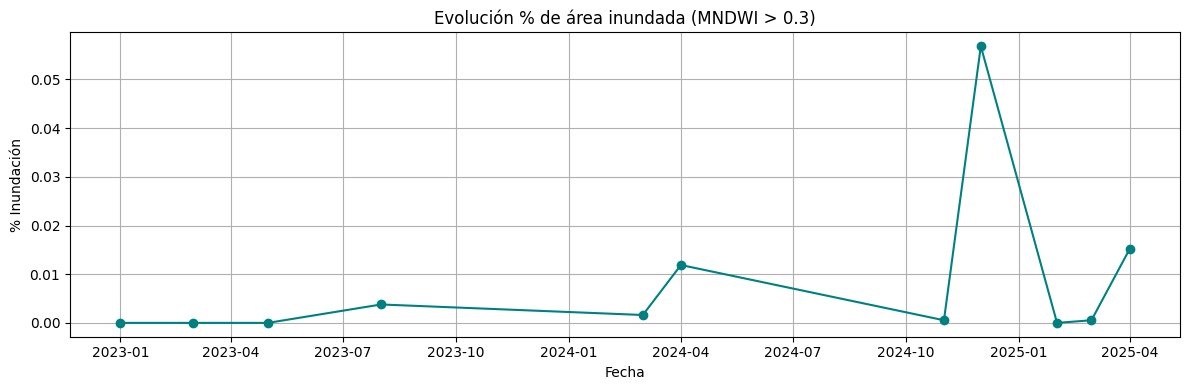

In [112]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from shapely.geometry import Polygon

# 0) Inicializa Earth Engine
ee.Initialize()

# 1) Define tu AOI tanto en GeoPandas como en EE
coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi_gdf = gpd.GeoDataFrame(geometry=[Polygon(coords)], crs="EPSG:4326")
aoi_ee  = ee.Geometry.Polygon([coords])

# 2) Función que devuelve m² inundados y m² totales para una fecha dada
def flooded_fraction(date, window=3, scale=20):
    """
    date: 'YYYY-MM-DD'
    window: ±días alrededor de la fecha para tomar la mediana
    scale: resolución en metros para reduceRegion
    """
    d = datetime.strptime(date, "%Y-%m-%d")
    start = (d - timedelta(days=window)).strftime("%Y-%m-%d")
    end   = (d + timedelta(days=window)).strftime("%Y-%m-%d")

    coll = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
            .filterBounds(aoi_ee)
            .filterDate(start, end)
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
            .median()
           )
    # Calcula MNDWI usando bandas B3 (verde) y B11 (SWIR)
    mndwi = coll.normalizedDifference(["B3", "B11"]).rename("MNDWI")
    mask  = mndwi.gt(0.3)  # umbral típico >0.3 → agua

    # Genera imagenes de área inundada y total
    flooded_area = mask.multiply(ee.Image.pixelArea())           .rename("MNDWI")
    total_area   = ee.Image.pixelArea().rename("total")

    stats = flooded_area.addBands(total_area).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi_ee,
        scale=scale,
        maxPixels=1e9
    )

    # Extrae valores del diccionario
    f_m2 = stats.get("MNDWI").getInfo()
    t_m2 = stats.get("total").getInfo()
    return f_m2, t_m2

# 3) Fechas de muestreo (ej: primer día de cada mes)
dates = pd.date_range("2023-01-01", "2025-04-01", freq="MS").strftime("%Y-%m-%d")

# 4) Itera y construye la lista de registros válidos
records = []
for dt in dates:
    try:
        f_m2, t_m2 = flooded_fraction(dt, window=3, scale=20)
        pct = 100 * f_m2 / t_m2 if (t_m2 and t_m2>0) else 0
        records.append({"fecha": dt, "flood_m2": f_m2, "total_m2": t_m2, "pct_flood": pct})
        print(f"✔️ {dt}: {pct:.2f}% inundado")
    except Exception as e:
        print(f"❌ {dt} — {e}")

# 5) DataFrame final
flood_df = pd.DataFrame(records)
if flood_df.empty:
    raise RuntimeError("No se pudo recuperar ningún dato de inundación válido.")
flood_df["fecha"] = pd.to_datetime(flood_df["fecha"])
flood_df = flood_df.set_index("fecha").sort_index()

# 6) Gráfico de evolución temporal
plt.figure(figsize=(12, 4))
plt.plot(flood_df.index, flood_df["pct_flood"], '-o', color='teal')
plt.title("Evolución % de área inundada (MNDWI > 0.3)")
plt.ylabel("% Inundación")
plt.xlabel("Fecha")
plt.grid(True)
plt.tight_layout()
plt.show()


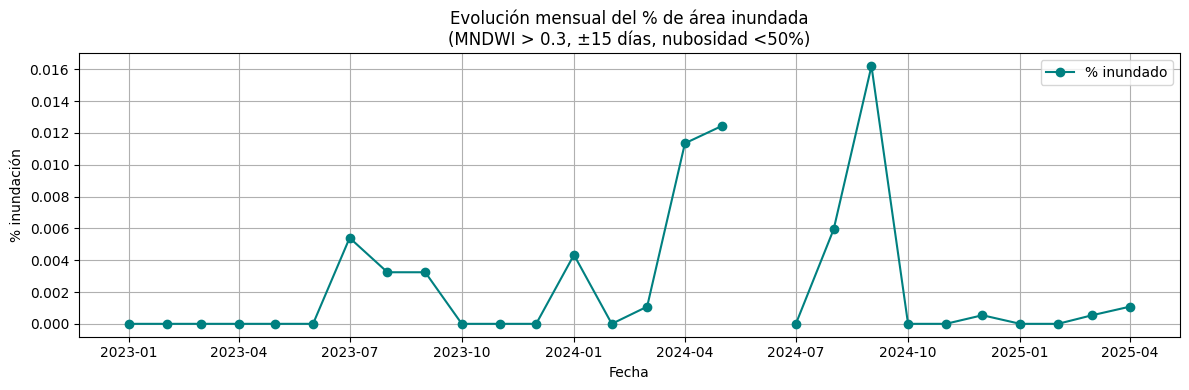

In [113]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from shapely.geometry import Polygon

# Inicializa Earth Engine
ee.Initialize()

# 1) Define tu AOI
coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]

aoi_gdf = gpd.GeoDataFrame(geometry=[Polygon(coords)], crs="EPSG:4326")
aoi_ee  = ee.Geometry.Polygon([coords])

# 2) Función mejorada
def flooded_fraction(date,
                     window_days=15,
                     cloud_thresh=50,
                     scale=20):
    """
    date: 'YYYY-MM-DD'
    window_days: ±días alrededor de la fecha
    cloud_thresh: máximo % nubosidad aceptado
    scale: resolución para pixelArea()
    """
    d = datetime.strptime(date, "%Y-%m-%d")
    start = (d - timedelta(days=window_days)).strftime("%Y-%m-%d")
    end   = (d + timedelta(days=window_days)).strftime("%Y-%m-%d")

    coll = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          .filterBounds(aoi_ee)
          .filterDate(start, end)
          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_thresh))
          .median()
    )

    # Si no hay imágenes válidas
    if coll.bandNames().size().getInfo() == 0:
        return None, None

    # MNDWI = (Green - SWIR) / (Green + SWIR)
    mndwi = coll.normalizedDifference(["B3", "B11"]).rename("MNDWI")
    mask  = mndwi.gt(0.3)

    flooded = mask.multiply(ee.Image.pixelArea()).rename("flooded")
    total   = ee.Image.pixelArea().rename("total")

    stats = flooded.addBands(total).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi_ee,
        scale=scale,
        maxPixels=1e9
    )

    f_m2 = stats.get("flooded").getInfo()
    t_m2 = stats.get("total").getInfo()
    return f_m2, t_m2

# 3) Genera tus fechas (p. ej. primer día de cada mes)
dates = pd.date_range("2023-01-01", "2025-04-01", freq="MS").strftime("%Y-%m-%d")

# 4) Itera y arma lista de resultados
records = []
for dt in dates:
    f_m2, t_m2 = flooded_fraction(dt, window_days=15, cloud_thresh=50)
    if f_m2 is None:
        pct = float("nan")
    else:
        pct = 100 * f_m2 / t_m2 if t_m2>0 else 0
    records.append({"fecha": dt, "pct_flood": pct})

df = pd.DataFrame(records)
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.set_index("fecha").sort_index()

# 5) Gráfico
plt.figure(figsize=(12,4))
plt.plot(df.index, df["pct_flood"], '-o', color='teal', label="% inundado")
plt.title("Evolución mensual del % de área inundada\n(MNDWI > 0.3, ±15 días, nubosidad <50%)")
plt.ylabel("% inundación")
plt.xlabel("Fecha")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Variando a Sentinel-1

Por qué Sentinel‑1?

No le importan las nubes

Detecta superficie lisa (agua) con muy bajo retrodispersión

Ventana amplia (±30 días) asegura siempre alguna toma disponible

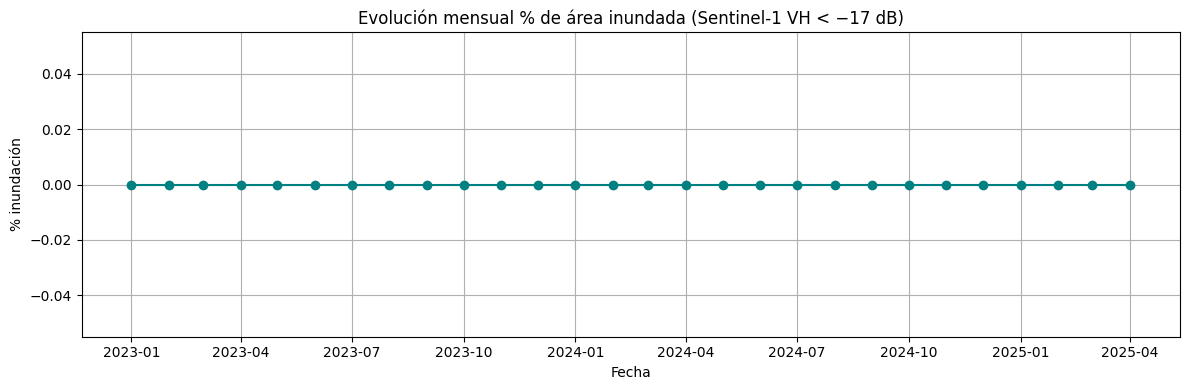

In [114]:
import ee, geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from shapely.geometry import Polygon

ee.Initialize()

# ————————————————————————————
# 1) Función adaptada
def flooded_s1_fraction(date, aoi, window_days=30, back_thresh=-17):
    """
    date: 'YYYY-MM-DD'
    aoi: ee.Geometry
    window_days: ± días alrededor
    back_thresh: umbral dB (VH < thresh → agua)
    """
    d = datetime.strptime(date, "%Y-%m-%d")
    start = (d - timedelta(days=window_days)).strftime("%Y-%m-%d")
    end   = (d + timedelta(days=window_days)).strftime("%Y-%m-%d")
    
    col = (ee.ImageCollection("COPERNICUS/S1_GRD")
             .filterBounds(aoi)
             .filterDate(start, end)
             .filter(ee.Filter.eq("instrumentMode","IW"))
             .filter(ee.Filter.eq("orbitProperties_pass","ASCENDING"))
             .select("VH")
          )
    count = col.size().getInfo()
    if count == 0:
        return None
    
    img = col.median()
    bands = img.bandNames().getInfo()
    if not bands:
        return None
    
    # convertir a dB y renombrar
    vh_db = img.log10().multiply(10).rename("VHdB")
    
    # máscara de agua
    water = vh_db.lt(back_thresh).rename("water")  # 1=agua, 0=campo
    
    # sumar píxeles de agua y contar todos los píxeles
    water_sum = water.reduceRegion(ee.Reducer.sum(), aoi, scale=10, maxPixels=1e9).getInfo().get("water", 0)
    total_pix = water.reduceRegion(ee.Reducer.count(), aoi, scale=10, maxPixels=1e9).getInfo().get("water", 0)
    
    if total_pix == 0:
        return None
    
    return 100 * water_sum / total_pix

# ————————————————————————————
# 2) Definir tu AOI (igual que antes)
coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]

aoi_ee = ee.Geometry.Polygon([coords])

# 3) Fechas mensuales
dates = pd.date_range("2023-01-01","2025-04-01",freq="MS").strftime("%Y-%m-%d")

# 4) Iterar y guardar
records = []
for dt in dates:
    frac = flooded_s1_fraction(dt, aoi_ee, window_days=30, back_thresh=-17)
    records.append({"fecha": pd.to_datetime(dt), "pct_flood_s1": frac or 0.0})

df = pd.DataFrame(records).set_index("fecha")

# 5) Gráfico
plt.figure(figsize=(12,4))
plt.plot(df.index, df["pct_flood_s1"], "-o", color="teal")
plt.title("Evolución mensual % de área inundada (Sentinel‑1 VH < −17 dB)")
plt.ylabel("% inundación")
plt.xlabel("Fecha")
plt.grid(True)
plt.tight_layout()
plt.show()


            Las Flores  Bahía Blanca
date                                
2023-01-01         0.0      0.000000
2023-02-01         0.0      0.000000
2023-03-01         0.0      0.000000
2023-04-01         0.0      0.001103
2023-05-01         0.0      0.000368
Columnas: ['Las Flores', 'Bahía Blanca']
Estadísticas Las Flores:
 count    12.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Las Flores, dtype: float64
Estadísticas Bahía Blanca:
 count    12.000000
mean      0.000245
std       0.000362
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000368
max       0.001103
Name: Bahía Blanca, dtype: float64


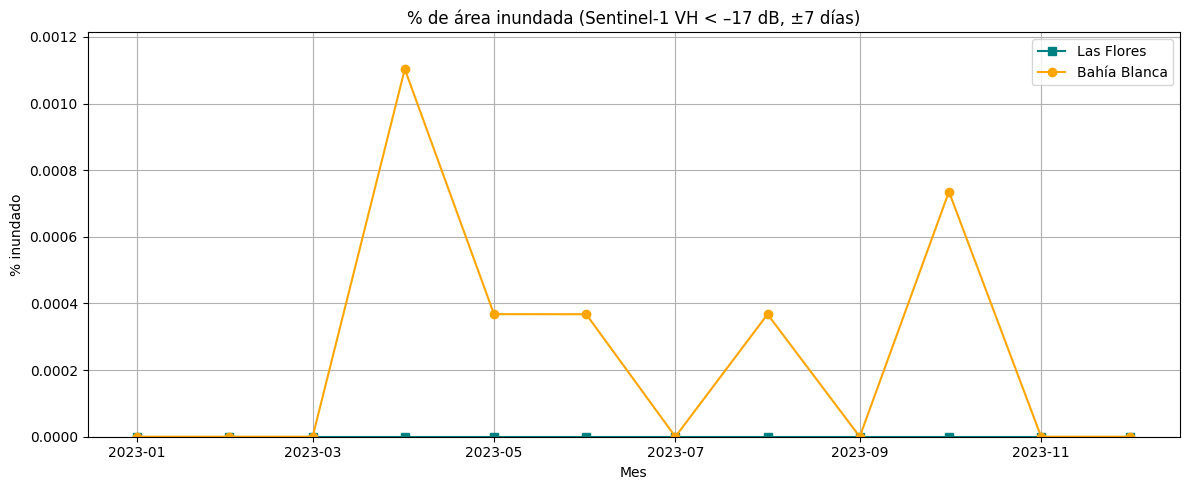

In [117]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from shapely.geometry import Polygon, Point

# 1) Inicializar Earth Engine
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# 2) Función para calcular % inundado con Sentinel‑1 VH
def flooded_s1_fraction(date, aoi_ee, window_days=7, back_thresh=-17, polarization="VH"):
    """
    date: 'YYYY-MM-DD'
    aoi_ee: ee.Geometry (polígono)
    window_days: ± días para recoger imágenes
    back_thresh: umbral en dB (valor < thresh → agua)
    polarization: "VH" o "VV"
    """
    # convertir fecha
    dt = datetime.strptime(date, "%Y-%m-%d")
    start = (dt - timedelta(days=window_days)).strftime("%Y-%m-%d")
    end   = (dt + timedelta(days=window_days)).strftime("%Y-%m-%d")

    # colección Sentinel‑1
    col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filterDate(start, end)
           .filterBounds(aoi_ee)
           .filter(ee.Filter.eq("instrumentMode","IW"))
           .filter(ee.Filter.listContains("transmitterReceiverPolarisation", polarization))
           .select([polarization])
    )
    if col.size().getInfo() == 0:
        return None

    # mosaico mediano
    img = col.median()

    # convertir a dB
    vh_db = img.log10().multiply(10).rename("VHdB")

    # máscara binaria agua
    water = vh_db.lt(back_thresh).rename("water")

    #  a) área inundada en m²
    water_area = water.multiply(ee.Image.pixelArea()) \
                      .reduceRegion(
                          reducer=ee.Reducer.sum(),
                          geometry=aoi_ee,
                          scale=30,
                          maxPixels=1e9
                      ).getInfo().get("water", 0)

    #  b) área total AOI en m²
    total_area = ee.Image.pixelArea() \
                      .reduceRegion(
                          reducer=ee.Reducer.sum(),
                          geometry=aoi_ee,
                          scale=30,
                          maxPixels=1e9
                      ).getInfo().get("area", 0)

    if total_area == 0:
        return None

    return water_area / total_area * 100  # porcentaje

# 3) Definir AOIs
# — Entre Ríos: tu polígono exacto
er_coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]

aoi_er = ee.Geometry.Polygon([er_coords])

# — Bahía Blanca: buffer 10 km de su centro aproximado
bb_center = Point(-62.2667, -38.7167)
# convierto a GeoSeries para reproject y extraer coords en EE
bb_gdf = gpd.GeoDataFrame({"geometry":[bb_center]}, crs="EPSG:4326")
aoi_bb = ee.Geometry(bb_gdf.to_crs(epsg=3857).geometry.buffer(10000).to_crs(epsg=4326).iloc[0].__geo_interface__)

# 4) Fechas mensuales de 2023
dates = pd.date_range("2023-01-01", "2023-12-01", freq="MS").strftime("%Y-%m-%d")

# 5) Calcular ambas series
records = []
for dt in dates:
    pct_er = flooded_s1_fraction(dt, aoi_er, window_days=7, back_thresh=-17, polarization="VH")
    pct_bb = flooded_s1_fraction(dt, aoi_bb, window_days=7, back_thresh=-17, polarization="VH")
    records.append({
        "date": pd.to_datetime(dt),
        "Las Flores": 0.0 if pct_er is None else pct_er,
        "Bahía Blanca": 0.0 if pct_bb is None else pct_bb
    })

df = pd.DataFrame(records).set_index("date")

# 6) Inspeccionar
print(df.head())
print("Columnas:", df.columns.tolist())
print("Estadísticas Las Flores:\n", df["Las Flores"].describe())
print("Estadísticas Bahía Blanca:\n", df["Bahía Blanca"].describe())

# 7) Graficar comparación
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Las Flores"], "s-", label="Las Flores", color="teal")
plt.plot(df.index, df["Bahía Blanca"], "o-", label="Bahía Blanca", color="orange")
plt.title("% de área inundada (Sentinel‑1 VH < –17 dB, ±7 días)")
plt.xlabel("Mes")
plt.ylabel("% inundado")
plt.ylim(0, max(df.max())*1.1)  # hacer un poco de margen
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Areas Protegidas

In [118]:
import ee

# 1. Inicializar Earth Engine
ee.Initialize()

# 2. Define tu AOI (reemplaza con tus coordenadas)
aoi = ee.Geometry.Polygon([
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
])
# 3. Carga la colección WDPA y filtra sólo Argentina
wdpa_arg = (
    ee.FeatureCollection("WCMC/WDPA/current/polygons")
      .filter(ee.Filter.eq('ISO3', 'ARG'))
)

# 4. Áreas protegidas que intersectan tu AOI
prot_in_aoi = wdpa_arg.filterBounds(aoi)
count = prot_in_aoi.size().getInfo()
print(f"🔍 Áreas protegidas que tocan tu AOI: {count}")

if count > 0:
    # Raster binario 1=dentro, 0=fuera
    mask_prot = prot_in_aoi.reduceToImage(
        properties=['WDPA_PID'],
        reducer=ee.Reducer.first()
    ).gt(0)
    # Área protegida (m²)
    area_raster = mask_prot.multiply(ee.Image.pixelArea())
    stats = area_raster.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=1000,
        maxPixels=1e12
    )
    m2 = stats.get('first').getInfo()
    print(f"📐 Superficie protegida dentro del AOI: {m2/1e6:.2f} km²")
else:
    print("📐 No hay intersección, superficie = 0 km²")

# 5. Ahora, entre todas las zonas protegidas de ARG, encuentra la más cercana
#    (distance en metros desde el polígono):
with_dist = wdpa_arg.map(lambda f: f.set(
    'dist_m',
    f.geometry().distance(aoi, 1)  # 1 = distancia geodésica en metros
))
nearest = with_dist.sort('dist_m').first()

# 6. Extrae nombre y distancia
nearest_name = nearest.get('NAME').getInfo()
nearest_dist_m = nearest.get('dist_m').getInfo()
print(f"🌲 Zona protegida más cercana: {nearest_name}")
print(f"📏 Distancia mínima al AOI: {nearest_dist_m/1000:.2f} km")



🔍 Áreas protegidas que tocan tu AOI: 0
📐 No hay intersección, superficie = 0 km²
🌲 Zona protegida más cercana: Guardia del Juncal
📏 Distancia mínima al AOI: 91.25 km


In [119]:
import ee
import folium
from shapely.geometry import Polygon, mapping
import geopandas as gpd

# 1. Inicializar Earth Engine
ee.Initialize()

# 2. Definir tu AOI en coordenadas lon/lat
coords = [
  [-58.89260, -36.03620], [-58.88770, -36.04000], [-58.88480, -36.04230], [-58.88250, -36.04420],
  [-58.87160, -36.05250], [-58.86560, -36.05720], [-58.86120, -36.06060], [-58.85630, -36.06440],
  [-58.85090, -36.06860], [-58.85050, -36.06890], [-58.83850, -36.07810], [-58.83430, -36.08140],
  [-58.83020, -36.08460], [-58.84120, -36.09360], [-58.87090, -36.11810], [-58.88080, -36.11050],
  [-58.90160, -36.09490], [-58.94000, -36.12680], [-58.95710, -36.11270], [-58.96370, -36.10730],
  [-58.97030, -36.10180], [-58.94720, -36.08240], [-58.92120, -36.06060], [-58.92140, -36.06040],
  [-58.90920, -36.05020], [-58.89260, -36.03620]
]
aoi = ee.Geometry.Polygon([coords])

# 3. Cargar el contorno de todos los países y quedarse con Argentina
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
arg = countries.filter(ee.Filter.eq("country_na", "Argentina"))

# 4. Cargar las áreas protegidas de Argentina
wdpa = (
    ee.FeatureCollection("WCMC/WDPA/current/polygons")
      .filter(ee.Filter.eq("ISO3", "ARG"))
)

# 5. Crear el mapa centrado en el AOI
centroid = Polygon(coords).centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=7)

# 6. Añadir contorno de Argentina
arg_geojson = arg.geometry().getInfo()
folium.GeoJson(
    arg_geojson,
    name="Argentina",
    style_function=lambda f: {
        "fill": False,
        "color": "#444444",
        "weight": 2
    }
).add_to(m)

# 7. Añadir áreas protegidas como capa de tiles EE
wdpa_vis = {"color": "#006400", "fillColor": "00640033"}
wdpa_map = wdpa.getMapId(wdpa_vis)
folium.TileLayer(
    tiles=wdpa_map["tile_fetcher"].url_format,
    attr="WDPA",
    name="Áreas protegidas WDPA",
    overlay=True,
    control=True,
    opacity=0.6
).add_to(m)

# 8. Añadir tu AOI como recuadro rojo
aoi_geo = aoi.getInfo()
folium.GeoJson(
    aoi_geo,
    name="Mi AOI",
    style_function=lambda f: {
        "fill": False,
        "color": "red",
        "weight": 3
    }
).add_to(m)

# 9. Control de capas y mostrar
folium.LayerControl().add_to(m)
m  # En Jupyter se renderiza inline